# Afriat

In [1]:
ood_seed = 0

In [2]:
num_ood = 1  # not functioning

In [3]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False


In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [5]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "biolord_afriat.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata

AnnData object with n_obs × n_vars = 19053 × 5000
    obs: 'mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'

In [6]:
df = adata.obs.groupby(['time_cat', 'zone', 'status_control']).size()
availables = list(df[df>100].index)
availables, len(availables)

([('0.0', 'Pericentral', 'Control'),
  ('0.0', 'Periportal', 'Control'),
  ('12.0', 'Pericentral', 'Infected'),
  ('12.0', 'Pericentral', 'Uninfected'),
  ('12.0', 'Periportal', 'Infected'),
  ('12.0', 'Periportal', 'Uninfected'),
  ('2.0', 'Pericentral', 'Uninfected'),
  ('2.0', 'Periportal', 'Infected'),
  ('2.0', 'Periportal', 'Uninfected'),
  ('24.0', 'Pericentral', 'Infected'),
  ('24.0', 'Pericentral', 'Uninfected'),
  ('24.0', 'Periportal', 'Infected'),
  ('24.0', 'Periportal', 'Uninfected'),
  ('30.0', 'Pericentral', 'Infected'),
  ('30.0', 'Pericentral', 'Uninfected'),
  ('30.0', 'Periportal', 'Infected'),
  ('30.0', 'Periportal', 'Uninfected'),
  ('36.0', 'Pericentral', 'Infected'),
  ('36.0', 'Pericentral', 'Uninfected'),
  ('36.0', 'Periportal', 'Infected'),
  ('36.0', 'Periportal', 'Uninfected')],
 21)

In [7]:
def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["time_cat"] == choice[0]) & (adata.obs["zone"] == choice[1]) & (adata.obs["status_control"] == choice[2]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

('0.0', 'Pericentral', 'Control')

Removed datapoint: 546


In [8]:
warmup_epoch_range = [6, 48]
dtc_w1 = 100
dtc_w2 = 10

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = None,
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    dict(
        obs_key = "status_control",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
    dict(
        obs_key = "time_cat",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    ),
    dict(
        obs_key = "zone",
        n_reserved_latent = 8,
        counteractive_minibatch_settings = counteractive_minibatch_settings,
        auxillary_losses = [
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1,
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "negative",
                transformation = "inverse", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2, 
                method = "mse_z", 
                latent_group = "reserved",
                counteractive_example = "positive",
                transformation = "none",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w2 * 1,
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "negative",
                transformation = "none", 
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
            dict(
                apply = True, 
                target_type="categorical",
                progress_bar = False,
                weight = dtc_w1 * 1, 
                method = "mse_z", 
                latent_group = "unreserved_complete",
                counteractive_example = "positive",
                transformation = "inverse",
                warmup_epoch_range=warmup_epoch_range,
                method_kwargs = {}
            ),
        ]
    )
]

In [9]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)),
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.25,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
    encode_covariates = False,
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=128,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=1e-4,
        weight_decay=1e-4,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=None,
    disentenglement_targets_configurations=disentenglement_targets_configurations,
    model_level_metrics=None,
    model_level_metrics_helper_covariates=None
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

tardis.MyModel.setup_wandb(
    wandb_configurations=tardis.config.wandb,
    hyperparams=dict(
        model_params=model_params,
        train_params=train_params,
        dataset_params=dataset_params,
    )
)

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


W&B logger initialized with the following parameters: 
Entity: inecik-academic
Project: tardis_conference
ID: n0n3kz6y
Name: scruffy-looking-xwing-161
Tags: tardis, conference, figures, final
Notes: Final runs for Tardis before conference.
URL: https://wandb.ai/inecik-academic/tardis_conference/runs/n0n3kz6y
Directory: /lustre/groups/ml01/workspace/kemal.inecik/wandb/run-20240504_212225-n0n3kz6y/files



/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `status_control` for `training` set. Number of elements in each group: 2081,3317,9408
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `time_cat` for `training` set. Number of elements in each group: 2081,2571,1679,3495,1612,3368
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `zone` for `training` set. Number of elements in each group: 4009,10797
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `status_control` for `validation` set. Number of elements in each group: 578,792,2331
  possible_indices = CachedPossibleGroupDefinitionIndices.get(
/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `time_cat` for `validation` set. Number of elements in each group: 578,631,429,795,437,831
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


/home/icb/kemal.inecik/work/codes/tardis/tardis/_counteractivegenerator.py:237: UserWarning: Possible group definition indices are calculated for `zone` for `validation` set. Number of elements in each group: 1029,2672
  possible_indices = CachedPossibleGroupDefinitionIndices.get(


Epoch 1/600:   0%|          | 1/600 [00:14<2:20:05, 14.03s/it]

Epoch 1/600:   0%|          | 1/600 [00:14<2:20:05, 14.03s/it, v_num=6y_1, total_loss_train=3.76e+3, kl_local_train=55.7]

Epoch 2/600:   0%|          | 1/600 [00:14<2:20:05, 14.03s/it, v_num=6y_1, total_loss_train=3.76e+3, kl_local_train=55.7]

Epoch 2/600:   0%|          | 2/600 [00:26<2:13:28, 13.39s/it, v_num=6y_1, total_loss_train=3.76e+3, kl_local_train=55.7]

Epoch 2/600:   0%|          | 2/600 [00:26<2:13:28, 13.39s/it, v_num=6y_1, total_loss_train=3.23e+3, kl_local_train=82.6]

Epoch 3/600:   0%|          | 2/600 [00:26<2:13:28, 13.39s/it, v_num=6y_1, total_loss_train=3.23e+3, kl_local_train=82.6]

Epoch 3/600:   0%|          | 3/600 [00:39<2:10:54, 13.16s/it, v_num=6y_1, total_loss_train=3.23e+3, kl_local_train=82.6]

Epoch 3/600:   0%|          | 3/600 [00:39<2:10:54, 13.16s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=83.9]

Epoch 4/600:   0%|          | 3/600 [00:39<2:10:54, 13.16s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=83.9]

Epoch 4/600:   1%|          | 4/600 [00:52<2:09:41, 13.06s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=83.9]

Epoch 4/600:   1%|          | 4/600 [00:52<2:09:41, 13.06s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=81.7]

Epoch 5/600:   1%|          | 4/600 [00:52<2:09:41, 13.06s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=81.7]

Epoch 5/600:   1%|          | 5/600 [01:05<2:08:55, 13.00s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=81.7]

Epoch 5/600:   1%|          | 5/600 [01:05<2:08:55, 13.00s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=76.8]

Epoch 6/600:   1%|          | 5/600 [01:05<2:08:55, 13.00s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=76.8]

Epoch 6/600:   1%|          | 6/600 [01:18<2:08:36, 12.99s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=76.8]

Epoch 6/600:   1%|          | 6/600 [01:18<2:08:36, 12.99s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=69.4]

Epoch 7/600:   1%|          | 6/600 [01:18<2:08:36, 12.99s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=69.4]

Epoch 7/600:   1%|          | 7/600 [01:31<2:08:32, 13.01s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=69.4]

Epoch 7/600:   1%|          | 7/600 [01:31<2:08:32, 13.01s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=58.7]

Epoch 8/600:   1%|          | 7/600 [01:31<2:08:32, 13.01s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=58.7]

Epoch 8/600:   1%|▏         | 8/600 [01:44<2:08:30, 13.02s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=58.7]

Epoch 8/600:   1%|▏         | 8/600 [01:44<2:08:30, 13.02s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=41.4]

Epoch 9/600:   1%|▏         | 8/600 [01:44<2:08:30, 13.02s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=41.4]

Epoch 9/600:   2%|▏         | 9/600 [01:57<2:08:11, 13.01s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=41.4]

Epoch 9/600:   2%|▏         | 9/600 [01:57<2:08:11, 13.01s/it, v_num=6y_1, total_loss_train=3.22e+3, kl_local_train=30.9]

Epoch 10/600:   2%|▏         | 9/600 [01:57<2:08:11, 13.01s/it, v_num=6y_1, total_loss_train=3.22e+3, kl_local_train=30.9]

Epoch 10/600:   2%|▏         | 10/600 [02:10<2:07:52, 13.00s/it, v_num=6y_1, total_loss_train=3.22e+3, kl_local_train=30.9]

Epoch 10/600:   2%|▏         | 10/600 [02:10<2:07:52, 13.00s/it, v_num=6y_1, total_loss_train=3.22e+3, kl_local_train=46.5]

Epoch 11/600:   2%|▏         | 10/600 [02:10<2:07:52, 13.00s/it, v_num=6y_1, total_loss_train=3.22e+3, kl_local_train=46.5]

Epoch 11/600:   2%|▏         | 11/600 [02:23<2:07:35, 13.00s/it, v_num=6y_1, total_loss_train=3.22e+3, kl_local_train=46.5]

Epoch 11/600:   2%|▏         | 11/600 [02:23<2:07:35, 13.00s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=113] 

Epoch 12/600:   2%|▏         | 11/600 [02:23<2:07:35, 13.00s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=113]

Epoch 12/600:   2%|▏         | 12/600 [02:36<2:07:26, 13.00s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=113]

Epoch 12/600:   2%|▏         | 12/600 [02:36<2:07:26, 13.00s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=205]

Epoch 13/600:   2%|▏         | 12/600 [02:36<2:07:26, 13.00s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=205]

Epoch 13/600:   2%|▏         | 13/600 [02:49<2:07:19, 13.01s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=205]

Epoch 13/600:   2%|▏         | 13/600 [02:49<2:07:19, 13.01s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=269]

Epoch 14/600:   2%|▏         | 13/600 [02:49<2:07:19, 13.01s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=269]

Epoch 14/600:   2%|▏         | 14/600 [03:02<2:07:11, 13.02s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=269]

Epoch 14/600:   2%|▏         | 14/600 [03:02<2:07:11, 13.02s/it, v_num=6y_1, total_loss_train=3.22e+3, kl_local_train=316]

Epoch 15/600:   2%|▏         | 14/600 [03:02<2:07:11, 13.02s/it, v_num=6y_1, total_loss_train=3.22e+3, kl_local_train=316]

Epoch 15/600:   2%|▎         | 15/600 [03:15<2:07:10, 13.04s/it, v_num=6y_1, total_loss_train=3.22e+3, kl_local_train=316]

Epoch 15/600:   2%|▎         | 15/600 [03:15<2:07:10, 13.04s/it, v_num=6y_1, total_loss_train=3.22e+3, kl_local_train=366]

Epoch 16/600:   2%|▎         | 15/600 [03:15<2:07:10, 13.04s/it, v_num=6y_1, total_loss_train=3.22e+3, kl_local_train=366]

Epoch 16/600:   3%|▎         | 16/600 [03:28<2:07:03, 13.05s/it, v_num=6y_1, total_loss_train=3.22e+3, kl_local_train=366]

Epoch 16/600:   3%|▎         | 16/600 [03:28<2:07:03, 13.05s/it, v_num=6y_1, total_loss_train=3.23e+3, kl_local_train=399]

Epoch 17/600:   3%|▎         | 16/600 [03:28<2:07:03, 13.05s/it, v_num=6y_1, total_loss_train=3.23e+3, kl_local_train=399]

Epoch 17/600:   3%|▎         | 17/600 [03:42<2:07:00, 13.07s/it, v_num=6y_1, total_loss_train=3.23e+3, kl_local_train=399]

Epoch 17/600:   3%|▎         | 17/600 [03:42<2:07:00, 13.07s/it, v_num=6y_1, total_loss_train=3.23e+3, kl_local_train=429]

Epoch 18/600:   3%|▎         | 17/600 [03:42<2:07:00, 13.07s/it, v_num=6y_1, total_loss_train=3.23e+3, kl_local_train=429]

Epoch 18/600:   3%|▎         | 18/600 [03:55<2:06:59, 13.09s/it, v_num=6y_1, total_loss_train=3.23e+3, kl_local_train=429]

Epoch 18/600:   3%|▎         | 18/600 [03:55<2:06:59, 13.09s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=452]

Epoch 19/600:   3%|▎         | 18/600 [03:55<2:06:59, 13.09s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=452]

Epoch 19/600:   3%|▎         | 19/600 [04:08<2:06:43, 13.09s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=452]

Epoch 19/600:   3%|▎         | 19/600 [04:08<2:06:43, 13.09s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=470]

Epoch 20/600:   3%|▎         | 19/600 [04:08<2:06:43, 13.09s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=470]

Epoch 20/600:   3%|▎         | 20/600 [04:21<2:06:34, 13.09s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=470]

Epoch 20/600:   3%|▎         | 20/600 [04:21<2:06:34, 13.09s/it, v_num=6y_1, total_loss_train=3.25e+3, kl_local_train=511]

Epoch 21/600:   3%|▎         | 20/600 [04:21<2:06:34, 13.09s/it, v_num=6y_1, total_loss_train=3.25e+3, kl_local_train=511]

Epoch 21/600:   4%|▎         | 21/600 [04:34<2:06:24, 13.10s/it, v_num=6y_1, total_loss_train=3.25e+3, kl_local_train=511]

Epoch 21/600:   4%|▎         | 21/600 [04:34<2:06:24, 13.10s/it, v_num=6y_1, total_loss_train=3.25e+3, kl_local_train=548]

Epoch 22/600:   4%|▎         | 21/600 [04:34<2:06:24, 13.10s/it, v_num=6y_1, total_loss_train=3.25e+3, kl_local_train=548]

Epoch 22/600:   4%|▎         | 22/600 [04:47<2:06:00, 13.08s/it, v_num=6y_1, total_loss_train=3.25e+3, kl_local_train=548]

Epoch 22/600:   4%|▎         | 22/600 [04:47<2:06:00, 13.08s/it, v_num=6y_1, total_loss_train=3.25e+3, kl_local_train=643]

Epoch 23/600:   4%|▎         | 22/600 [04:47<2:06:00, 13.08s/it, v_num=6y_1, total_loss_train=3.25e+3, kl_local_train=643]

Epoch 23/600:   4%|▍         | 23/600 [05:00<2:05:28, 13.05s/it, v_num=6y_1, total_loss_train=3.25e+3, kl_local_train=643]

Epoch 23/600:   4%|▍         | 23/600 [05:00<2:05:28, 13.05s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=667]

Epoch 24/600:   4%|▍         | 23/600 [05:00<2:05:28, 13.05s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=667]

Epoch 24/600:   4%|▍         | 24/600 [05:13<2:05:06, 13.03s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=667]

Epoch 24/600:   4%|▍         | 24/600 [05:13<2:05:06, 13.03s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=611]

Epoch 25/600:   4%|▍         | 24/600 [05:13<2:05:06, 13.03s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=611]

Epoch 25/600:   4%|▍         | 25/600 [05:26<2:04:56, 13.04s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=611]

Epoch 25/600:   4%|▍         | 25/600 [05:26<2:04:56, 13.04s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=576]

Epoch 26/600:   4%|▍         | 25/600 [05:26<2:04:56, 13.04s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=576]

Epoch 26/600:   4%|▍         | 26/600 [05:39<2:04:42, 13.04s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=576]

Epoch 26/600:   4%|▍         | 26/600 [05:39<2:04:42, 13.04s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=514]

Epoch 27/600:   4%|▍         | 26/600 [05:39<2:04:42, 13.04s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=514]

Epoch 27/600:   4%|▍         | 27/600 [05:52<2:04:23, 13.02s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=514]

Epoch 27/600:   4%|▍         | 27/600 [05:52<2:04:23, 13.02s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=475]

Epoch 28/600:   4%|▍         | 27/600 [05:52<2:04:23, 13.02s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=475]

Epoch 28/600:   5%|▍         | 28/600 [06:05<2:04:07, 13.02s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=475]

Epoch 28/600:   5%|▍         | 28/600 [06:05<2:04:07, 13.02s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=456]

Epoch 29/600:   5%|▍         | 28/600 [06:05<2:04:07, 13.02s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=456]

Epoch 29/600:   5%|▍         | 29/600 [06:18<2:03:50, 13.01s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=456]

Epoch 29/600:   5%|▍         | 29/600 [06:18<2:03:50, 13.01s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=394]

Epoch 30/600:   5%|▍         | 29/600 [06:18<2:03:50, 13.01s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=394]

Epoch 30/600:   5%|▌         | 30/600 [06:31<2:03:38, 13.02s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=394]

Epoch 30/600:   5%|▌         | 30/600 [06:31<2:03:38, 13.02s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=332]

Epoch 31/600:   5%|▌         | 30/600 [06:31<2:03:38, 13.02s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=332]

Epoch 31/600:   5%|▌         | 31/600 [06:44<2:03:42, 13.04s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=332]

Epoch 31/600:   5%|▌         | 31/600 [06:44<2:03:42, 13.04s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=299]

Epoch 32/600:   5%|▌         | 31/600 [06:44<2:03:42, 13.04s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=299]

Epoch 32/600:   5%|▌         | 32/600 [06:57<2:03:34, 13.05s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=299]

Epoch 32/600:   5%|▌         | 32/600 [06:57<2:03:34, 13.05s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=274]

Epoch 33/600:   5%|▌         | 32/600 [06:57<2:03:34, 13.05s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=274]

Epoch 33/600:   6%|▌         | 33/600 [07:10<2:03:16, 13.04s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=274]

Epoch 33/600:   6%|▌         | 33/600 [07:10<2:03:16, 13.04s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=251]

Epoch 34/600:   6%|▌         | 33/600 [07:10<2:03:16, 13.04s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=251]

Epoch 34/600:   6%|▌         | 34/600 [07:23<2:03:00, 13.04s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=251]

Epoch 34/600:   6%|▌         | 34/600 [07:23<2:03:00, 13.04s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=237]

Epoch 35/600:   6%|▌         | 34/600 [07:23<2:03:00, 13.04s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=237]

Epoch 35/600:   6%|▌         | 35/600 [07:36<2:02:58, 13.06s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=237]

Epoch 35/600:   6%|▌         | 35/600 [07:36<2:02:58, 13.06s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=217]

Epoch 36/600:   6%|▌         | 35/600 [07:36<2:02:58, 13.06s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=217]

Epoch 36/600:   6%|▌         | 36/600 [07:50<2:02:45, 13.06s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=217]

Epoch 36/600:   6%|▌         | 36/600 [07:50<2:02:45, 13.06s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=210]

Epoch 37/600:   6%|▌         | 36/600 [07:50<2:02:45, 13.06s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=210]

Epoch 37/600:   6%|▌         | 37/600 [08:03<2:02:28, 13.05s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=210]

Epoch 37/600:   6%|▌         | 37/600 [08:03<2:02:28, 13.05s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=194]

Epoch 38/600:   6%|▌         | 37/600 [08:03<2:02:28, 13.05s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=194]

Epoch 38/600:   6%|▋         | 38/600 [08:16<2:02:16, 13.05s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=194]

Epoch 38/600:   6%|▋         | 38/600 [08:16<2:02:16, 13.05s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=198]

Epoch 39/600:   6%|▋         | 38/600 [08:16<2:02:16, 13.05s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=198]

Epoch 39/600:   6%|▋         | 39/600 [08:29<2:01:48, 13.03s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=198]

Epoch 39/600:   6%|▋         | 39/600 [08:29<2:01:48, 13.03s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=191]

Epoch 40/600:   6%|▋         | 39/600 [08:29<2:01:48, 13.03s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=191]

Epoch 40/600:   7%|▋         | 40/600 [08:42<2:01:35, 13.03s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=191]

Epoch 40/600:   7%|▋         | 40/600 [08:42<2:01:35, 13.03s/it, v_num=6y_1, total_loss_train=3.25e+3, kl_local_train=188]

Epoch 41/600:   7%|▋         | 40/600 [08:42<2:01:35, 13.03s/it, v_num=6y_1, total_loss_train=3.25e+3, kl_local_train=188]

Epoch 41/600:   7%|▋         | 41/600 [08:55<2:01:16, 13.02s/it, v_num=6y_1, total_loss_train=3.25e+3, kl_local_train=188]

Epoch 41/600:   7%|▋         | 41/600 [08:55<2:01:16, 13.02s/it, v_num=6y_1, total_loss_train=3.25e+3, kl_local_train=186]

Epoch 42/600:   7%|▋         | 41/600 [08:55<2:01:16, 13.02s/it, v_num=6y_1, total_loss_train=3.25e+3, kl_local_train=186]

Epoch 42/600:   7%|▋         | 42/600 [09:08<2:01:10, 13.03s/it, v_num=6y_1, total_loss_train=3.25e+3, kl_local_train=186]

Epoch 42/600:   7%|▋         | 42/600 [09:08<2:01:10, 13.03s/it, v_num=6y_1, total_loss_train=3.25e+3, kl_local_train=182]

Epoch 43/600:   7%|▋         | 42/600 [09:08<2:01:10, 13.03s/it, v_num=6y_1, total_loss_train=3.25e+3, kl_local_train=182]

Epoch 43/600:   7%|▋         | 43/600 [09:21<2:00:52, 13.02s/it, v_num=6y_1, total_loss_train=3.25e+3, kl_local_train=182]

Epoch 43/600:   7%|▋         | 43/600 [09:21<2:00:52, 13.02s/it, v_num=6y_1, total_loss_train=3.25e+3, kl_local_train=173]

Epoch 44/600:   7%|▋         | 43/600 [09:21<2:00:52, 13.02s/it, v_num=6y_1, total_loss_train=3.25e+3, kl_local_train=173]

Epoch 44/600:   7%|▋         | 44/600 [09:34<2:00:33, 13.01s/it, v_num=6y_1, total_loss_train=3.25e+3, kl_local_train=173]

Epoch 44/600:   7%|▋         | 44/600 [09:34<2:00:33, 13.01s/it, v_num=6y_1, total_loss_train=3.25e+3, kl_local_train=179]

Epoch 45/600:   7%|▋         | 44/600 [09:34<2:00:33, 13.01s/it, v_num=6y_1, total_loss_train=3.25e+3, kl_local_train=179]

Epoch 45/600:   8%|▊         | 45/600 [09:47<2:00:14, 13.00s/it, v_num=6y_1, total_loss_train=3.25e+3, kl_local_train=179]

Epoch 45/600:   8%|▊         | 45/600 [09:47<2:00:14, 13.00s/it, v_num=6y_1, total_loss_train=3.26e+3, kl_local_train=182]

Epoch 46/600:   8%|▊         | 45/600 [09:47<2:00:14, 13.00s/it, v_num=6y_1, total_loss_train=3.26e+3, kl_local_train=182]

Epoch 46/600:   8%|▊         | 46/600 [10:00<2:00:16, 13.03s/it, v_num=6y_1, total_loss_train=3.26e+3, kl_local_train=182]

Epoch 46/600:   8%|▊         | 46/600 [10:00<2:00:16, 13.03s/it, v_num=6y_1, total_loss_train=3.26e+3, kl_local_train=189]

Epoch 47/600:   8%|▊         | 46/600 [10:00<2:00:16, 13.03s/it, v_num=6y_1, total_loss_train=3.26e+3, kl_local_train=189]

Epoch 47/600:   8%|▊         | 47/600 [10:13<1:59:28, 12.96s/it, v_num=6y_1, total_loss_train=3.26e+3, kl_local_train=189]

Epoch 47/600:   8%|▊         | 47/600 [10:13<1:59:28, 12.96s/it, v_num=6y_1, total_loss_train=3.26e+3, kl_local_train=189]

Epoch 48/600:   8%|▊         | 47/600 [10:13<1:59:28, 12.96s/it, v_num=6y_1, total_loss_train=3.26e+3, kl_local_train=189]

Epoch 48/600:   8%|▊         | 48/600 [10:25<1:59:02, 12.94s/it, v_num=6y_1, total_loss_train=3.26e+3, kl_local_train=189]

Epoch 48/600:   8%|▊         | 48/600 [10:25<1:59:02, 12.94s/it, v_num=6y_1, total_loss_train=3.26e+3, kl_local_train=195]

Epoch 49/600:   8%|▊         | 48/600 [10:25<1:59:02, 12.94s/it, v_num=6y_1, total_loss_train=3.26e+3, kl_local_train=195]

Epoch 49/600:   8%|▊         | 49/600 [10:38<1:58:36, 12.91s/it, v_num=6y_1, total_loss_train=3.26e+3, kl_local_train=195]

Epoch 49/600:   8%|▊         | 49/600 [10:38<1:58:36, 12.91s/it, v_num=6y_1, total_loss_train=3.26e+3, kl_local_train=195]

Epoch 50/600:   8%|▊         | 49/600 [10:38<1:58:36, 12.91s/it, v_num=6y_1, total_loss_train=3.26e+3, kl_local_train=195]

Epoch 50/600:   8%|▊         | 50/600 [10:51<1:58:22, 12.91s/it, v_num=6y_1, total_loss_train=3.26e+3, kl_local_train=195]

Epoch 50/600:   8%|▊         | 50/600 [10:51<1:58:22, 12.91s/it, v_num=6y_1, total_loss_train=3.27e+3, kl_local_train=199]

Epoch 51/600:   8%|▊         | 50/600 [10:51<1:58:22, 12.91s/it, v_num=6y_1, total_loss_train=3.27e+3, kl_local_train=199]

Epoch 51/600:   8%|▊         | 51/600 [11:04<1:58:04, 12.90s/it, v_num=6y_1, total_loss_train=3.27e+3, kl_local_train=199]

Epoch 51/600:   8%|▊         | 51/600 [11:04<1:58:04, 12.90s/it, v_num=6y_1, total_loss_train=3.26e+3, kl_local_train=204]

Epoch 52/600:   8%|▊         | 51/600 [11:04<1:58:04, 12.90s/it, v_num=6y_1, total_loss_train=3.26e+3, kl_local_train=204]

Epoch 52/600:   9%|▊         | 52/600 [11:17<1:57:45, 12.89s/it, v_num=6y_1, total_loss_train=3.26e+3, kl_local_train=204]

Epoch 52/600:   9%|▊         | 52/600 [11:17<1:57:45, 12.89s/it, v_num=6y_1, total_loss_train=3.26e+3, kl_local_train=202]

Epoch 53/600:   9%|▊         | 52/600 [11:17<1:57:45, 12.89s/it, v_num=6y_1, total_loss_train=3.26e+3, kl_local_train=202]

Epoch 53/600:   9%|▉         | 53/600 [11:30<1:57:30, 12.89s/it, v_num=6y_1, total_loss_train=3.26e+3, kl_local_train=202]

Epoch 53/600:   9%|▉         | 53/600 [11:30<1:57:30, 12.89s/it, v_num=6y_1, total_loss_train=3.26e+3, kl_local_train=208]

Epoch 54/600:   9%|▉         | 53/600 [11:30<1:57:30, 12.89s/it, v_num=6y_1, total_loss_train=3.26e+3, kl_local_train=208]

Epoch 54/600:   9%|▉         | 54/600 [11:43<1:57:19, 12.89s/it, v_num=6y_1, total_loss_train=3.26e+3, kl_local_train=208]

Epoch 54/600:   9%|▉         | 54/600 [11:43<1:57:19, 12.89s/it, v_num=6y_1, total_loss_train=3.26e+3, kl_local_train=210]

Epoch 55/600:   9%|▉         | 54/600 [11:43<1:57:19, 12.89s/it, v_num=6y_1, total_loss_train=3.26e+3, kl_local_train=210]

Epoch 55/600:   9%|▉         | 55/600 [11:56<1:57:00, 12.88s/it, v_num=6y_1, total_loss_train=3.26e+3, kl_local_train=210]

Epoch 55/600:   9%|▉         | 55/600 [11:56<1:57:00, 12.88s/it, v_num=6y_1, total_loss_train=3.25e+3, kl_local_train=205]

Epoch 56/600:   9%|▉         | 55/600 [11:56<1:57:00, 12.88s/it, v_num=6y_1, total_loss_train=3.25e+3, kl_local_train=205]

Epoch 56/600:   9%|▉         | 56/600 [12:08<1:56:42, 12.87s/it, v_num=6y_1, total_loss_train=3.25e+3, kl_local_train=205]

Epoch 56/600:   9%|▉         | 56/600 [12:08<1:56:42, 12.87s/it, v_num=6y_1, total_loss_train=3.25e+3, kl_local_train=198]

Epoch 57/600:   9%|▉         | 56/600 [12:08<1:56:42, 12.87s/it, v_num=6y_1, total_loss_train=3.25e+3, kl_local_train=198]

Epoch 57/600:  10%|▉         | 57/600 [12:21<1:56:22, 12.86s/it, v_num=6y_1, total_loss_train=3.25e+3, kl_local_train=198]

Epoch 57/600:  10%|▉         | 57/600 [12:21<1:56:22, 12.86s/it, v_num=6y_1, total_loss_train=3.25e+3, kl_local_train=192]

Epoch 58/600:  10%|▉         | 57/600 [12:21<1:56:22, 12.86s/it, v_num=6y_1, total_loss_train=3.25e+3, kl_local_train=192]

Epoch 58/600:  10%|▉         | 58/600 [12:34<1:56:23, 12.88s/it, v_num=6y_1, total_loss_train=3.25e+3, kl_local_train=192]

Epoch 58/600:  10%|▉         | 58/600 [12:34<1:56:23, 12.88s/it, v_num=6y_1, total_loss_train=3.25e+3, kl_local_train=190]

Epoch 59/600:  10%|▉         | 58/600 [12:34<1:56:23, 12.88s/it, v_num=6y_1, total_loss_train=3.25e+3, kl_local_train=190]

Epoch 59/600:  10%|▉         | 59/600 [12:47<1:56:19, 12.90s/it, v_num=6y_1, total_loss_train=3.25e+3, kl_local_train=190]

Epoch 59/600:  10%|▉         | 59/600 [12:47<1:56:19, 12.90s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=189]

Epoch 60/600:  10%|▉         | 59/600 [12:47<1:56:19, 12.90s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=189]

Epoch 60/600:  10%|█         | 60/600 [13:00<1:56:08, 12.90s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=189]

Epoch 60/600:  10%|█         | 60/600 [13:00<1:56:08, 12.90s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=183]

Epoch 61/600:  10%|█         | 60/600 [13:00<1:56:08, 12.90s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=183]

Epoch 61/600:  10%|█         | 61/600 [13:13<1:56:05, 12.92s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=183]

Epoch 61/600:  10%|█         | 61/600 [13:13<1:56:05, 12.92s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=180]

Epoch 62/600:  10%|█         | 61/600 [13:13<1:56:05, 12.92s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=180]

Epoch 62/600:  10%|█         | 62/600 [13:26<1:55:51, 12.92s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=180]

Epoch 62/600:  10%|█         | 62/600 [13:26<1:55:51, 12.92s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=175]

Epoch 63/600:  10%|█         | 62/600 [13:26<1:55:51, 12.92s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=175]

Epoch 63/600:  10%|█         | 63/600 [13:39<1:55:36, 12.92s/it, v_num=6y_1, total_loss_train=3.24e+3, kl_local_train=175]

Epoch 63/600:  10%|█         | 63/600 [13:39<1:55:36, 12.92s/it, v_num=6y_1, total_loss_train=3.23e+3, kl_local_train=170]

Epoch 64/600:  10%|█         | 63/600 [13:39<1:55:36, 12.92s/it, v_num=6y_1, total_loss_train=3.23e+3, kl_local_train=170]

Epoch 64/600:  11%|█         | 64/600 [13:52<1:55:24, 12.92s/it, v_num=6y_1, total_loss_train=3.23e+3, kl_local_train=170]

Epoch 64/600:  11%|█         | 64/600 [13:52<1:55:24, 12.92s/it, v_num=6y_1, total_loss_train=3.23e+3, kl_local_train=166]

Epoch 65/600:  11%|█         | 64/600 [13:52<1:55:24, 12.92s/it, v_num=6y_1, total_loss_train=3.23e+3, kl_local_train=166]

Epoch 65/600:  11%|█         | 65/600 [14:05<1:55:04, 12.91s/it, v_num=6y_1, total_loss_train=3.23e+3, kl_local_train=166]

Epoch 65/600:  11%|█         | 65/600 [14:05<1:55:04, 12.91s/it, v_num=6y_1, total_loss_train=3.23e+3, kl_local_train=163]

Epoch 66/600:  11%|█         | 65/600 [14:05<1:55:04, 12.91s/it, v_num=6y_1, total_loss_train=3.23e+3, kl_local_train=163]

Epoch 66/600:  11%|█         | 66/600 [14:18<1:54:56, 12.92s/it, v_num=6y_1, total_loss_train=3.23e+3, kl_local_train=163]

Epoch 66/600:  11%|█         | 66/600 [14:18<1:54:56, 12.92s/it, v_num=6y_1, total_loss_train=3.23e+3, kl_local_train=163]

Epoch 67/600:  11%|█         | 66/600 [14:18<1:54:56, 12.92s/it, v_num=6y_1, total_loss_train=3.23e+3, kl_local_train=163]

Epoch 67/600:  11%|█         | 67/600 [14:30<1:54:35, 12.90s/it, v_num=6y_1, total_loss_train=3.23e+3, kl_local_train=163]

Epoch 67/600:  11%|█         | 67/600 [14:30<1:54:35, 12.90s/it, v_num=6y_1, total_loss_train=3.23e+3, kl_local_train=162]

Epoch 68/600:  11%|█         | 67/600 [14:30<1:54:35, 12.90s/it, v_num=6y_1, total_loss_train=3.23e+3, kl_local_train=162]

Epoch 68/600:  11%|█▏        | 68/600 [14:43<1:54:20, 12.90s/it, v_num=6y_1, total_loss_train=3.23e+3, kl_local_train=162]

Epoch 68/600:  11%|█▏        | 68/600 [14:43<1:54:20, 12.90s/it, v_num=6y_1, total_loss_train=3.22e+3, kl_local_train=162]

Epoch 69/600:  11%|█▏        | 68/600 [14:43<1:54:20, 12.90s/it, v_num=6y_1, total_loss_train=3.22e+3, kl_local_train=162]

Epoch 69/600:  12%|█▏        | 69/600 [14:56<1:54:02, 12.89s/it, v_num=6y_1, total_loss_train=3.22e+3, kl_local_train=162]

Epoch 69/600:  12%|█▏        | 69/600 [14:56<1:54:02, 12.89s/it, v_num=6y_1, total_loss_train=3.22e+3, kl_local_train=160]

Epoch 70/600:  12%|█▏        | 69/600 [14:56<1:54:02, 12.89s/it, v_num=6y_1, total_loss_train=3.22e+3, kl_local_train=160]

Epoch 70/600:  12%|█▏        | 70/600 [15:09<1:54:12, 12.93s/it, v_num=6y_1, total_loss_train=3.22e+3, kl_local_train=160]

Epoch 70/600:  12%|█▏        | 70/600 [15:09<1:54:12, 12.93s/it, v_num=6y_1, total_loss_train=3.22e+3, kl_local_train=157]

Epoch 71/600:  12%|█▏        | 70/600 [15:09<1:54:12, 12.93s/it, v_num=6y_1, total_loss_train=3.22e+3, kl_local_train=157]

Epoch 71/600:  12%|█▏        | 71/600 [15:22<1:53:58, 12.93s/it, v_num=6y_1, total_loss_train=3.22e+3, kl_local_train=157]

Epoch 71/600:  12%|█▏        | 71/600 [15:22<1:53:58, 12.93s/it, v_num=6y_1, total_loss_train=3.22e+3, kl_local_train=154]

Epoch 72/600:  12%|█▏        | 71/600 [15:22<1:53:58, 12.93s/it, v_num=6y_1, total_loss_train=3.22e+3, kl_local_train=154]

Epoch 72/600:  12%|█▏        | 72/600 [15:35<1:53:47, 12.93s/it, v_num=6y_1, total_loss_train=3.22e+3, kl_local_train=154]

Epoch 72/600:  12%|█▏        | 72/600 [15:35<1:53:47, 12.93s/it, v_num=6y_1, total_loss_train=3.22e+3, kl_local_train=152]

Epoch 73/600:  12%|█▏        | 72/600 [15:35<1:53:47, 12.93s/it, v_num=6y_1, total_loss_train=3.22e+3, kl_local_train=152]

Epoch 73/600:  12%|█▏        | 73/600 [15:48<1:53:29, 12.92s/it, v_num=6y_1, total_loss_train=3.22e+3, kl_local_train=152]

Epoch 73/600:  12%|█▏        | 73/600 [15:48<1:53:29, 12.92s/it, v_num=6y_1, total_loss_train=3.22e+3, kl_local_train=150]

Epoch 74/600:  12%|█▏        | 73/600 [15:48<1:53:29, 12.92s/it, v_num=6y_1, total_loss_train=3.22e+3, kl_local_train=150]

Epoch 74/600:  12%|█▏        | 74/600 [16:01<1:53:04, 12.90s/it, v_num=6y_1, total_loss_train=3.22e+3, kl_local_train=150]

Epoch 74/600:  12%|█▏        | 74/600 [16:01<1:53:04, 12.90s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=148]

Epoch 75/600:  12%|█▏        | 74/600 [16:01<1:53:04, 12.90s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=148]

Epoch 75/600:  12%|█▎        | 75/600 [16:14<1:52:45, 12.89s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=148]

Epoch 75/600:  12%|█▎        | 75/600 [16:14<1:52:45, 12.89s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=146]

Epoch 76/600:  12%|█▎        | 75/600 [16:14<1:52:45, 12.89s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=146]

Epoch 76/600:  13%|█▎        | 76/600 [16:27<1:52:35, 12.89s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=146]

Epoch 76/600:  13%|█▎        | 76/600 [16:27<1:52:35, 12.89s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=145]

Epoch 77/600:  13%|█▎        | 76/600 [16:27<1:52:35, 12.89s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=145]

Epoch 77/600:  13%|█▎        | 77/600 [16:39<1:52:18, 12.88s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=145]

Epoch 77/600:  13%|█▎        | 77/600 [16:39<1:52:18, 12.88s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=145]

Epoch 78/600:  13%|█▎        | 77/600 [16:39<1:52:18, 12.88s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=145]

Epoch 78/600:  13%|█▎        | 78/600 [16:52<1:52:15, 12.90s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=145]

Epoch 78/600:  13%|█▎        | 78/600 [16:52<1:52:15, 12.90s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=146]

Epoch 79/600:  13%|█▎        | 78/600 [16:52<1:52:15, 12.90s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=146]

Epoch 79/600:  13%|█▎        | 79/600 [17:05<1:51:59, 12.90s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=146]

Epoch 79/600:  13%|█▎        | 79/600 [17:05<1:51:59, 12.90s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=146]

Epoch 80/600:  13%|█▎        | 79/600 [17:05<1:51:59, 12.90s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=146]

Epoch 80/600:  13%|█▎        | 80/600 [17:18<1:51:42, 12.89s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=146]

Epoch 80/600:  13%|█▎        | 80/600 [17:18<1:51:42, 12.89s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=144]

Epoch 81/600:  13%|█▎        | 80/600 [17:18<1:51:42, 12.89s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=144]

Epoch 81/600:  14%|█▎        | 81/600 [17:31<1:51:28, 12.89s/it, v_num=6y_1, total_loss_train=3.21e+3, kl_local_train=144]

Epoch 81/600:  14%|█▎        | 81/600 [17:31<1:51:28, 12.89s/it, v_num=6y_1, total_loss_train=3.2e+3, kl_local_train=144] 

Epoch 82/600:  14%|█▎        | 81/600 [17:31<1:51:28, 12.89s/it, v_num=6y_1, total_loss_train=3.2e+3, kl_local_train=144]

Epoch 82/600:  14%|█▎        | 82/600 [17:44<1:51:19, 12.90s/it, v_num=6y_1, total_loss_train=3.2e+3, kl_local_train=144]

Epoch 82/600:  14%|█▎        | 82/600 [17:44<1:51:19, 12.90s/it, v_num=6y_1, total_loss_train=3.2e+3, kl_local_train=145]

Epoch 83/600:  14%|█▎        | 82/600 [17:44<1:51:19, 12.90s/it, v_num=6y_1, total_loss_train=3.2e+3, kl_local_train=145]

Epoch 83/600:  14%|█▍        | 83/600 [17:57<1:50:59, 12.88s/it, v_num=6y_1, total_loss_train=3.2e+3, kl_local_train=145]

Epoch 83/600:  14%|█▍        | 83/600 [17:57<1:50:59, 12.88s/it, v_num=6y_1, total_loss_train=3.2e+3, kl_local_train=144]

Epoch 84/600:  14%|█▍        | 83/600 [17:57<1:50:59, 12.88s/it, v_num=6y_1, total_loss_train=3.2e+3, kl_local_train=144]

Epoch 84/600:  14%|█▍        | 84/600 [18:10<1:50:46, 12.88s/it, v_num=6y_1, total_loss_train=3.2e+3, kl_local_train=144]

Epoch 84/600:  14%|█▍        | 84/600 [18:10<1:50:46, 12.88s/it, v_num=6y_1, total_loss_train=3.2e+3, kl_local_train=142]

Epoch 85/600:  14%|█▍        | 84/600 [18:10<1:50:46, 12.88s/it, v_num=6y_1, total_loss_train=3.2e+3, kl_local_train=142]

Epoch 85/600:  14%|█▍        | 85/600 [18:23<1:50:31, 12.88s/it, v_num=6y_1, total_loss_train=3.2e+3, kl_local_train=142]

Epoch 85/600:  14%|█▍        | 85/600 [18:23<1:50:31, 12.88s/it, v_num=6y_1, total_loss_train=3.2e+3, kl_local_train=141]

Epoch 86/600:  14%|█▍        | 85/600 [18:23<1:50:31, 12.88s/it, v_num=6y_1, total_loss_train=3.2e+3, kl_local_train=141]

Epoch 86/600:  14%|█▍        | 86/600 [18:35<1:50:25, 12.89s/it, v_num=6y_1, total_loss_train=3.2e+3, kl_local_train=141]

Epoch 86/600:  14%|█▍        | 86/600 [18:35<1:50:25, 12.89s/it, v_num=6y_1, total_loss_train=3.2e+3, kl_local_train=139]

Epoch 87/600:  14%|█▍        | 86/600 [18:35<1:50:25, 12.89s/it, v_num=6y_1, total_loss_train=3.2e+3, kl_local_train=139]

Epoch 87/600:  14%|█▍        | 87/600 [18:48<1:50:07, 12.88s/it, v_num=6y_1, total_loss_train=3.2e+3, kl_local_train=139]

Epoch 87/600:  14%|█▍        | 87/600 [18:48<1:50:07, 12.88s/it, v_num=6y_1, total_loss_train=3.2e+3, kl_local_train=140]

Epoch 88/600:  14%|█▍        | 87/600 [18:48<1:50:07, 12.88s/it, v_num=6y_1, total_loss_train=3.2e+3, kl_local_train=140]

Epoch 88/600:  15%|█▍        | 88/600 [19:01<1:49:47, 12.87s/it, v_num=6y_1, total_loss_train=3.2e+3, kl_local_train=140]

Epoch 88/600:  15%|█▍        | 88/600 [19:01<1:49:47, 12.87s/it, v_num=6y_1, total_loss_train=3.2e+3, kl_local_train=139]

Epoch 89/600:  15%|█▍        | 88/600 [19:01<1:49:47, 12.87s/it, v_num=6y_1, total_loss_train=3.2e+3, kl_local_train=139]

Epoch 89/600:  15%|█▍        | 89/600 [19:14<1:49:35, 12.87s/it, v_num=6y_1, total_loss_train=3.2e+3, kl_local_train=139]

Epoch 89/600:  15%|█▍        | 89/600 [19:14<1:49:35, 12.87s/it, v_num=6y_1, total_loss_train=3.19e+3, kl_local_train=139]

Epoch 90/600:  15%|█▍        | 89/600 [19:14<1:49:35, 12.87s/it, v_num=6y_1, total_loss_train=3.19e+3, kl_local_train=139]

Epoch 90/600:  15%|█▌        | 90/600 [19:27<1:49:26, 12.87s/it, v_num=6y_1, total_loss_train=3.19e+3, kl_local_train=139]

Epoch 90/600:  15%|█▌        | 90/600 [19:27<1:49:26, 12.87s/it, v_num=6y_1, total_loss_train=3.19e+3, kl_local_train=137]

Epoch 91/600:  15%|█▌        | 90/600 [19:27<1:49:26, 12.87s/it, v_num=6y_1, total_loss_train=3.19e+3, kl_local_train=137]

Epoch 91/600:  15%|█▌        | 91/600 [19:40<1:49:01, 12.85s/it, v_num=6y_1, total_loss_train=3.19e+3, kl_local_train=137]

Epoch 91/600:  15%|█▌        | 91/600 [19:40<1:49:01, 12.85s/it, v_num=6y_1, total_loss_train=3.19e+3, kl_local_train=137]

Epoch 92/600:  15%|█▌        | 91/600 [19:40<1:49:01, 12.85s/it, v_num=6y_1, total_loss_train=3.19e+3, kl_local_train=137]

Epoch 92/600:  15%|█▌        | 92/600 [19:53<1:48:42, 12.84s/it, v_num=6y_1, total_loss_train=3.19e+3, kl_local_train=137]

Epoch 92/600:  15%|█▌        | 92/600 [19:53<1:48:42, 12.84s/it, v_num=6y_1, total_loss_train=3.19e+3, kl_local_train=138]

Epoch 93/600:  15%|█▌        | 92/600 [19:53<1:48:42, 12.84s/it, v_num=6y_1, total_loss_train=3.19e+3, kl_local_train=138]

Epoch 93/600:  16%|█▌        | 93/600 [20:05<1:48:42, 12.86s/it, v_num=6y_1, total_loss_train=3.19e+3, kl_local_train=138]

Epoch 93/600:  16%|█▌        | 93/600 [20:05<1:48:42, 12.86s/it, v_num=6y_1, total_loss_train=3.19e+3, kl_local_train=137]

Epoch 94/600:  16%|█▌        | 93/600 [20:05<1:48:42, 12.86s/it, v_num=6y_1, total_loss_train=3.19e+3, kl_local_train=137]

Epoch 94/600:  16%|█▌        | 94/600 [20:18<1:48:32, 12.87s/it, v_num=6y_1, total_loss_train=3.19e+3, kl_local_train=137]

Epoch 94/600:  16%|█▌        | 94/600 [20:18<1:48:32, 12.87s/it, v_num=6y_1, total_loss_train=3.19e+3, kl_local_train=135]

Epoch 95/600:  16%|█▌        | 94/600 [20:18<1:48:32, 12.87s/it, v_num=6y_1, total_loss_train=3.19e+3, kl_local_train=135]

Epoch 95/600:  16%|█▌        | 95/600 [20:31<1:48:08, 12.85s/it, v_num=6y_1, total_loss_train=3.19e+3, kl_local_train=135]

Epoch 95/600:  16%|█▌        | 95/600 [20:31<1:48:08, 12.85s/it, v_num=6y_1, total_loss_train=3.19e+3, kl_local_train=135]

Epoch 96/600:  16%|█▌        | 95/600 [20:31<1:48:08, 12.85s/it, v_num=6y_1, total_loss_train=3.19e+3, kl_local_train=135]

Epoch 96/600:  16%|█▌        | 96/600 [20:44<1:47:44, 12.83s/it, v_num=6y_1, total_loss_train=3.19e+3, kl_local_train=135]

Epoch 96/600:  16%|█▌        | 96/600 [20:44<1:47:44, 12.83s/it, v_num=6y_1, total_loss_train=3.19e+3, kl_local_train=135]

Epoch 97/600:  16%|█▌        | 96/600 [20:44<1:47:44, 12.83s/it, v_num=6y_1, total_loss_train=3.19e+3, kl_local_train=135]

Epoch 97/600:  16%|█▌        | 97/600 [20:57<1:47:27, 12.82s/it, v_num=6y_1, total_loss_train=3.19e+3, kl_local_train=135]

Epoch 97/600:  16%|█▌        | 97/600 [20:57<1:47:27, 12.82s/it, v_num=6y_1, total_loss_train=3.19e+3, kl_local_train=136]

Epoch 98/600:  16%|█▌        | 97/600 [20:57<1:47:27, 12.82s/it, v_num=6y_1, total_loss_train=3.19e+3, kl_local_train=136]

Epoch 98/600:  16%|█▋        | 98/600 [21:10<1:47:20, 12.83s/it, v_num=6y_1, total_loss_train=3.19e+3, kl_local_train=136]

Epoch 98/600:  16%|█▋        | 98/600 [21:10<1:47:20, 12.83s/it, v_num=6y_1, total_loss_train=3.18e+3, kl_local_train=134]

Epoch 99/600:  16%|█▋        | 98/600 [21:10<1:47:20, 12.83s/it, v_num=6y_1, total_loss_train=3.18e+3, kl_local_train=134]

Epoch 99/600:  16%|█▋        | 99/600 [21:22<1:47:06, 12.83s/it, v_num=6y_1, total_loss_train=3.18e+3, kl_local_train=134]

Epoch 99/600:  16%|█▋        | 99/600 [21:22<1:47:06, 12.83s/it, v_num=6y_1, total_loss_train=3.18e+3, kl_local_train=134]

Epoch 100/600:  16%|█▋        | 99/600 [21:22<1:47:06, 12.83s/it, v_num=6y_1, total_loss_train=3.18e+3, kl_local_train=134]

Epoch 100/600:  17%|█▋        | 100/600 [21:35<1:46:59, 12.84s/it, v_num=6y_1, total_loss_train=3.18e+3, kl_local_train=134]

Epoch 100/600:  17%|█▋        | 100/600 [21:35<1:46:59, 12.84s/it, v_num=6y_1, total_loss_train=3.18e+3, kl_local_train=132]

Epoch 101/600:  17%|█▋        | 100/600 [21:35<1:46:59, 12.84s/it, v_num=6y_1, total_loss_train=3.18e+3, kl_local_train=132]

Epoch 101/600:  17%|█▋        | 101/600 [21:48<1:47:00, 12.87s/it, v_num=6y_1, total_loss_train=3.18e+3, kl_local_train=132]

Epoch 101/600:  17%|█▋        | 101/600 [21:48<1:47:00, 12.87s/it, v_num=6y_1, total_loss_train=3.18e+3, kl_local_train=131]

Epoch 102/600:  17%|█▋        | 101/600 [21:48<1:47:00, 12.87s/it, v_num=6y_1, total_loss_train=3.18e+3, kl_local_train=131]

Epoch 102/600:  17%|█▋        | 102/600 [22:01<1:46:53, 12.88s/it, v_num=6y_1, total_loss_train=3.18e+3, kl_local_train=131]

Epoch 102/600:  17%|█▋        | 102/600 [22:01<1:46:53, 12.88s/it, v_num=6y_1, total_loss_train=3.18e+3, kl_local_train=132]

Epoch 103/600:  17%|█▋        | 102/600 [22:01<1:46:53, 12.88s/it, v_num=6y_1, total_loss_train=3.18e+3, kl_local_train=132]

Epoch 103/600:  17%|█▋        | 103/600 [22:14<1:46:35, 12.87s/it, v_num=6y_1, total_loss_train=3.18e+3, kl_local_train=132]

Epoch 103/600:  17%|█▋        | 103/600 [22:14<1:46:35, 12.87s/it, v_num=6y_1, total_loss_train=3.18e+3, kl_local_train=131]

Epoch 104/600:  17%|█▋        | 103/600 [22:14<1:46:35, 12.87s/it, v_num=6y_1, total_loss_train=3.18e+3, kl_local_train=131]

Epoch 104/600:  17%|█▋        | 104/600 [22:27<1:46:23, 12.87s/it, v_num=6y_1, total_loss_train=3.18e+3, kl_local_train=131]

Epoch 104/600:  17%|█▋        | 104/600 [22:27<1:46:23, 12.87s/it, v_num=6y_1, total_loss_train=3.18e+3, kl_local_train=131]

Epoch 105/600:  17%|█▋        | 104/600 [22:27<1:46:23, 12.87s/it, v_num=6y_1, total_loss_train=3.18e+3, kl_local_train=131]

Epoch 105/600:  18%|█▊        | 105/600 [22:40<1:46:10, 12.87s/it, v_num=6y_1, total_loss_train=3.18e+3, kl_local_train=131]

Epoch 105/600:  18%|█▊        | 105/600 [22:40<1:46:10, 12.87s/it, v_num=6y_1, total_loss_train=3.18e+3, kl_local_train=130]

Epoch 106/600:  18%|█▊        | 105/600 [22:40<1:46:10, 12.87s/it, v_num=6y_1, total_loss_train=3.18e+3, kl_local_train=130]

Epoch 106/600:  18%|█▊        | 106/600 [22:53<1:46:03, 12.88s/it, v_num=6y_1, total_loss_train=3.18e+3, kl_local_train=130]

Epoch 106/600:  18%|█▊        | 106/600 [22:53<1:46:03, 12.88s/it, v_num=6y_1, total_loss_train=3.18e+3, kl_local_train=130]

Epoch 107/600:  18%|█▊        | 106/600 [22:53<1:46:03, 12.88s/it, v_num=6y_1, total_loss_train=3.18e+3, kl_local_train=130]

Epoch 107/600:  18%|█▊        | 107/600 [23:05<1:45:50, 12.88s/it, v_num=6y_1, total_loss_train=3.18e+3, kl_local_train=130]

Epoch 107/600:  18%|█▊        | 107/600 [23:05<1:45:50, 12.88s/it, v_num=6y_1, total_loss_train=3.17e+3, kl_local_train=129]

Epoch 108/600:  18%|█▊        | 107/600 [23:05<1:45:50, 12.88s/it, v_num=6y_1, total_loss_train=3.17e+3, kl_local_train=129]

Epoch 108/600:  18%|█▊        | 108/600 [23:18<1:45:39, 12.88s/it, v_num=6y_1, total_loss_train=3.17e+3, kl_local_train=129]

Epoch 108/600:  18%|█▊        | 108/600 [23:18<1:45:39, 12.88s/it, v_num=6y_1, total_loss_train=3.17e+3, kl_local_train=129]

Epoch 109/600:  18%|█▊        | 108/600 [23:18<1:45:39, 12.88s/it, v_num=6y_1, total_loss_train=3.17e+3, kl_local_train=129]

Epoch 109/600:  18%|█▊        | 109/600 [23:31<1:45:30, 12.89s/it, v_num=6y_1, total_loss_train=3.17e+3, kl_local_train=129]

Epoch 109/600:  18%|█▊        | 109/600 [23:31<1:45:30, 12.89s/it, v_num=6y_1, total_loss_train=3.17e+3, kl_local_train=128]

Epoch 110/600:  18%|█▊        | 109/600 [23:31<1:45:30, 12.89s/it, v_num=6y_1, total_loss_train=3.17e+3, kl_local_train=128]

Epoch 110/600:  18%|█▊        | 110/600 [23:44<1:45:24, 12.91s/it, v_num=6y_1, total_loss_train=3.17e+3, kl_local_train=128]

Epoch 110/600:  18%|█▊        | 110/600 [23:44<1:45:24, 12.91s/it, v_num=6y_1, total_loss_train=3.17e+3, kl_local_train=129]

Epoch 111/600:  18%|█▊        | 110/600 [23:44<1:45:24, 12.91s/it, v_num=6y_1, total_loss_train=3.17e+3, kl_local_train=129]

Epoch 111/600:  18%|█▊        | 111/600 [23:57<1:45:09, 12.90s/it, v_num=6y_1, total_loss_train=3.17e+3, kl_local_train=129]

Epoch 111/600:  18%|█▊        | 111/600 [23:57<1:45:09, 12.90s/it, v_num=6y_1, total_loss_train=3.17e+3, kl_local_train=127]

Epoch 112/600:  18%|█▊        | 111/600 [23:57<1:45:09, 12.90s/it, v_num=6y_1, total_loss_train=3.17e+3, kl_local_train=127]

Epoch 112/600:  19%|█▊        | 112/600 [24:10<1:44:48, 12.89s/it, v_num=6y_1, total_loss_train=3.17e+3, kl_local_train=127]

Epoch 112/600:  19%|█▊        | 112/600 [24:10<1:44:48, 12.89s/it, v_num=6y_1, total_loss_train=3.17e+3, kl_local_train=127]

Epoch 113/600:  19%|█▊        | 112/600 [24:10<1:44:48, 12.89s/it, v_num=6y_1, total_loss_train=3.17e+3, kl_local_train=127]

Epoch 113/600:  19%|█▉        | 113/600 [24:23<1:44:39, 12.89s/it, v_num=6y_1, total_loss_train=3.17e+3, kl_local_train=127]

Epoch 113/600:  19%|█▉        | 113/600 [24:23<1:44:39, 12.89s/it, v_num=6y_1, total_loss_train=3.17e+3, kl_local_train=127]

Epoch 114/600:  19%|█▉        | 113/600 [24:23<1:44:39, 12.89s/it, v_num=6y_1, total_loss_train=3.17e+3, kl_local_train=127]

Epoch 114/600:  19%|█▉        | 114/600 [24:36<1:44:35, 12.91s/it, v_num=6y_1, total_loss_train=3.17e+3, kl_local_train=127]

Epoch 114/600:  19%|█▉        | 114/600 [24:36<1:44:35, 12.91s/it, v_num=6y_1, total_loss_train=3.17e+3, kl_local_train=126]

Epoch 115/600:  19%|█▉        | 114/600 [24:36<1:44:35, 12.91s/it, v_num=6y_1, total_loss_train=3.17e+3, kl_local_train=126]

Epoch 115/600:  19%|█▉        | 115/600 [24:49<1:44:28, 12.92s/it, v_num=6y_1, total_loss_train=3.17e+3, kl_local_train=126]

Epoch 115/600:  19%|█▉        | 115/600 [24:49<1:44:28, 12.92s/it, v_num=6y_1, total_loss_train=3.17e+3, kl_local_train=124]

Epoch 116/600:  19%|█▉        | 115/600 [24:49<1:44:28, 12.92s/it, v_num=6y_1, total_loss_train=3.17e+3, kl_local_train=124]

Epoch 116/600:  19%|█▉        | 116/600 [25:02<1:44:44, 12.98s/it, v_num=6y_1, total_loss_train=3.17e+3, kl_local_train=124]

Epoch 116/600:  19%|█▉        | 116/600 [25:02<1:44:44, 12.98s/it, v_num=6y_1, total_loss_train=3.17e+3, kl_local_train=125]

Epoch 117/600:  19%|█▉        | 116/600 [25:02<1:44:44, 12.98s/it, v_num=6y_1, total_loss_train=3.17e+3, kl_local_train=125]

Epoch 117/600:  20%|█▉        | 117/600 [25:15<1:44:26, 12.97s/it, v_num=6y_1, total_loss_train=3.17e+3, kl_local_train=125]

Epoch 117/600:  20%|█▉        | 117/600 [25:15<1:44:26, 12.97s/it, v_num=6y_1, total_loss_train=3.17e+3, kl_local_train=125]

Epoch 118/600:  20%|█▉        | 117/600 [25:15<1:44:26, 12.97s/it, v_num=6y_1, total_loss_train=3.17e+3, kl_local_train=125]

Epoch 118/600:  20%|█▉        | 118/600 [25:28<1:44:01, 12.95s/it, v_num=6y_1, total_loss_train=3.17e+3, kl_local_train=125]

Epoch 118/600:  20%|█▉        | 118/600 [25:28<1:44:01, 12.95s/it, v_num=6y_1, total_loss_train=3.16e+3, kl_local_train=123]

Epoch 119/600:  20%|█▉        | 118/600 [25:28<1:44:01, 12.95s/it, v_num=6y_1, total_loss_train=3.16e+3, kl_local_train=123]

Epoch 119/600:  20%|█▉        | 119/600 [25:41<1:43:38, 12.93s/it, v_num=6y_1, total_loss_train=3.16e+3, kl_local_train=123]

Epoch 119/600:  20%|█▉        | 119/600 [25:41<1:43:38, 12.93s/it, v_num=6y_1, total_loss_train=3.16e+3, kl_local_train=122]

Epoch 120/600:  20%|█▉        | 119/600 [25:41<1:43:38, 12.93s/it, v_num=6y_1, total_loss_train=3.16e+3, kl_local_train=122]

Epoch 120/600:  20%|██        | 120/600 [25:54<1:43:32, 12.94s/it, v_num=6y_1, total_loss_train=3.16e+3, kl_local_train=122]

Epoch 120/600:  20%|██        | 120/600 [25:54<1:43:32, 12.94s/it, v_num=6y_1, total_loss_train=3.16e+3, kl_local_train=124]

Epoch 121/600:  20%|██        | 120/600 [25:54<1:43:32, 12.94s/it, v_num=6y_1, total_loss_train=3.16e+3, kl_local_train=124]

Epoch 121/600:  20%|██        | 121/600 [26:06<1:43:14, 12.93s/it, v_num=6y_1, total_loss_train=3.16e+3, kl_local_train=124]

Epoch 121/600:  20%|██        | 121/600 [26:06<1:43:14, 12.93s/it, v_num=6y_1, total_loss_train=3.16e+3, kl_local_train=123]

Epoch 122/600:  20%|██        | 121/600 [26:07<1:43:14, 12.93s/it, v_num=6y_1, total_loss_train=3.16e+3, kl_local_train=123]

Epoch 122/600:  20%|██        | 122/600 [26:19<1:42:57, 12.92s/it, v_num=6y_1, total_loss_train=3.16e+3, kl_local_train=123]

Epoch 122/600:  20%|██        | 122/600 [26:19<1:42:57, 12.92s/it, v_num=6y_1, total_loss_train=3.16e+3, kl_local_train=122]

Epoch 123/600:  20%|██        | 122/600 [26:19<1:42:57, 12.92s/it, v_num=6y_1, total_loss_train=3.16e+3, kl_local_train=122]

Epoch 123/600:  20%|██        | 123/600 [26:32<1:42:48, 12.93s/it, v_num=6y_1, total_loss_train=3.16e+3, kl_local_train=122]

Epoch 123/600:  20%|██        | 123/600 [26:32<1:42:48, 12.93s/it, v_num=6y_1, total_loss_train=3.16e+3, kl_local_train=123]

Epoch 124/600:  20%|██        | 123/600 [26:32<1:42:48, 12.93s/it, v_num=6y_1, total_loss_train=3.16e+3, kl_local_train=123]

Epoch 124/600:  21%|██        | 124/600 [26:45<1:42:36, 12.93s/it, v_num=6y_1, total_loss_train=3.16e+3, kl_local_train=123]

Epoch 124/600:  21%|██        | 124/600 [26:45<1:42:36, 12.93s/it, v_num=6y_1, total_loss_train=3.16e+3, kl_local_train=122]

Epoch 125/600:  21%|██        | 124/600 [26:45<1:42:36, 12.93s/it, v_num=6y_1, total_loss_train=3.16e+3, kl_local_train=122]

Epoch 125/600:  21%|██        | 125/600 [26:58<1:42:29, 12.95s/it, v_num=6y_1, total_loss_train=3.16e+3, kl_local_train=122]

Epoch 125/600:  21%|██        | 125/600 [26:58<1:42:29, 12.95s/it, v_num=6y_1, total_loss_train=3.16e+3, kl_local_train=121]

Epoch 126/600:  21%|██        | 125/600 [26:58<1:42:29, 12.95s/it, v_num=6y_1, total_loss_train=3.16e+3, kl_local_train=121]

Epoch 126/600:  21%|██        | 126/600 [27:11<1:42:09, 12.93s/it, v_num=6y_1, total_loss_train=3.16e+3, kl_local_train=121]

Epoch 126/600:  21%|██        | 126/600 [27:11<1:42:09, 12.93s/it, v_num=6y_1, total_loss_train=3.16e+3, kl_local_train=121]

Epoch 127/600:  21%|██        | 126/600 [27:11<1:42:09, 12.93s/it, v_num=6y_1, total_loss_train=3.16e+3, kl_local_train=121]

Epoch 127/600:  21%|██        | 127/600 [27:24<1:41:53, 12.92s/it, v_num=6y_1, total_loss_train=3.16e+3, kl_local_train=121]

Epoch 127/600:  21%|██        | 127/600 [27:24<1:41:53, 12.92s/it, v_num=6y_1, total_loss_train=3.16e+3, kl_local_train=120]

Epoch 128/600:  21%|██        | 127/600 [27:24<1:41:53, 12.92s/it, v_num=6y_1, total_loss_train=3.16e+3, kl_local_train=120]

Epoch 128/600:  21%|██▏       | 128/600 [27:37<1:41:43, 12.93s/it, v_num=6y_1, total_loss_train=3.16e+3, kl_local_train=120]

Epoch 128/600:  21%|██▏       | 128/600 [27:37<1:41:43, 12.93s/it, v_num=6y_1, total_loss_train=3.16e+3, kl_local_train=120]

Epoch 129/600:  21%|██▏       | 128/600 [27:37<1:41:43, 12.93s/it, v_num=6y_1, total_loss_train=3.16e+3, kl_local_train=120]

Epoch 129/600:  22%|██▏       | 129/600 [27:50<1:41:23, 12.92s/it, v_num=6y_1, total_loss_train=3.16e+3, kl_local_train=120]

Epoch 129/600:  22%|██▏       | 129/600 [27:50<1:41:23, 12.92s/it, v_num=6y_1, total_loss_train=3.16e+3, kl_local_train=120]

Epoch 130/600:  22%|██▏       | 129/600 [27:50<1:41:23, 12.92s/it, v_num=6y_1, total_loss_train=3.16e+3, kl_local_train=120]

Epoch 130/600:  22%|██▏       | 130/600 [28:03<1:41:06, 12.91s/it, v_num=6y_1, total_loss_train=3.16e+3, kl_local_train=120]

Epoch 130/600:  22%|██▏       | 130/600 [28:03<1:41:06, 12.91s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=120]

Epoch 131/600:  22%|██▏       | 130/600 [28:03<1:41:06, 12.91s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=120]

Epoch 131/600:  22%|██▏       | 131/600 [28:16<1:40:59, 12.92s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=120]

Epoch 131/600:  22%|██▏       | 131/600 [28:16<1:40:59, 12.92s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=120]

Epoch 132/600:  22%|██▏       | 131/600 [28:16<1:40:59, 12.92s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=120]

Epoch 132/600:  22%|██▏       | 132/600 [28:29<1:40:46, 12.92s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=120]

Epoch 132/600:  22%|██▏       | 132/600 [28:29<1:40:46, 12.92s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=118]

Epoch 133/600:  22%|██▏       | 132/600 [28:29<1:40:46, 12.92s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=118]

Epoch 133/600:  22%|██▏       | 133/600 [28:42<1:40:30, 12.91s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=118]

Epoch 133/600:  22%|██▏       | 133/600 [28:42<1:40:30, 12.91s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=118]

Epoch 134/600:  22%|██▏       | 133/600 [28:42<1:40:30, 12.91s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=118]

Epoch 134/600:  22%|██▏       | 134/600 [28:54<1:40:16, 12.91s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=118]

Epoch 134/600:  22%|██▏       | 134/600 [28:54<1:40:16, 12.91s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=118]

Epoch 135/600:  22%|██▏       | 134/600 [28:54<1:40:16, 12.91s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=118]

Epoch 135/600:  22%|██▎       | 135/600 [29:07<1:40:01, 12.91s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=118]

Epoch 135/600:  22%|██▎       | 135/600 [29:07<1:40:01, 12.91s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=118]

Epoch 136/600:  22%|██▎       | 135/600 [29:07<1:40:01, 12.91s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=118]

Epoch 136/600:  23%|██▎       | 136/600 [29:20<1:39:45, 12.90s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=118]

Epoch 136/600:  23%|██▎       | 136/600 [29:20<1:39:45, 12.90s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=117]

Epoch 137/600:  23%|██▎       | 136/600 [29:20<1:39:45, 12.90s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=117]

Epoch 137/600:  23%|██▎       | 137/600 [29:33<1:39:30, 12.90s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=117]

Epoch 137/600:  23%|██▎       | 137/600 [29:33<1:39:30, 12.90s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=117]

Epoch 138/600:  23%|██▎       | 137/600 [29:33<1:39:30, 12.90s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=117]

Epoch 138/600:  23%|██▎       | 138/600 [29:46<1:39:14, 12.89s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=117]

Epoch 138/600:  23%|██▎       | 138/600 [29:46<1:39:14, 12.89s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=118]

Epoch 139/600:  23%|██▎       | 138/600 [29:46<1:39:14, 12.89s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=118]

Epoch 139/600:  23%|██▎       | 139/600 [29:59<1:39:03, 12.89s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=118]

Epoch 139/600:  23%|██▎       | 139/600 [29:59<1:39:03, 12.89s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=116]

Epoch 140/600:  23%|██▎       | 139/600 [29:59<1:39:03, 12.89s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=116]

Epoch 140/600:  23%|██▎       | 140/600 [30:12<1:39:00, 12.91s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=116]

Epoch 140/600:  23%|██▎       | 140/600 [30:12<1:39:00, 12.91s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=116]

Epoch 141/600:  23%|██▎       | 140/600 [30:12<1:39:00, 12.91s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=116]

Epoch 141/600:  24%|██▎       | 141/600 [30:25<1:38:53, 12.93s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=116]

Epoch 141/600:  24%|██▎       | 141/600 [30:25<1:38:53, 12.93s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=116]

Epoch 142/600:  24%|██▎       | 141/600 [30:25<1:38:53, 12.93s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=116]

Epoch 142/600:  24%|██▎       | 142/600 [30:38<1:38:35, 12.92s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=116]

Epoch 142/600:  24%|██▎       | 142/600 [30:38<1:38:35, 12.92s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=116]

Epoch 143/600:  24%|██▎       | 142/600 [30:38<1:38:35, 12.92s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=116]

Epoch 143/600:  24%|██▍       | 143/600 [30:51<1:38:28, 12.93s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=116]

Epoch 143/600:  24%|██▍       | 143/600 [30:51<1:38:28, 12.93s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=115]

Epoch 144/600:  24%|██▍       | 143/600 [30:51<1:38:28, 12.93s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=115]

Epoch 144/600:  24%|██▍       | 144/600 [31:03<1:37:36, 12.84s/it, v_num=6y_1, total_loss_train=3.15e+3, kl_local_train=115]

Epoch 144/600:  24%|██▍       | 144/600 [31:03<1:37:36, 12.84s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=115]

Epoch 145/600:  24%|██▍       | 144/600 [31:03<1:37:36, 12.84s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=115]

Epoch 145/600:  24%|██▍       | 145/600 [31:16<1:37:30, 12.86s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=115]

Epoch 145/600:  24%|██▍       | 145/600 [31:16<1:37:30, 12.86s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=114]

Epoch 146/600:  24%|██▍       | 145/600 [31:16<1:37:30, 12.86s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=114]

Epoch 146/600:  24%|██▍       | 146/600 [31:29<1:37:19, 12.86s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=114]

Epoch 146/600:  24%|██▍       | 146/600 [31:29<1:37:19, 12.86s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=114]

Epoch 147/600:  24%|██▍       | 146/600 [31:29<1:37:19, 12.86s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=114]

Epoch 147/600:  24%|██▍       | 147/600 [31:42<1:37:10, 12.87s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=114]

Epoch 147/600:  24%|██▍       | 147/600 [31:42<1:37:10, 12.87s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=113]

Epoch 148/600:  24%|██▍       | 147/600 [31:42<1:37:10, 12.87s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=113]

Epoch 148/600:  25%|██▍       | 148/600 [31:55<1:37:04, 12.89s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=113]

Epoch 148/600:  25%|██▍       | 148/600 [31:55<1:37:04, 12.89s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=113]

Epoch 149/600:  25%|██▍       | 148/600 [31:55<1:37:04, 12.89s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=113]

Epoch 149/600:  25%|██▍       | 149/600 [32:08<1:36:50, 12.88s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=113]

Epoch 149/600:  25%|██▍       | 149/600 [32:08<1:36:50, 12.88s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=114]

Epoch 150/600:  25%|██▍       | 149/600 [32:08<1:36:50, 12.88s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=114]

Epoch 150/600:  25%|██▌       | 150/600 [32:21<1:36:40, 12.89s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=114]

Epoch 150/600:  25%|██▌       | 150/600 [32:21<1:36:40, 12.89s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=114]

Epoch 151/600:  25%|██▌       | 150/600 [32:21<1:36:40, 12.89s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=114]

Epoch 151/600:  25%|██▌       | 151/600 [32:34<1:36:28, 12.89s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=114]

Epoch 151/600:  25%|██▌       | 151/600 [32:34<1:36:28, 12.89s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=113]

Epoch 152/600:  25%|██▌       | 151/600 [32:34<1:36:28, 12.89s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=113]

Epoch 152/600:  25%|██▌       | 152/600 [32:46<1:36:11, 12.88s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=113]

Epoch 152/600:  25%|██▌       | 152/600 [32:46<1:36:11, 12.88s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=112]

Epoch 153/600:  25%|██▌       | 152/600 [32:46<1:36:11, 12.88s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=112]

Epoch 153/600:  26%|██▌       | 153/600 [32:59<1:36:05, 12.90s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=112]

Epoch 153/600:  26%|██▌       | 153/600 [32:59<1:36:05, 12.90s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=113]

Epoch 154/600:  26%|██▌       | 153/600 [32:59<1:36:05, 12.90s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=113]

Epoch 154/600:  26%|██▌       | 154/600 [33:12<1:35:48, 12.89s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=113]

Epoch 154/600:  26%|██▌       | 154/600 [33:12<1:35:48, 12.89s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=112]

Epoch 155/600:  26%|██▌       | 154/600 [33:12<1:35:48, 12.89s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=112]

Epoch 155/600:  26%|██▌       | 155/600 [33:25<1:35:34, 12.89s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=112]

Epoch 155/600:  26%|██▌       | 155/600 [33:25<1:35:34, 12.89s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=112]

Epoch 156/600:  26%|██▌       | 155/600 [33:25<1:35:34, 12.89s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=112]

Epoch 156/600:  26%|██▌       | 156/600 [33:38<1:35:19, 12.88s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=112]

Epoch 156/600:  26%|██▌       | 156/600 [33:38<1:35:19, 12.88s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=111]

Epoch 157/600:  26%|██▌       | 156/600 [33:38<1:35:19, 12.88s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=111]

Epoch 157/600:  26%|██▌       | 157/600 [33:51<1:35:10, 12.89s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=111]

Epoch 157/600:  26%|██▌       | 157/600 [33:51<1:35:10, 12.89s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=112]

Epoch 158/600:  26%|██▌       | 157/600 [33:51<1:35:10, 12.89s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=112]

Epoch 158/600:  26%|██▋       | 158/600 [34:04<1:34:55, 12.89s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=112]

Epoch 158/600:  26%|██▋       | 158/600 [34:04<1:34:55, 12.89s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=111]

Epoch 159/600:  26%|██▋       | 158/600 [34:04<1:34:55, 12.89s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=111]

Epoch 159/600:  26%|██▋       | 159/600 [34:17<1:34:50, 12.90s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=111]

Epoch 159/600:  26%|██▋       | 159/600 [34:17<1:34:50, 12.90s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=111]

Epoch 160/600:  26%|██▋       | 159/600 [34:17<1:34:50, 12.90s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=111]

Epoch 160/600:  27%|██▋       | 160/600 [34:30<1:34:43, 12.92s/it, v_num=6y_1, total_loss_train=3.14e+3, kl_local_train=111]

Epoch 160/600:  27%|██▋       | 160/600 [34:30<1:34:43, 12.92s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=111]

Epoch 161/600:  27%|██▋       | 160/600 [34:30<1:34:43, 12.92s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=111]

Epoch 161/600:  27%|██▋       | 161/600 [34:43<1:34:35, 12.93s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=111]

Epoch 161/600:  27%|██▋       | 161/600 [34:43<1:34:35, 12.93s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=111]

Epoch 162/600:  27%|██▋       | 161/600 [34:43<1:34:35, 12.93s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=111]

Epoch 162/600:  27%|██▋       | 162/600 [34:56<1:34:23, 12.93s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=111]

Epoch 162/600:  27%|██▋       | 162/600 [34:56<1:34:23, 12.93s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=110]

Epoch 163/600:  27%|██▋       | 162/600 [34:56<1:34:23, 12.93s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=110]

Epoch 163/600:  27%|██▋       | 163/600 [35:08<1:34:06, 12.92s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=110]

Epoch 163/600:  27%|██▋       | 163/600 [35:08<1:34:06, 12.92s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=110]

Epoch 164/600:  27%|██▋       | 163/600 [35:08<1:34:06, 12.92s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=110]

Epoch 164/600:  27%|██▋       | 164/600 [35:21<1:33:52, 12.92s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=110]

Epoch 164/600:  27%|██▋       | 164/600 [35:21<1:33:52, 12.92s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=109]

Epoch 165/600:  27%|██▋       | 164/600 [35:21<1:33:52, 12.92s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=109]

Epoch 165/600:  28%|██▊       | 165/600 [35:34<1:33:38, 12.92s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=109]

Epoch 165/600:  28%|██▊       | 165/600 [35:34<1:33:38, 12.92s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=109]

Epoch 166/600:  28%|██▊       | 165/600 [35:34<1:33:38, 12.92s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=109]

Epoch 166/600:  28%|██▊       | 166/600 [35:47<1:33:24, 12.91s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=109]

Epoch 166/600:  28%|██▊       | 166/600 [35:47<1:33:24, 12.91s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=109]

Epoch 167/600:  28%|██▊       | 166/600 [35:47<1:33:24, 12.91s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=109]

Epoch 167/600:  28%|██▊       | 167/600 [36:00<1:33:09, 12.91s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=109]

Epoch 167/600:  28%|██▊       | 167/600 [36:00<1:33:09, 12.91s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=109]

Epoch 168/600:  28%|██▊       | 167/600 [36:00<1:33:09, 12.91s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=109]

Epoch 168/600:  28%|██▊       | 168/600 [36:13<1:32:49, 12.89s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=109]

Epoch 168/600:  28%|██▊       | 168/600 [36:13<1:32:49, 12.89s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=109]

Epoch 169/600:  28%|██▊       | 168/600 [36:13<1:32:49, 12.89s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=109]

Epoch 169/600:  28%|██▊       | 169/600 [36:26<1:32:34, 12.89s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=109]

Epoch 169/600:  28%|██▊       | 169/600 [36:26<1:32:34, 12.89s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=108]

Epoch 170/600:  28%|██▊       | 169/600 [36:26<1:32:34, 12.89s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=108]

Epoch 170/600:  28%|██▊       | 170/600 [36:39<1:32:07, 12.85s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=108]

Epoch 170/600:  28%|██▊       | 170/600 [36:39<1:32:07, 12.85s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=108]

Epoch 171/600:  28%|██▊       | 170/600 [36:39<1:32:07, 12.85s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=108]

Epoch 171/600:  28%|██▊       | 171/600 [36:51<1:31:57, 12.86s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=108]

Epoch 171/600:  28%|██▊       | 171/600 [36:51<1:31:57, 12.86s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=108]

Epoch 172/600:  28%|██▊       | 171/600 [36:51<1:31:57, 12.86s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=108]

Epoch 172/600:  29%|██▊       | 172/600 [37:04<1:31:51, 12.88s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=108]

Epoch 172/600:  29%|██▊       | 172/600 [37:04<1:31:51, 12.88s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=107]

Epoch 173/600:  29%|██▊       | 172/600 [37:04<1:31:51, 12.88s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=107]

Epoch 173/600:  29%|██▉       | 173/600 [37:17<1:31:30, 12.86s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=107]

Epoch 173/600:  29%|██▉       | 173/600 [37:17<1:31:30, 12.86s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=108]

Epoch 174/600:  29%|██▉       | 173/600 [37:17<1:31:30, 12.86s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=108]

Epoch 174/600:  29%|██▉       | 174/600 [37:30<1:31:19, 12.86s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=108]

Epoch 174/600:  29%|██▉       | 174/600 [37:30<1:31:19, 12.86s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=107]

Epoch 175/600:  29%|██▉       | 174/600 [37:30<1:31:19, 12.86s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=107]

Epoch 175/600:  29%|██▉       | 175/600 [37:43<1:31:14, 12.88s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=107]

Epoch 175/600:  29%|██▉       | 175/600 [37:43<1:31:14, 12.88s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=106]

Epoch 176/600:  29%|██▉       | 175/600 [37:43<1:31:14, 12.88s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=106]

Epoch 176/600:  29%|██▉       | 176/600 [37:56<1:31:05, 12.89s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=106]

Epoch 176/600:  29%|██▉       | 176/600 [37:56<1:31:05, 12.89s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=106]

Epoch 177/600:  29%|██▉       | 176/600 [37:56<1:31:05, 12.89s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=106]

Epoch 177/600:  30%|██▉       | 177/600 [38:09<1:31:03, 12.92s/it, v_num=6y_1, total_loss_train=3.13e+3, kl_local_train=106]

Epoch 177/600:  30%|██▉       | 177/600 [38:09<1:31:03, 12.92s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=107]

Epoch 178/600:  30%|██▉       | 177/600 [38:09<1:31:03, 12.92s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=107]

Epoch 178/600:  30%|██▉       | 178/600 [38:22<1:31:04, 12.95s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=107]

Epoch 178/600:  30%|██▉       | 178/600 [38:22<1:31:04, 12.95s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=106]

Epoch 179/600:  30%|██▉       | 178/600 [38:22<1:31:04, 12.95s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=106]

Epoch 179/600:  30%|██▉       | 179/600 [38:35<1:30:54, 12.95s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=106]

Epoch 179/600:  30%|██▉       | 179/600 [38:35<1:30:54, 12.95s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=106]

Epoch 180/600:  30%|██▉       | 179/600 [38:35<1:30:54, 12.95s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=106]

Epoch 180/600:  30%|███       | 180/600 [38:48<1:30:46, 12.97s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=106]

Epoch 180/600:  30%|███       | 180/600 [38:48<1:30:46, 12.97s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=106]

Epoch 181/600:  30%|███       | 180/600 [38:48<1:30:46, 12.97s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=106]

Epoch 181/600:  30%|███       | 181/600 [39:01<1:30:39, 12.98s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=106]

Epoch 181/600:  30%|███       | 181/600 [39:01<1:30:39, 12.98s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=106]

Epoch 182/600:  30%|███       | 181/600 [39:01<1:30:39, 12.98s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=106]

Epoch 182/600:  30%|███       | 182/600 [39:14<1:30:22, 12.97s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=106]

Epoch 182/600:  30%|███       | 182/600 [39:14<1:30:22, 12.97s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=106]

Epoch 183/600:  30%|███       | 182/600 [39:14<1:30:22, 12.97s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=106]

Epoch 183/600:  30%|███       | 183/600 [39:27<1:30:08, 12.97s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=106]

Epoch 183/600:  30%|███       | 183/600 [39:27<1:30:08, 12.97s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=104]

Epoch 184/600:  30%|███       | 183/600 [39:27<1:30:08, 12.97s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=104]

Epoch 184/600:  31%|███       | 184/600 [39:40<1:30:01, 12.98s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=104]

Epoch 184/600:  31%|███       | 184/600 [39:40<1:30:01, 12.98s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=104]

Epoch 185/600:  31%|███       | 184/600 [39:40<1:30:01, 12.98s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=104]

Epoch 185/600:  31%|███       | 185/600 [39:53<1:29:55, 13.00s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=104]

Epoch 185/600:  31%|███       | 185/600 [39:53<1:29:55, 13.00s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=104]

Epoch 186/600:  31%|███       | 185/600 [39:53<1:29:55, 13.00s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=104]

Epoch 186/600:  31%|███       | 186/600 [40:06<1:29:42, 13.00s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=104]

Epoch 186/600:  31%|███       | 186/600 [40:06<1:29:42, 13.00s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=104]

Epoch 187/600:  31%|███       | 186/600 [40:06<1:29:42, 13.00s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=104]

Epoch 187/600:  31%|███       | 187/600 [40:19<1:30:10, 13.10s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=104]

Epoch 187/600:  31%|███       | 187/600 [40:19<1:30:10, 13.10s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=104]

Epoch 188/600:  31%|███       | 187/600 [40:19<1:30:10, 13.10s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=104]

Epoch 188/600:  31%|███▏      | 188/600 [40:35<1:34:40, 13.79s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=104]

Epoch 188/600:  31%|███▏      | 188/600 [40:35<1:34:40, 13.79s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=104]

Epoch 189/600:  31%|███▏      | 188/600 [40:35<1:34:40, 13.79s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=104]

Epoch 189/600:  32%|███▏      | 189/600 [40:50<1:37:33, 14.24s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=104]

Epoch 189/600:  32%|███▏      | 189/600 [40:50<1:37:33, 14.24s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=104]

Epoch 190/600:  32%|███▏      | 189/600 [40:50<1:37:33, 14.24s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=104]

Epoch 190/600:  32%|███▏      | 190/600 [41:05<1:39:31, 14.56s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=104]

Epoch 190/600:  32%|███▏      | 190/600 [41:05<1:39:31, 14.56s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=104]

Epoch 191/600:  32%|███▏      | 190/600 [41:05<1:39:31, 14.56s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=104]

Epoch 191/600:  32%|███▏      | 191/600 [41:21<1:40:56, 14.81s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=104]

Epoch 191/600:  32%|███▏      | 191/600 [41:21<1:40:56, 14.81s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=103]

Epoch 192/600:  32%|███▏      | 191/600 [41:21<1:40:56, 14.81s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=103]

Epoch 192/600:  32%|███▏      | 192/600 [41:36<1:41:41, 14.96s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=103]

Epoch 192/600:  32%|███▏      | 192/600 [41:36<1:41:41, 14.96s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=103]

Epoch 193/600:  32%|███▏      | 192/600 [41:36<1:41:41, 14.96s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=103]

Epoch 193/600:  32%|███▏      | 193/600 [41:51<1:42:17, 15.08s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=103]

Epoch 193/600:  32%|███▏      | 193/600 [41:51<1:42:17, 15.08s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=103]

Epoch 194/600:  32%|███▏      | 193/600 [41:51<1:42:17, 15.08s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=103]

Epoch 194/600:  32%|███▏      | 194/600 [42:07<1:42:39, 15.17s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=103]

Epoch 194/600:  32%|███▏      | 194/600 [42:07<1:42:39, 15.17s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=103]

Epoch 195/600:  32%|███▏      | 194/600 [42:07<1:42:39, 15.17s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=103]

Epoch 195/600:  32%|███▎      | 195/600 [42:22<1:42:49, 15.23s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=103]

Epoch 195/600:  32%|███▎      | 195/600 [42:22<1:42:49, 15.23s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=103]

Epoch 196/600:  32%|███▎      | 195/600 [42:22<1:42:49, 15.23s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=103]

Epoch 196/600:  33%|███▎      | 196/600 [42:37<1:42:50, 15.27s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=103]

Epoch 196/600:  33%|███▎      | 196/600 [42:37<1:42:50, 15.27s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=102]

Epoch 197/600:  33%|███▎      | 196/600 [42:37<1:42:50, 15.27s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=102]

Epoch 197/600:  33%|███▎      | 197/600 [42:53<1:42:40, 15.29s/it, v_num=6y_1, total_loss_train=3.12e+3, kl_local_train=102]

Epoch 197/600:  33%|███▎      | 197/600 [42:53<1:42:40, 15.29s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=101]

Epoch 198/600:  33%|███▎      | 197/600 [42:53<1:42:40, 15.29s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=101]

Epoch 198/600:  33%|███▎      | 198/600 [43:08<1:42:37, 15.32s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=101]

Epoch 198/600:  33%|███▎      | 198/600 [43:08<1:42:37, 15.32s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=102]

Epoch 199/600:  33%|███▎      | 198/600 [43:08<1:42:37, 15.32s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=102]

Epoch 199/600:  33%|███▎      | 199/600 [43:23<1:42:26, 15.33s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=102]

Epoch 199/600:  33%|███▎      | 199/600 [43:23<1:42:26, 15.33s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=101]

Epoch 200/600:  33%|███▎      | 199/600 [43:23<1:42:26, 15.33s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=101]

Epoch 200/600:  33%|███▎      | 200/600 [43:39<1:42:04, 15.31s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=101]

Epoch 200/600:  33%|███▎      | 200/600 [43:39<1:42:04, 15.31s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=102]

Epoch 201/600:  33%|███▎      | 200/600 [43:39<1:42:04, 15.31s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=102]

Epoch 201/600:  34%|███▎      | 201/600 [43:54<1:41:50, 15.31s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=102]

Epoch 201/600:  34%|███▎      | 201/600 [43:54<1:41:50, 15.31s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=101]

Epoch 202/600:  34%|███▎      | 201/600 [43:54<1:41:50, 15.31s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=101]

Epoch 202/600:  34%|███▎      | 202/600 [44:09<1:41:37, 15.32s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=101]

Epoch 202/600:  34%|███▎      | 202/600 [44:09<1:41:37, 15.32s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=101]

Epoch 203/600:  34%|███▎      | 202/600 [44:09<1:41:37, 15.32s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=101]

Epoch 203/600:  34%|███▍      | 203/600 [44:25<1:41:17, 15.31s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=101]

Epoch 203/600:  34%|███▍      | 203/600 [44:25<1:41:17, 15.31s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=101]

Epoch 204/600:  34%|███▍      | 203/600 [44:25<1:41:17, 15.31s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=101]

Epoch 204/600:  34%|███▍      | 204/600 [44:40<1:41:03, 15.31s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=101]

Epoch 204/600:  34%|███▍      | 204/600 [44:40<1:41:03, 15.31s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=100]

Epoch 205/600:  34%|███▍      | 204/600 [44:40<1:41:03, 15.31s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=100]

Epoch 205/600:  34%|███▍      | 205/600 [44:55<1:40:57, 15.34s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=100]

Epoch 205/600:  34%|███▍      | 205/600 [44:55<1:40:57, 15.34s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=99.7]

Epoch 206/600:  34%|███▍      | 205/600 [44:55<1:40:57, 15.34s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=99.7]

Epoch 206/600:  34%|███▍      | 206/600 [45:11<1:40:31, 15.31s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=99.7]

Epoch 206/600:  34%|███▍      | 206/600 [45:11<1:40:31, 15.31s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=99.7]

Epoch 207/600:  34%|███▍      | 206/600 [45:11<1:40:31, 15.31s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=99.7]

Epoch 207/600:  34%|███▍      | 207/600 [45:25<1:38:38, 15.06s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=99.7]

Epoch 207/600:  34%|███▍      | 207/600 [45:25<1:38:38, 15.06s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=99.8]

Epoch 208/600:  34%|███▍      | 207/600 [45:25<1:38:38, 15.06s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=99.8]

Epoch 208/600:  35%|███▍      | 208/600 [45:38<1:34:20, 14.44s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=99.8]

Epoch 208/600:  35%|███▍      | 208/600 [45:38<1:34:20, 14.44s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=99.2]

Epoch 209/600:  35%|███▍      | 208/600 [45:38<1:34:20, 14.44s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=99.2]

Epoch 209/600:  35%|███▍      | 209/600 [45:51<1:31:07, 13.98s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=99.2]

Epoch 209/600:  35%|███▍      | 209/600 [45:51<1:31:07, 13.98s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=99.2]

Epoch 210/600:  35%|███▍      | 209/600 [45:51<1:31:07, 13.98s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=99.2]

Epoch 210/600:  35%|███▌      | 210/600 [46:04<1:28:51, 13.67s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=99.2]

Epoch 210/600:  35%|███▌      | 210/600 [46:04<1:28:51, 13.67s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=99.6]

Epoch 211/600:  35%|███▌      | 210/600 [46:04<1:28:51, 13.67s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=99.6]

Epoch 211/600:  35%|███▌      | 211/600 [46:17<1:27:12, 13.45s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=99.6]

Epoch 211/600:  35%|███▌      | 211/600 [46:17<1:27:12, 13.45s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=99.6]

Epoch 212/600:  35%|███▌      | 211/600 [46:17<1:27:12, 13.45s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=99.6]

Epoch 212/600:  35%|███▌      | 212/600 [46:30<1:25:58, 13.30s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=99.6]

Epoch 212/600:  35%|███▌      | 212/600 [46:30<1:25:58, 13.30s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=98.9]

Epoch 213/600:  35%|███▌      | 212/600 [46:30<1:25:58, 13.30s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=98.9]

Epoch 213/600:  36%|███▌      | 213/600 [46:43<1:25:01, 13.18s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=98.9]

Epoch 213/600:  36%|███▌      | 213/600 [46:43<1:25:01, 13.18s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=98.4]

Epoch 214/600:  36%|███▌      | 213/600 [46:43<1:25:01, 13.18s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=98.4]

Epoch 214/600:  36%|███▌      | 214/600 [46:56<1:24:19, 13.11s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=98.4]

Epoch 214/600:  36%|███▌      | 214/600 [46:56<1:24:19, 13.11s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=99.4]

Epoch 215/600:  36%|███▌      | 214/600 [46:56<1:24:19, 13.11s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=99.4]

Epoch 215/600:  36%|███▌      | 215/600 [47:09<1:23:43, 13.05s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=99.4]

Epoch 215/600:  36%|███▌      | 215/600 [47:09<1:23:43, 13.05s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=98.1]

Epoch 216/600:  36%|███▌      | 215/600 [47:09<1:23:43, 13.05s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=98.1]

Epoch 216/600:  36%|███▌      | 216/600 [47:21<1:23:16, 13.01s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=98.1]

Epoch 216/600:  36%|███▌      | 216/600 [47:21<1:23:16, 13.01s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=98.2]

Epoch 217/600:  36%|███▌      | 216/600 [47:22<1:23:16, 13.01s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=98.2]

Epoch 217/600:  36%|███▌      | 217/600 [47:34<1:22:56, 12.99s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=98.2]

Epoch 217/600:  36%|███▌      | 217/600 [47:34<1:22:56, 12.99s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=97.9]

Epoch 218/600:  36%|███▌      | 217/600 [47:34<1:22:56, 12.99s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=97.9]

Epoch 218/600:  36%|███▋      | 218/600 [47:47<1:22:38, 12.98s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=97.9]

Epoch 218/600:  36%|███▋      | 218/600 [47:47<1:22:38, 12.98s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=98]  

Epoch 219/600:  36%|███▋      | 218/600 [47:47<1:22:38, 12.98s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=98]

Epoch 219/600:  36%|███▋      | 219/600 [48:00<1:22:19, 12.97s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=98]

Epoch 219/600:  36%|███▋      | 219/600 [48:00<1:22:19, 12.97s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=97]

Epoch 220/600:  36%|███▋      | 219/600 [48:00<1:22:19, 12.97s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=97]

Epoch 220/600:  37%|███▋      | 220/600 [48:13<1:22:02, 12.95s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=97]

Epoch 220/600:  37%|███▋      | 220/600 [48:13<1:22:02, 12.95s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=97.2]

Epoch 221/600:  37%|███▋      | 220/600 [48:13<1:22:02, 12.95s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=97.2]

Epoch 221/600:  37%|███▋      | 221/600 [48:26<1:21:48, 12.95s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=97.2]

Epoch 221/600:  37%|███▋      | 221/600 [48:26<1:21:48, 12.95s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=97.1]

Epoch 222/600:  37%|███▋      | 221/600 [48:26<1:21:48, 12.95s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=97.1]

Epoch 222/600:  37%|███▋      | 222/600 [48:39<1:21:36, 12.95s/it, v_num=6y_1, total_loss_train=3.11e+3, kl_local_train=97.1]

Epoch 222/600:  37%|███▋      | 222/600 [48:39<1:21:36, 12.95s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=97.2] 

Epoch 223/600:  37%|███▋      | 222/600 [48:39<1:21:36, 12.95s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=97.2]

Epoch 223/600:  37%|███▋      | 223/600 [48:52<1:21:29, 12.97s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=97.2]

Epoch 223/600:  37%|███▋      | 223/600 [48:52<1:21:29, 12.97s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=96.8]

Epoch 224/600:  37%|███▋      | 223/600 [48:52<1:21:29, 12.97s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=96.8]

Epoch 224/600:  37%|███▋      | 224/600 [49:05<1:21:09, 12.95s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=96.8]

Epoch 224/600:  37%|███▋      | 224/600 [49:05<1:21:09, 12.95s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=96.4]

Epoch 225/600:  37%|███▋      | 224/600 [49:05<1:21:09, 12.95s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=96.4]

Epoch 225/600:  38%|███▊      | 225/600 [49:18<1:20:48, 12.93s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=96.4]

Epoch 225/600:  38%|███▊      | 225/600 [49:18<1:20:48, 12.93s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=96.1]

Epoch 226/600:  38%|███▊      | 225/600 [49:18<1:20:48, 12.93s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=96.1]

Epoch 226/600:  38%|███▊      | 226/600 [49:31<1:20:30, 12.92s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=96.1]

Epoch 226/600:  38%|███▊      | 226/600 [49:31<1:20:30, 12.92s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=96.5]

Epoch 227/600:  38%|███▊      | 226/600 [49:31<1:20:30, 12.92s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=96.5]

Epoch 227/600:  38%|███▊      | 227/600 [49:44<1:20:19, 12.92s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=96.5]

Epoch 227/600:  38%|███▊      | 227/600 [49:44<1:20:19, 12.92s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=97.4]

Epoch 228/600:  38%|███▊      | 227/600 [49:44<1:20:19, 12.92s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=97.4]

Epoch 228/600:  38%|███▊      | 228/600 [49:57<1:20:06, 12.92s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=97.4]

Epoch 228/600:  38%|███▊      | 228/600 [49:57<1:20:06, 12.92s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=96.3]

Epoch 229/600:  38%|███▊      | 228/600 [49:57<1:20:06, 12.92s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=96.3]

Epoch 229/600:  38%|███▊      | 229/600 [50:10<1:20:00, 12.94s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=96.3]

Epoch 229/600:  38%|███▊      | 229/600 [50:10<1:20:00, 12.94s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=95.8]

Epoch 230/600:  38%|███▊      | 229/600 [50:10<1:20:00, 12.94s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=95.8]

Epoch 230/600:  38%|███▊      | 230/600 [50:23<1:19:54, 12.96s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=95.8]

Epoch 230/600:  38%|███▊      | 230/600 [50:23<1:19:54, 12.96s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=95.7]

Epoch 231/600:  38%|███▊      | 230/600 [50:23<1:19:54, 12.96s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=95.7]

Epoch 231/600:  38%|███▊      | 231/600 [50:36<1:19:38, 12.95s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=95.7]

Epoch 231/600:  38%|███▊      | 231/600 [50:36<1:19:38, 12.95s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=96]  

Epoch 232/600:  38%|███▊      | 231/600 [50:36<1:19:38, 12.95s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=96]

Epoch 232/600:  39%|███▊      | 232/600 [50:49<1:19:22, 12.94s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=96]

Epoch 232/600:  39%|███▊      | 232/600 [50:49<1:19:22, 12.94s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=95.8]

Epoch 233/600:  39%|███▊      | 232/600 [50:49<1:19:22, 12.94s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=95.8]

Epoch 233/600:  39%|███▉      | 233/600 [51:02<1:19:19, 12.97s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=95.8]

Epoch 233/600:  39%|███▉      | 233/600 [51:02<1:19:19, 12.97s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=96.4]

Epoch 234/600:  39%|███▉      | 233/600 [51:02<1:19:19, 12.97s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=96.4]

Epoch 234/600:  39%|███▉      | 234/600 [51:14<1:19:03, 12.96s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=96.4]

Epoch 234/600:  39%|███▉      | 234/600 [51:14<1:19:03, 12.96s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=95.9]

Epoch 235/600:  39%|███▉      | 234/600 [51:15<1:19:03, 12.96s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=95.9]

Epoch 235/600:  39%|███▉      | 235/600 [51:27<1:18:52, 12.96s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=95.9]

Epoch 235/600:  39%|███▉      | 235/600 [51:27<1:18:52, 12.96s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=95.1]

Epoch 236/600:  39%|███▉      | 235/600 [51:27<1:18:52, 12.96s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=95.1]

Epoch 236/600:  39%|███▉      | 236/600 [51:40<1:18:29, 12.94s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=95.1]

Epoch 236/600:  39%|███▉      | 236/600 [51:40<1:18:29, 12.94s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=95]  

Epoch 237/600:  39%|███▉      | 236/600 [51:40<1:18:29, 12.94s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=95]

Epoch 237/600:  40%|███▉      | 237/600 [51:53<1:18:15, 12.93s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=95]

Epoch 237/600:  40%|███▉      | 237/600 [51:53<1:18:15, 12.93s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=95.2]

Epoch 238/600:  40%|███▉      | 237/600 [51:53<1:18:15, 12.93s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=95.2]

Epoch 238/600:  40%|███▉      | 238/600 [52:06<1:18:00, 12.93s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=95.2]

Epoch 238/600:  40%|███▉      | 238/600 [52:06<1:18:00, 12.93s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=95.1]

Epoch 239/600:  40%|███▉      | 238/600 [52:06<1:18:00, 12.93s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=95.1]

Epoch 239/600:  40%|███▉      | 239/600 [52:19<1:17:52, 12.94s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=95.1]

Epoch 239/600:  40%|███▉      | 239/600 [52:19<1:17:52, 12.94s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=94.7]

Epoch 240/600:  40%|███▉      | 239/600 [52:19<1:17:52, 12.94s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=94.7]

Epoch 240/600:  40%|████      | 240/600 [52:32<1:17:42, 12.95s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=94.7]

Epoch 240/600:  40%|████      | 240/600 [52:32<1:17:42, 12.95s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=94.9]

Epoch 241/600:  40%|████      | 240/600 [52:32<1:17:42, 12.95s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=94.9]

Epoch 241/600:  40%|████      | 241/600 [52:45<1:17:30, 12.96s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=94.9]

Epoch 241/600:  40%|████      | 241/600 [52:45<1:17:30, 12.96s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=94.7]

Epoch 242/600:  40%|████      | 241/600 [52:45<1:17:30, 12.96s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=94.7]

Epoch 242/600:  40%|████      | 242/600 [52:58<1:17:12, 12.94s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=94.7]

Epoch 242/600:  40%|████      | 242/600 [52:58<1:17:12, 12.94s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=93.6]

Epoch 243/600:  40%|████      | 242/600 [52:58<1:17:12, 12.94s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=93.6]

Epoch 243/600:  40%|████      | 243/600 [53:11<1:16:58, 12.94s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=93.6]

Epoch 243/600:  40%|████      | 243/600 [53:11<1:16:58, 12.94s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=93.8]

Epoch 244/600:  40%|████      | 243/600 [53:11<1:16:58, 12.94s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=93.8]

Epoch 244/600:  41%|████      | 244/600 [53:24<1:16:44, 12.93s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=93.8]

Epoch 244/600:  41%|████      | 244/600 [53:24<1:16:44, 12.93s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=93.6]

Epoch 245/600:  41%|████      | 244/600 [53:24<1:16:44, 12.93s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=93.6]

Epoch 245/600:  41%|████      | 245/600 [53:37<1:16:31, 12.94s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=93.6]

Epoch 245/600:  41%|████      | 245/600 [53:37<1:16:31, 12.94s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=93.1]

Epoch 246/600:  41%|████      | 245/600 [53:37<1:16:31, 12.94s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=93.1]

Epoch 246/600:  41%|████      | 246/600 [53:50<1:16:14, 12.92s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=93.1]

Epoch 246/600:  41%|████      | 246/600 [53:50<1:16:14, 12.92s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=93.2]

Epoch 247/600:  41%|████      | 246/600 [53:50<1:16:14, 12.92s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=93.2]

Epoch 247/600:  41%|████      | 247/600 [54:02<1:15:21, 12.81s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=93.2]

Epoch 247/600:  41%|████      | 247/600 [54:02<1:15:21, 12.81s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=93.1]

Epoch 248/600:  41%|████      | 247/600 [54:02<1:15:21, 12.81s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=93.1]

Epoch 248/600:  41%|████▏     | 248/600 [54:15<1:15:17, 12.83s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=93.1]

Epoch 248/600:  41%|████▏     | 248/600 [54:15<1:15:17, 12.83s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=92.7]

Epoch 249/600:  41%|████▏     | 248/600 [54:15<1:15:17, 12.83s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=92.7]

Epoch 249/600:  42%|████▏     | 249/600 [54:28<1:15:12, 12.86s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=92.7]

Epoch 249/600:  42%|████▏     | 249/600 [54:28<1:15:12, 12.86s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=92.7]

Epoch 250/600:  42%|████▏     | 249/600 [54:28<1:15:12, 12.86s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=92.7]

Epoch 250/600:  42%|████▏     | 250/600 [54:41<1:15:09, 12.88s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=92.7]

Epoch 250/600:  42%|████▏     | 250/600 [54:41<1:15:09, 12.88s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=92.9]

Epoch 251/600:  42%|████▏     | 250/600 [54:41<1:15:09, 12.88s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=92.9]

Epoch 251/600:  42%|████▏     | 251/600 [54:54<1:14:59, 12.89s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=92.9]

Epoch 251/600:  42%|████▏     | 251/600 [54:54<1:14:59, 12.89s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=92.4]

Epoch 252/600:  42%|████▏     | 251/600 [54:54<1:14:59, 12.89s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=92.4]

Epoch 252/600:  42%|████▏     | 252/600 [55:07<1:14:57, 12.92s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=92.4]

Epoch 252/600:  42%|████▏     | 252/600 [55:07<1:14:57, 12.92s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=92.9]

Epoch 253/600:  42%|████▏     | 252/600 [55:07<1:14:57, 12.92s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=92.9]

Epoch 253/600:  42%|████▏     | 253/600 [55:20<1:14:51, 12.94s/it, v_num=6y_1, total_loss_train=3.1e+3, kl_local_train=92.9]

Epoch 253/600:  42%|████▏     | 253/600 [55:20<1:14:51, 12.94s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=92] 

Epoch 254/600:  42%|████▏     | 253/600 [55:20<1:14:51, 12.94s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=92]

Epoch 254/600:  42%|████▏     | 254/600 [55:33<1:14:49, 12.98s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=92]

Epoch 254/600:  42%|████▏     | 254/600 [55:33<1:14:49, 12.98s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=91.5]

Epoch 255/600:  42%|████▏     | 254/600 [55:33<1:14:49, 12.98s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=91.5]

Epoch 255/600:  42%|████▎     | 255/600 [55:46<1:14:37, 12.98s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=91.5]

Epoch 255/600:  42%|████▎     | 255/600 [55:46<1:14:37, 12.98s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=92.2]

Epoch 256/600:  42%|████▎     | 255/600 [55:46<1:14:37, 12.98s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=92.2]

Epoch 256/600:  43%|████▎     | 256/600 [55:59<1:14:25, 12.98s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=92.2]

Epoch 256/600:  43%|████▎     | 256/600 [55:59<1:14:25, 12.98s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=92.1]

Epoch 257/600:  43%|████▎     | 256/600 [55:59<1:14:25, 12.98s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=92.1]

Epoch 257/600:  43%|████▎     | 257/600 [56:12<1:14:11, 12.98s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=92.1]

Epoch 257/600:  43%|████▎     | 257/600 [56:12<1:14:11, 12.98s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=91.2]

Epoch 258/600:  43%|████▎     | 257/600 [56:12<1:14:11, 12.98s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=91.2]

Epoch 258/600:  43%|████▎     | 258/600 [56:25<1:13:59, 12.98s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=91.2]

Epoch 258/600:  43%|████▎     | 258/600 [56:25<1:13:59, 12.98s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=91.2]

Epoch 259/600:  43%|████▎     | 258/600 [56:25<1:13:59, 12.98s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=91.2]

Epoch 259/600:  43%|████▎     | 259/600 [56:38<1:13:42, 12.97s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=91.2]

Epoch 259/600:  43%|████▎     | 259/600 [56:38<1:13:42, 12.97s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=91.9]

Epoch 260/600:  43%|████▎     | 259/600 [56:38<1:13:42, 12.97s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=91.9]

Epoch 260/600:  43%|████▎     | 260/600 [56:51<1:13:25, 12.96s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=91.9]

Epoch 260/600:  43%|████▎     | 260/600 [56:51<1:13:25, 12.96s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=91.4]

Epoch 261/600:  43%|████▎     | 260/600 [56:51<1:13:25, 12.96s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=91.4]

Epoch 261/600:  44%|████▎     | 261/600 [57:04<1:13:15, 12.97s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=91.4]

Epoch 261/600:  44%|████▎     | 261/600 [57:04<1:13:15, 12.97s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=91.9]

Epoch 262/600:  44%|████▎     | 261/600 [57:04<1:13:15, 12.97s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=91.9]

Epoch 262/600:  44%|████▎     | 262/600 [57:17<1:13:05, 12.97s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=91.9]

Epoch 262/600:  44%|████▎     | 262/600 [57:17<1:13:05, 12.97s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=91.5]

Epoch 263/600:  44%|████▎     | 262/600 [57:17<1:13:05, 12.97s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=91.5]

Epoch 263/600:  44%|████▍     | 263/600 [57:30<1:12:55, 12.98s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=91.5]

Epoch 263/600:  44%|████▍     | 263/600 [57:30<1:12:55, 12.98s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=90.5]

Epoch 264/600:  44%|████▍     | 263/600 [57:30<1:12:55, 12.98s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=90.5]

Epoch 264/600:  44%|████▍     | 264/600 [57:43<1:12:43, 12.99s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=90.5]

Epoch 264/600:  44%|████▍     | 264/600 [57:43<1:12:43, 12.99s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=91.1]

Epoch 265/600:  44%|████▍     | 264/600 [57:43<1:12:43, 12.99s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=91.1]

Epoch 265/600:  44%|████▍     | 265/600 [57:56<1:12:27, 12.98s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=91.1]

Epoch 265/600:  44%|████▍     | 265/600 [57:56<1:12:27, 12.98s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=90.7]

Epoch 266/600:  44%|████▍     | 265/600 [57:56<1:12:27, 12.98s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=90.7]

Epoch 266/600:  44%|████▍     | 266/600 [58:09<1:12:13, 12.98s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=90.7]

Epoch 266/600:  44%|████▍     | 266/600 [58:09<1:12:13, 12.98s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=90.4]

Epoch 267/600:  44%|████▍     | 266/600 [58:09<1:12:13, 12.98s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=90.4]

Epoch 267/600:  44%|████▍     | 267/600 [58:22<1:12:04, 12.99s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=90.4]

Epoch 267/600:  44%|████▍     | 267/600 [58:22<1:12:04, 12.99s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=90.9]

Epoch 268/600:  44%|████▍     | 267/600 [58:22<1:12:04, 12.99s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=90.9]

Epoch 268/600:  45%|████▍     | 268/600 [58:35<1:11:49, 12.98s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=90.9]

Epoch 268/600:  45%|████▍     | 268/600 [58:35<1:11:49, 12.98s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=89.8]

Epoch 269/600:  45%|████▍     | 268/600 [58:35<1:11:49, 12.98s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=89.8]

Epoch 269/600:  45%|████▍     | 269/600 [58:48<1:11:35, 12.98s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=89.8]

Epoch 269/600:  45%|████▍     | 269/600 [58:48<1:11:35, 12.98s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=90.3]

Epoch 270/600:  45%|████▍     | 269/600 [58:48<1:11:35, 12.98s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=90.3]

Epoch 270/600:  45%|████▌     | 270/600 [59:01<1:11:21, 12.97s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=90.3]

Epoch 270/600:  45%|████▌     | 270/600 [59:01<1:11:21, 12.97s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=90.1]

Epoch 271/600:  45%|████▌     | 270/600 [59:01<1:11:21, 12.97s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=90.1]

Epoch 271/600:  45%|████▌     | 271/600 [59:14<1:11:07, 12.97s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=90.1]

Epoch 271/600:  45%|████▌     | 271/600 [59:14<1:11:07, 12.97s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=89.9]

Epoch 272/600:  45%|████▌     | 271/600 [59:14<1:11:07, 12.97s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=89.9]

Epoch 272/600:  45%|████▌     | 272/600 [59:26<1:10:53, 12.97s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=89.9]

Epoch 272/600:  45%|████▌     | 272/600 [59:26<1:10:53, 12.97s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=89.8]

Epoch 273/600:  45%|████▌     | 272/600 [59:26<1:10:53, 12.97s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=89.8]

Epoch 273/600:  46%|████▌     | 273/600 [59:40<1:10:49, 13.00s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=89.8]

Epoch 273/600:  46%|████▌     | 273/600 [59:40<1:10:49, 13.00s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=90.2]

Epoch 274/600:  46%|████▌     | 273/600 [59:40<1:10:49, 13.00s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=90.2]

Epoch 274/600:  46%|████▌     | 274/600 [59:53<1:10:36, 12.99s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=90.2]

Epoch 274/600:  46%|████▌     | 274/600 [59:53<1:10:36, 12.99s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=89.4]

Epoch 275/600:  46%|████▌     | 274/600 [59:53<1:10:36, 12.99s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=89.4]

Epoch 275/600:  46%|████▌     | 275/600 [1:00:06<1:10:33, 13.02s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=89.4]

Epoch 275/600:  46%|████▌     | 275/600 [1:00:06<1:10:33, 13.02s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=88.7]

Epoch 276/600:  46%|████▌     | 275/600 [1:00:06<1:10:33, 13.02s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=88.7]

Epoch 276/600:  46%|████▌     | 276/600 [1:00:19<1:10:19, 13.02s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=88.7]

Epoch 276/600:  46%|████▌     | 276/600 [1:00:19<1:10:19, 13.02s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=89.3]

Epoch 277/600:  46%|████▌     | 276/600 [1:00:19<1:10:19, 13.02s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=89.3]

Epoch 277/600:  46%|████▌     | 277/600 [1:00:32<1:10:03, 13.01s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=89.3]

Epoch 277/600:  46%|████▌     | 277/600 [1:00:32<1:10:03, 13.01s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=88.6]

Epoch 278/600:  46%|████▌     | 277/600 [1:00:32<1:10:03, 13.01s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=88.6]

Epoch 278/600:  46%|████▋     | 278/600 [1:00:45<1:09:59, 13.04s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=88.6]

Epoch 278/600:  46%|████▋     | 278/600 [1:00:45<1:09:59, 13.04s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=88.3]

Epoch 279/600:  46%|████▋     | 278/600 [1:00:45<1:09:59, 13.04s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=88.3]

Epoch 279/600:  46%|████▋     | 279/600 [1:00:58<1:09:43, 13.03s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=88.3]

Epoch 279/600:  46%|████▋     | 279/600 [1:00:58<1:09:43, 13.03s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=88.7]

Epoch 280/600:  46%|████▋     | 279/600 [1:00:58<1:09:43, 13.03s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=88.7]

Epoch 280/600:  47%|████▋     | 280/600 [1:01:11<1:09:29, 13.03s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=88.7]

Epoch 280/600:  47%|████▋     | 280/600 [1:01:11<1:09:29, 13.03s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=88.6]

Epoch 281/600:  47%|████▋     | 280/600 [1:01:11<1:09:29, 13.03s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=88.6]

Epoch 281/600:  47%|████▋     | 281/600 [1:01:24<1:09:07, 13.00s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=88.6]

Epoch 281/600:  47%|████▋     | 281/600 [1:01:24<1:09:07, 13.00s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=88.8]

Epoch 282/600:  47%|████▋     | 281/600 [1:01:24<1:09:07, 13.00s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=88.8]

Epoch 282/600:  47%|████▋     | 282/600 [1:01:37<1:09:00, 13.02s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=88.8]

Epoch 282/600:  47%|████▋     | 282/600 [1:01:37<1:09:00, 13.02s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=88.2]

Epoch 283/600:  47%|████▋     | 282/600 [1:01:37<1:09:00, 13.02s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=88.2]

Epoch 283/600:  47%|████▋     | 283/600 [1:01:50<1:08:51, 13.03s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=88.2]

Epoch 283/600:  47%|████▋     | 283/600 [1:01:50<1:08:51, 13.03s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=88.7]

Epoch 284/600:  47%|████▋     | 283/600 [1:01:50<1:08:51, 13.03s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=88.7]

Epoch 284/600:  47%|████▋     | 284/600 [1:02:03<1:08:41, 13.04s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=88.7]

Epoch 284/600:  47%|████▋     | 284/600 [1:02:03<1:08:41, 13.04s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=88.5]

Epoch 285/600:  47%|████▋     | 284/600 [1:02:03<1:08:41, 13.04s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=88.5]

Epoch 285/600:  48%|████▊     | 285/600 [1:02:16<1:08:33, 13.06s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=88.5]

Epoch 285/600:  48%|████▊     | 285/600 [1:02:16<1:08:33, 13.06s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=88.4]

Epoch 286/600:  48%|████▊     | 285/600 [1:02:16<1:08:33, 13.06s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=88.4]

Epoch 286/600:  48%|████▊     | 286/600 [1:02:29<1:08:15, 13.04s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=88.4]

Epoch 286/600:  48%|████▊     | 286/600 [1:02:29<1:08:15, 13.04s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=88]  

Epoch 287/600:  48%|████▊     | 286/600 [1:02:29<1:08:15, 13.04s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=88]

Epoch 287/600:  48%|████▊     | 287/600 [1:02:42<1:08:06, 13.06s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=88]

Epoch 287/600:  48%|████▊     | 287/600 [1:02:42<1:08:06, 13.06s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=87.9]

Epoch 288/600:  48%|████▊     | 287/600 [1:02:42<1:08:06, 13.06s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=87.9]

Epoch 288/600:  48%|████▊     | 288/600 [1:02:55<1:07:51, 13.05s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=87.9]

Epoch 288/600:  48%|████▊     | 288/600 [1:02:55<1:07:51, 13.05s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=87.9]

Epoch 289/600:  48%|████▊     | 288/600 [1:02:55<1:07:51, 13.05s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=87.9]

Epoch 289/600:  48%|████▊     | 289/600 [1:03:08<1:07:36, 13.04s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=87.9]

Epoch 289/600:  48%|████▊     | 289/600 [1:03:08<1:07:36, 13.04s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=87.7]

Epoch 290/600:  48%|████▊     | 289/600 [1:03:08<1:07:36, 13.04s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=87.7]

Epoch 290/600:  48%|████▊     | 290/600 [1:03:21<1:07:17, 13.03s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=87.7]

Epoch 290/600:  48%|████▊     | 290/600 [1:03:21<1:07:17, 13.03s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=87.6]

Epoch 291/600:  48%|████▊     | 290/600 [1:03:21<1:07:17, 13.03s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=87.6]

Epoch 291/600:  48%|████▊     | 291/600 [1:03:34<1:06:57, 13.00s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=87.6]

Epoch 291/600:  48%|████▊     | 291/600 [1:03:34<1:06:57, 13.00s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=87.2]

Epoch 292/600:  48%|████▊     | 291/600 [1:03:34<1:06:57, 13.00s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=87.2]

Epoch 292/600:  49%|████▊     | 292/600 [1:03:47<1:06:39, 12.99s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=87.2]

Epoch 292/600:  49%|████▊     | 292/600 [1:03:47<1:06:39, 12.99s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=87.2]

Epoch 293/600:  49%|████▊     | 292/600 [1:03:47<1:06:39, 12.99s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=87.2]

Epoch 293/600:  49%|████▉     | 293/600 [1:04:00<1:06:25, 12.98s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=87.2]

Epoch 293/600:  49%|████▉     | 293/600 [1:04:00<1:06:25, 12.98s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=86.6]

Epoch 294/600:  49%|████▉     | 293/600 [1:04:00<1:06:25, 12.98s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=86.6]

Epoch 294/600:  49%|████▉     | 294/600 [1:04:13<1:06:09, 12.97s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=86.6]

Epoch 294/600:  49%|████▉     | 294/600 [1:04:13<1:06:09, 12.97s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=86.8]

Epoch 295/600:  49%|████▉     | 294/600 [1:04:13<1:06:09, 12.97s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=86.8]

Epoch 295/600:  49%|████▉     | 295/600 [1:04:26<1:05:51, 12.96s/it, v_num=6y_1, total_loss_train=3.09e+3, kl_local_train=86.8]

Epoch 295/600:  49%|████▉     | 295/600 [1:04:26<1:05:51, 12.96s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=86.8]

Epoch 296/600:  49%|████▉     | 295/600 [1:04:26<1:05:51, 12.96s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=86.8]

Epoch 296/600:  49%|████▉     | 296/600 [1:04:39<1:05:34, 12.94s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=86.8]

Epoch 296/600:  49%|████▉     | 296/600 [1:04:39<1:05:34, 12.94s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=86.6]

Epoch 297/600:  49%|████▉     | 296/600 [1:04:39<1:05:34, 12.94s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=86.6]

Epoch 297/600:  50%|████▉     | 297/600 [1:04:52<1:05:15, 12.92s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=86.6]

Epoch 297/600:  50%|████▉     | 297/600 [1:04:52<1:05:15, 12.92s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=86.1]

Epoch 298/600:  50%|████▉     | 297/600 [1:04:52<1:05:15, 12.92s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=86.1]

Epoch 298/600:  50%|████▉     | 298/600 [1:05:05<1:05:05, 12.93s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=86.1]

Epoch 298/600:  50%|████▉     | 298/600 [1:05:05<1:05:05, 12.93s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=86.4]

Epoch 299/600:  50%|████▉     | 298/600 [1:05:05<1:05:05, 12.93s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=86.4]

Epoch 299/600:  50%|████▉     | 299/600 [1:05:18<1:04:50, 12.92s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=86.4]

Epoch 299/600:  50%|████▉     | 299/600 [1:05:18<1:04:50, 12.92s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=86.5]

Epoch 300/600:  50%|████▉     | 299/600 [1:05:18<1:04:50, 12.92s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=86.5]

Epoch 300/600:  50%|█████     | 300/600 [1:05:31<1:04:46, 12.96s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=86.5]

Epoch 300/600:  50%|█████     | 300/600 [1:05:31<1:04:46, 12.96s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=86.9]

Epoch 301/600:  50%|█████     | 300/600 [1:05:31<1:04:46, 12.96s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=86.9]

Epoch 301/600:  50%|█████     | 301/600 [1:05:44<1:04:37, 12.97s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=86.9]

Epoch 301/600:  50%|█████     | 301/600 [1:05:44<1:04:37, 12.97s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=85.9]

Epoch 302/600:  50%|█████     | 301/600 [1:05:44<1:04:37, 12.97s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=85.9]

Epoch 302/600:  50%|█████     | 302/600 [1:05:56<1:04:18, 12.95s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=85.9]

Epoch 302/600:  50%|█████     | 302/600 [1:05:56<1:04:18, 12.95s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=85.8]

Epoch 303/600:  50%|█████     | 302/600 [1:05:56<1:04:18, 12.95s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=85.8]

Epoch 303/600:  50%|█████     | 303/600 [1:06:09<1:04:07, 12.95s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=85.8]

Epoch 303/600:  50%|█████     | 303/600 [1:06:09<1:04:07, 12.95s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=85.7]

Epoch 304/600:  50%|█████     | 303/600 [1:06:09<1:04:07, 12.95s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=85.7]

Epoch 304/600:  51%|█████     | 304/600 [1:06:22<1:03:50, 12.94s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=85.7]

Epoch 304/600:  51%|█████     | 304/600 [1:06:22<1:03:50, 12.94s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=86.1]

Epoch 305/600:  51%|█████     | 304/600 [1:06:22<1:03:50, 12.94s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=86.1]

Epoch 305/600:  51%|█████     | 305/600 [1:06:35<1:03:33, 12.93s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=86.1]

Epoch 305/600:  51%|█████     | 305/600 [1:06:35<1:03:33, 12.93s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=85.9]

Epoch 306/600:  51%|█████     | 305/600 [1:06:35<1:03:33, 12.93s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=85.9]

Epoch 306/600:  51%|█████     | 306/600 [1:06:48<1:03:13, 12.90s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=85.9]

Epoch 306/600:  51%|█████     | 306/600 [1:06:48<1:03:13, 12.90s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=85.3]

Epoch 307/600:  51%|█████     | 306/600 [1:06:48<1:03:13, 12.90s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=85.3]

Epoch 307/600:  51%|█████     | 307/600 [1:07:01<1:03:05, 12.92s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=85.3]

Epoch 307/600:  51%|█████     | 307/600 [1:07:01<1:03:05, 12.92s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=85.2]

Epoch 308/600:  51%|█████     | 307/600 [1:07:01<1:03:05, 12.92s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=85.2]

Epoch 308/600:  51%|█████▏    | 308/600 [1:07:14<1:02:53, 12.92s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=85.2]

Epoch 308/600:  51%|█████▏    | 308/600 [1:07:14<1:02:53, 12.92s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=85]  

Epoch 309/600:  51%|█████▏    | 308/600 [1:07:14<1:02:53, 12.92s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=85]

Epoch 309/600:  52%|█████▏    | 309/600 [1:07:27<1:02:46, 12.94s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=85]

Epoch 309/600:  52%|█████▏    | 309/600 [1:07:27<1:02:46, 12.94s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=84.7]

Epoch 310/600:  52%|█████▏    | 309/600 [1:07:27<1:02:46, 12.94s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=84.7]

Epoch 310/600:  52%|█████▏    | 310/600 [1:07:40<1:02:37, 12.96s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=84.7]

Epoch 310/600:  52%|█████▏    | 310/600 [1:07:40<1:02:37, 12.96s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=85.5]

Epoch 311/600:  52%|█████▏    | 310/600 [1:07:40<1:02:37, 12.96s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=85.5]

Epoch 311/600:  52%|█████▏    | 311/600 [1:07:53<1:02:22, 12.95s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=85.5]

Epoch 311/600:  52%|█████▏    | 311/600 [1:07:53<1:02:22, 12.95s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=85.3]

Epoch 312/600:  52%|█████▏    | 311/600 [1:07:53<1:02:22, 12.95s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=85.3]

Epoch 312/600:  52%|█████▏    | 312/600 [1:08:06<1:01:47, 12.87s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=85.3]

Epoch 312/600:  52%|█████▏    | 312/600 [1:08:06<1:01:47, 12.87s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=85.6]

Epoch 313/600:  52%|█████▏    | 312/600 [1:08:06<1:01:47, 12.87s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=85.6]

Epoch 313/600:  52%|█████▏    | 313/600 [1:08:19<1:01:43, 12.90s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=85.6]

Epoch 313/600:  52%|█████▏    | 313/600 [1:08:19<1:01:43, 12.90s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=84.5]

Epoch 314/600:  52%|█████▏    | 313/600 [1:08:19<1:01:43, 12.90s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=84.5]

Epoch 314/600:  52%|█████▏    | 314/600 [1:08:32<1:01:36, 12.93s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=84.5]

Epoch 314/600:  52%|█████▏    | 314/600 [1:08:32<1:01:36, 12.93s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=85.2]

Epoch 315/600:  52%|█████▏    | 314/600 [1:08:32<1:01:36, 12.93s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=85.2]

Epoch 315/600:  52%|█████▎    | 315/600 [1:08:45<1:01:31, 12.95s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=85.2]

Epoch 315/600:  52%|█████▎    | 315/600 [1:08:45<1:01:31, 12.95s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=84.3]

Epoch 316/600:  52%|█████▎    | 315/600 [1:08:45<1:01:31, 12.95s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=84.3]

Epoch 316/600:  53%|█████▎    | 316/600 [1:08:57<1:01:18, 12.95s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=84.3]

Epoch 316/600:  53%|█████▎    | 316/600 [1:08:58<1:01:18, 12.95s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=84.5]

Epoch 317/600:  53%|█████▎    | 316/600 [1:08:58<1:01:18, 12.95s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=84.5]

Epoch 317/600:  53%|█████▎    | 317/600 [1:09:10<1:01:08, 12.96s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=84.5]

Epoch 317/600:  53%|█████▎    | 317/600 [1:09:10<1:01:08, 12.96s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=84.6]

Epoch 318/600:  53%|█████▎    | 317/600 [1:09:11<1:01:08, 12.96s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=84.6]

Epoch 318/600:  53%|█████▎    | 318/600 [1:09:24<1:01:03, 12.99s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=84.6]

Epoch 318/600:  53%|█████▎    | 318/600 [1:09:24<1:01:03, 12.99s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=84.5]

Epoch 319/600:  53%|█████▎    | 318/600 [1:09:24<1:01:03, 12.99s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=84.5]

Epoch 319/600:  53%|█████▎    | 319/600 [1:09:37<1:00:49, 12.99s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=84.5]

Epoch 319/600:  53%|█████▎    | 319/600 [1:09:37<1:00:49, 12.99s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=84.3]

Epoch 320/600:  53%|█████▎    | 319/600 [1:09:37<1:00:49, 12.99s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=84.3]

Epoch 320/600:  53%|█████▎    | 320/600 [1:09:50<1:00:41, 13.01s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=84.3]

Epoch 320/600:  53%|█████▎    | 320/600 [1:09:50<1:00:41, 13.01s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=83.5]

Epoch 321/600:  53%|█████▎    | 320/600 [1:09:50<1:00:41, 13.01s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=83.5]

Epoch 321/600:  54%|█████▎    | 321/600 [1:10:03<1:00:30, 13.01s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=83.5]

Epoch 321/600:  54%|█████▎    | 321/600 [1:10:03<1:00:30, 13.01s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=83.9]

Epoch 322/600:  54%|█████▎    | 321/600 [1:10:03<1:00:30, 13.01s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=83.9]

Epoch 322/600:  54%|█████▎    | 322/600 [1:10:16<1:00:20, 13.02s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=83.9]

Epoch 322/600:  54%|█████▎    | 322/600 [1:10:16<1:00:20, 13.02s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=83.6]

Epoch 323/600:  54%|█████▎    | 322/600 [1:10:16<1:00:20, 13.02s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=83.6]

Epoch 323/600:  54%|█████▍    | 323/600 [1:10:29<1:00:09, 13.03s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=83.6]

Epoch 323/600:  54%|█████▍    | 323/600 [1:10:29<1:00:09, 13.03s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=83.9]

Epoch 324/600:  54%|█████▍    | 323/600 [1:10:29<1:00:09, 13.03s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=83.9]

Epoch 324/600:  54%|█████▍    | 324/600 [1:10:42<59:57, 13.03s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=83.9]  

Epoch 324/600:  54%|█████▍    | 324/600 [1:10:42<59:57, 13.03s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=84]  

Epoch 325/600:  54%|█████▍    | 324/600 [1:10:42<59:57, 13.03s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=84]

Epoch 325/600:  54%|█████▍    | 325/600 [1:10:57<1:02:47, 13.70s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=84]

Epoch 325/600:  54%|█████▍    | 325/600 [1:10:57<1:02:47, 13.70s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=84.2]

Epoch 326/600:  54%|█████▍    | 325/600 [1:10:57<1:02:47, 13.70s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=84.2]

Epoch 326/600:  54%|█████▍    | 326/600 [1:11:12<1:04:35, 14.15s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=84.2]

Epoch 326/600:  54%|█████▍    | 326/600 [1:11:12<1:04:35, 14.15s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=83.3]

Epoch 327/600:  54%|█████▍    | 326/600 [1:11:12<1:04:35, 14.15s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=83.3]

Epoch 327/600:  55%|█████▍    | 327/600 [1:11:27<1:05:53, 14.48s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=83.3]

Epoch 327/600:  55%|█████▍    | 327/600 [1:11:27<1:05:53, 14.48s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=83.5]

Epoch 328/600:  55%|█████▍    | 327/600 [1:11:27<1:05:53, 14.48s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=83.5]

Epoch 328/600:  55%|█████▍    | 328/600 [1:11:43<1:06:40, 14.71s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=83.5]

Epoch 328/600:  55%|█████▍    | 328/600 [1:11:43<1:06:40, 14.71s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=83.3]

Epoch 329/600:  55%|█████▍    | 328/600 [1:11:43<1:06:40, 14.71s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=83.3]

Epoch 329/600:  55%|█████▍    | 329/600 [1:11:58<1:07:04, 14.85s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=83.3]

Epoch 329/600:  55%|█████▍    | 329/600 [1:11:58<1:07:04, 14.85s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=82.8]

Epoch 330/600:  55%|█████▍    | 329/600 [1:11:58<1:07:04, 14.85s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=82.8]

Epoch 330/600:  55%|█████▌    | 330/600 [1:12:13<1:07:18, 14.96s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=82.8]

Epoch 330/600:  55%|█████▌    | 330/600 [1:12:13<1:07:18, 14.96s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=82.9]

Epoch 331/600:  55%|█████▌    | 330/600 [1:12:13<1:07:18, 14.96s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=82.9]

Epoch 331/600:  55%|█████▌    | 331/600 [1:12:28<1:07:23, 15.03s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=82.9]

Epoch 331/600:  55%|█████▌    | 331/600 [1:12:28<1:07:23, 15.03s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=83]  

Epoch 332/600:  55%|█████▌    | 331/600 [1:12:28<1:07:23, 15.03s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=83]

Epoch 332/600:  55%|█████▌    | 332/600 [1:12:43<1:07:14, 15.05s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=83]

Epoch 332/600:  55%|█████▌    | 332/600 [1:12:43<1:07:14, 15.05s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=83.3]

Epoch 333/600:  55%|█████▌    | 332/600 [1:12:43<1:07:14, 15.05s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=83.3]

Epoch 333/600:  56%|█████▌    | 333/600 [1:12:59<1:07:07, 15.08s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=83.3]

Epoch 333/600:  56%|█████▌    | 333/600 [1:12:59<1:07:07, 15.08s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=83.1]

Epoch 334/600:  56%|█████▌    | 333/600 [1:12:59<1:07:07, 15.08s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=83.1]

Epoch 334/600:  56%|█████▌    | 334/600 [1:13:14<1:06:55, 15.10s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=83.1]

Epoch 334/600:  56%|█████▌    | 334/600 [1:13:14<1:06:55, 15.10s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=82.5]

Epoch 335/600:  56%|█████▌    | 334/600 [1:13:14<1:06:55, 15.10s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=82.5]

Epoch 335/600:  56%|█████▌    | 335/600 [1:13:29<1:06:43, 15.11s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=82.5]

Epoch 335/600:  56%|█████▌    | 335/600 [1:13:29<1:06:43, 15.11s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=82.5]

Epoch 336/600:  56%|█████▌    | 335/600 [1:13:29<1:06:43, 15.11s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=82.5]

Epoch 336/600:  56%|█████▌    | 336/600 [1:13:44<1:06:26, 15.10s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=82.5]

Epoch 336/600:  56%|█████▌    | 336/600 [1:13:44<1:06:26, 15.10s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=82.6]

Epoch 337/600:  56%|█████▌    | 336/600 [1:13:44<1:06:26, 15.10s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=82.6]

Epoch 337/600:  56%|█████▌    | 337/600 [1:13:59<1:06:13, 15.11s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=82.6]

Epoch 337/600:  56%|█████▌    | 337/600 [1:13:59<1:06:13, 15.11s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=82.2]

Epoch 338/600:  56%|█████▌    | 337/600 [1:13:59<1:06:13, 15.11s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=82.2]

Epoch 338/600:  56%|█████▋    | 338/600 [1:14:14<1:05:56, 15.10s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=82.2]

Epoch 338/600:  56%|█████▋    | 338/600 [1:14:14<1:05:56, 15.10s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=82.2]

Epoch 339/600:  56%|█████▋    | 338/600 [1:14:14<1:05:56, 15.10s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=82.2]

Epoch 339/600:  56%|█████▋    | 339/600 [1:14:29<1:05:45, 15.12s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=82.2]

Epoch 339/600:  56%|█████▋    | 339/600 [1:14:29<1:05:45, 15.12s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=82.5]

Epoch 340/600:  56%|█████▋    | 339/600 [1:14:29<1:05:45, 15.12s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=82.5]

Epoch 340/600:  57%|█████▋    | 340/600 [1:14:44<1:05:32, 15.13s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=82.5]

Epoch 340/600:  57%|█████▋    | 340/600 [1:14:44<1:05:32, 15.13s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=82.2]

Epoch 341/600:  57%|█████▋    | 340/600 [1:14:44<1:05:32, 15.13s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=82.2]

Epoch 341/600:  57%|█████▋    | 341/600 [1:15:00<1:05:17, 15.13s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=82.2]

Epoch 341/600:  57%|█████▋    | 341/600 [1:15:00<1:05:17, 15.13s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=82]  

Epoch 342/600:  57%|█████▋    | 341/600 [1:15:00<1:05:17, 15.13s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=82]

Epoch 342/600:  57%|█████▋    | 342/600 [1:15:15<1:05:02, 15.13s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=82]

Epoch 342/600:  57%|█████▋    | 342/600 [1:15:15<1:05:02, 15.13s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=81.7]

Epoch 343/600:  57%|█████▋    | 342/600 [1:15:15<1:05:02, 15.13s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=81.7]

Epoch 343/600:  57%|█████▋    | 343/600 [1:15:30<1:04:39, 15.09s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=81.7]

Epoch 343/600:  57%|█████▋    | 343/600 [1:15:30<1:04:39, 15.09s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=81.3]

Epoch 344/600:  57%|█████▋    | 343/600 [1:15:30<1:04:39, 15.09s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=81.3]

Epoch 344/600:  57%|█████▋    | 344/600 [1:15:45<1:04:20, 15.08s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=81.3]

Epoch 344/600:  57%|█████▋    | 344/600 [1:15:45<1:04:20, 15.08s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=81.6]

Epoch 345/600:  57%|█████▋    | 344/600 [1:15:45<1:04:20, 15.08s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=81.6]

Epoch 345/600:  57%|█████▊    | 345/600 [1:16:00<1:04:15, 15.12s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=81.6]

Epoch 345/600:  57%|█████▊    | 345/600 [1:16:00<1:04:15, 15.12s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=81.2]

Epoch 346/600:  57%|█████▊    | 345/600 [1:16:00<1:04:15, 15.12s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=81.2]

Epoch 346/600:  58%|█████▊    | 346/600 [1:16:15<1:03:57, 15.11s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=81.2]

Epoch 346/600:  58%|█████▊    | 346/600 [1:16:15<1:03:57, 15.11s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=81.1]

Epoch 347/600:  58%|█████▊    | 346/600 [1:16:15<1:03:57, 15.11s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=81.1]

Epoch 347/600:  58%|█████▊    | 347/600 [1:16:30<1:03:36, 15.09s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=81.1]

Epoch 347/600:  58%|█████▊    | 347/600 [1:16:30<1:03:36, 15.09s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=81.2]

Epoch 348/600:  58%|█████▊    | 347/600 [1:16:30<1:03:36, 15.09s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=81.2]

Epoch 348/600:  58%|█████▊    | 348/600 [1:16:45<1:02:56, 14.99s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=81.2]

Epoch 348/600:  58%|█████▊    | 348/600 [1:16:45<1:02:56, 14.99s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=81.3]

Epoch 349/600:  58%|█████▊    | 348/600 [1:16:45<1:02:56, 14.99s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=81.3]

Epoch 349/600:  58%|█████▊    | 349/600 [1:17:00<1:02:52, 15.03s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=81.3]

Epoch 349/600:  58%|█████▊    | 349/600 [1:17:00<1:02:52, 15.03s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=81.6]

Epoch 350/600:  58%|█████▊    | 349/600 [1:17:00<1:02:52, 15.03s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=81.6]

Epoch 350/600:  58%|█████▊    | 350/600 [1:17:15<1:02:39, 15.04s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=81.6]

Epoch 350/600:  58%|█████▊    | 350/600 [1:17:15<1:02:39, 15.04s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=81]  

Epoch 351/600:  58%|█████▊    | 350/600 [1:17:15<1:02:39, 15.04s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=81]

Epoch 351/600:  58%|█████▊    | 351/600 [1:17:30<1:02:24, 15.04s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=81]

Epoch 351/600:  58%|█████▊    | 351/600 [1:17:30<1:02:24, 15.04s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=81.1]

Epoch 352/600:  58%|█████▊    | 351/600 [1:17:30<1:02:24, 15.04s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=81.1]

Epoch 352/600:  59%|█████▊    | 352/600 [1:17:45<1:02:16, 15.07s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=81.1]

Epoch 352/600:  59%|█████▊    | 352/600 [1:17:45<1:02:16, 15.07s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=80.4]

Epoch 353/600:  59%|█████▊    | 352/600 [1:17:45<1:02:16, 15.07s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=80.4]

Epoch 353/600:  59%|█████▉    | 353/600 [1:18:00<1:02:06, 15.09s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=80.4]

Epoch 353/600:  59%|█████▉    | 353/600 [1:18:00<1:02:06, 15.09s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=80.8]

Epoch 354/600:  59%|█████▉    | 353/600 [1:18:00<1:02:06, 15.09s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=80.8]

Epoch 354/600:  59%|█████▉    | 354/600 [1:18:15<1:01:56, 15.11s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=80.8]

Epoch 354/600:  59%|█████▉    | 354/600 [1:18:15<1:01:56, 15.11s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=80.7]

Epoch 355/600:  59%|█████▉    | 354/600 [1:18:15<1:01:56, 15.11s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=80.7]

Epoch 355/600:  59%|█████▉    | 355/600 [1:18:31<1:01:43, 15.12s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=80.7]

Epoch 355/600:  59%|█████▉    | 355/600 [1:18:31<1:01:43, 15.12s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=80]  

Epoch 356/600:  59%|█████▉    | 355/600 [1:18:31<1:01:43, 15.12s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=80]

Epoch 356/600:  59%|█████▉    | 356/600 [1:18:46<1:01:30, 15.12s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=80]

Epoch 356/600:  59%|█████▉    | 356/600 [1:18:46<1:01:30, 15.12s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=80.4]

Epoch 357/600:  59%|█████▉    | 356/600 [1:18:46<1:01:30, 15.12s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=80.4]

Epoch 357/600:  60%|█████▉    | 357/600 [1:19:01<1:01:17, 15.14s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=80.4]

Epoch 357/600:  60%|█████▉    | 357/600 [1:19:01<1:01:17, 15.14s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=80.3]

Epoch 358/600:  60%|█████▉    | 357/600 [1:19:01<1:01:17, 15.14s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=80.3]

Epoch 358/600:  60%|█████▉    | 358/600 [1:19:16<1:01:09, 15.16s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=80.3]

Epoch 358/600:  60%|█████▉    | 358/600 [1:19:16<1:01:09, 15.16s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=80.5]

Epoch 359/600:  60%|█████▉    | 358/600 [1:19:16<1:01:09, 15.16s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=80.5]

Epoch 359/600:  60%|█████▉    | 359/600 [1:19:31<1:00:52, 15.15s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=80.5]

Epoch 359/600:  60%|█████▉    | 359/600 [1:19:31<1:00:52, 15.15s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=80.5]

Epoch 360/600:  60%|█████▉    | 359/600 [1:19:31<1:00:52, 15.15s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=80.5]

Epoch 360/600:  60%|██████    | 360/600 [1:19:46<1:00:44, 15.19s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=80.5]

Epoch 360/600:  60%|██████    | 360/600 [1:19:46<1:00:44, 15.19s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=80.3]

Epoch 361/600:  60%|██████    | 360/600 [1:19:47<1:00:44, 15.19s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=80.3]

Epoch 361/600:  60%|██████    | 361/600 [1:20:02<1:00:27, 15.18s/it, v_num=6y_1, total_loss_train=3.08e+3, kl_local_train=80.3]

Epoch 361/600:  60%|██████    | 361/600 [1:20:02<1:00:27, 15.18s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=80.1]

Epoch 362/600:  60%|██████    | 361/600 [1:20:02<1:00:27, 15.18s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=80.1]

Epoch 362/600:  60%|██████    | 362/600 [1:20:17<1:00:14, 15.19s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=80.1]

Epoch 362/600:  60%|██████    | 362/600 [1:20:17<1:00:14, 15.19s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=80.3]

Epoch 363/600:  60%|██████    | 362/600 [1:20:17<1:00:14, 15.19s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=80.3]

Epoch 363/600:  60%|██████    | 363/600 [1:20:32<59:59, 15.19s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=80.3]  

Epoch 363/600:  60%|██████    | 363/600 [1:20:32<59:59, 15.19s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=80]  

Epoch 364/600:  60%|██████    | 363/600 [1:20:32<59:59, 15.19s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=80]

Epoch 364/600:  61%|██████    | 364/600 [1:20:47<59:48, 15.20s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=80]

Epoch 364/600:  61%|██████    | 364/600 [1:20:47<59:48, 15.20s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79.6]

Epoch 365/600:  61%|██████    | 364/600 [1:20:47<59:48, 15.20s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79.6]

Epoch 365/600:  61%|██████    | 365/600 [1:21:01<57:12, 14.61s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79.6]

Epoch 365/600:  61%|██████    | 365/600 [1:21:01<57:12, 14.61s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79.4]

Epoch 366/600:  61%|██████    | 365/600 [1:21:01<57:12, 14.61s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79.4]

Epoch 366/600:  61%|██████    | 366/600 [1:21:13<55:02, 14.11s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79.4]

Epoch 366/600:  61%|██████    | 366/600 [1:21:13<55:02, 14.11s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79.6]

Epoch 367/600:  61%|██████    | 366/600 [1:21:13<55:02, 14.11s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79.6]

Epoch 367/600:  61%|██████    | 367/600 [1:21:26<53:32, 13.79s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79.6]

Epoch 367/600:  61%|██████    | 367/600 [1:21:27<53:32, 13.79s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79]  

Epoch 368/600:  61%|██████    | 367/600 [1:21:27<53:32, 13.79s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79]

Epoch 368/600:  61%|██████▏   | 368/600 [1:21:39<52:20, 13.54s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79]

Epoch 368/600:  61%|██████▏   | 368/600 [1:21:39<52:20, 13.54s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79.4]

Epoch 369/600:  61%|██████▏   | 368/600 [1:21:39<52:20, 13.54s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79.4]

Epoch 369/600:  62%|██████▏   | 369/600 [1:21:52<51:23, 13.35s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79.4]

Epoch 369/600:  62%|██████▏   | 369/600 [1:21:52<51:23, 13.35s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79.5]

Epoch 370/600:  62%|██████▏   | 369/600 [1:21:52<51:23, 13.35s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79.5]

Epoch 370/600:  62%|██████▏   | 370/600 [1:22:05<50:40, 13.22s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79.5]

Epoch 370/600:  62%|██████▏   | 370/600 [1:22:05<50:40, 13.22s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79.3]

Epoch 371/600:  62%|██████▏   | 370/600 [1:22:05<50:40, 13.22s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79.3]

Epoch 371/600:  62%|██████▏   | 371/600 [1:22:18<50:05, 13.13s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79.3]

Epoch 371/600:  62%|██████▏   | 371/600 [1:22:18<50:05, 13.13s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79.4]

Epoch 372/600:  62%|██████▏   | 371/600 [1:22:18<50:05, 13.13s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79.4]

Epoch 372/600:  62%|██████▏   | 372/600 [1:22:31<49:37, 13.06s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79.4]

Epoch 372/600:  62%|██████▏   | 372/600 [1:22:31<49:37, 13.06s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79.4]

Epoch 373/600:  62%|██████▏   | 372/600 [1:22:31<49:37, 13.06s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79.4]

Epoch 373/600:  62%|██████▏   | 373/600 [1:22:44<49:18, 13.04s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79.4]

Epoch 373/600:  62%|██████▏   | 373/600 [1:22:44<49:18, 13.04s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79.2]

Epoch 374/600:  62%|██████▏   | 373/600 [1:22:44<49:18, 13.04s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79.2]

Epoch 374/600:  62%|██████▏   | 374/600 [1:22:57<49:00, 13.01s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79.2]

Epoch 374/600:  62%|██████▏   | 374/600 [1:22:57<49:00, 13.01s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79.1]

Epoch 375/600:  62%|██████▏   | 374/600 [1:22:57<49:00, 13.01s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79.1]

Epoch 375/600:  62%|██████▎   | 375/600 [1:23:10<48:45, 13.00s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79.1]

Epoch 375/600:  62%|██████▎   | 375/600 [1:23:10<48:45, 13.00s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79.1]

Epoch 376/600:  62%|██████▎   | 375/600 [1:23:10<48:45, 13.00s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79.1]

Epoch 376/600:  63%|██████▎   | 376/600 [1:23:23<48:32, 13.00s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79.1]

Epoch 376/600:  63%|██████▎   | 376/600 [1:23:23<48:32, 13.00s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=78.7]

Epoch 377/600:  63%|██████▎   | 376/600 [1:23:23<48:32, 13.00s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=78.7]

Epoch 377/600:  63%|██████▎   | 377/600 [1:23:36<48:14, 12.98s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=78.7]

Epoch 377/600:  63%|██████▎   | 377/600 [1:23:36<48:14, 12.98s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79]  

Epoch 378/600:  63%|██████▎   | 377/600 [1:23:36<48:14, 12.98s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79]

Epoch 378/600:  63%|██████▎   | 378/600 [1:23:49<47:57, 12.96s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=79]

Epoch 378/600:  63%|██████▎   | 378/600 [1:23:49<47:57, 12.96s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=78.5]

Epoch 379/600:  63%|██████▎   | 378/600 [1:23:49<47:57, 12.96s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=78.5]

Epoch 379/600:  63%|██████▎   | 379/600 [1:24:02<47:39, 12.94s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=78.5]

Epoch 379/600:  63%|██████▎   | 379/600 [1:24:02<47:39, 12.94s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=78.5]

Epoch 380/600:  63%|██████▎   | 379/600 [1:24:02<47:39, 12.94s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=78.5]

Epoch 380/600:  63%|██████▎   | 380/600 [1:24:15<47:27, 12.95s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=78.5]

Epoch 380/600:  63%|██████▎   | 380/600 [1:24:15<47:27, 12.95s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=78.7]

Epoch 381/600:  63%|██████▎   | 380/600 [1:24:15<47:27, 12.95s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=78.7]

Epoch 381/600:  64%|██████▎   | 381/600 [1:24:28<47:12, 12.93s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=78.7]

Epoch 381/600:  64%|██████▎   | 381/600 [1:24:28<47:12, 12.93s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=78.5]

Epoch 382/600:  64%|██████▎   | 381/600 [1:24:28<47:12, 12.93s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=78.5]

Epoch 382/600:  64%|██████▎   | 382/600 [1:24:40<46:54, 12.91s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=78.5]

Epoch 382/600:  64%|██████▎   | 382/600 [1:24:40<46:54, 12.91s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=77.8]

Epoch 383/600:  64%|██████▎   | 382/600 [1:24:40<46:54, 12.91s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=77.8]

Epoch 383/600:  64%|██████▍   | 383/600 [1:24:53<46:39, 12.90s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=77.8]

Epoch 383/600:  64%|██████▍   | 383/600 [1:24:53<46:39, 12.90s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=78.1]

Epoch 384/600:  64%|██████▍   | 383/600 [1:24:53<46:39, 12.90s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=78.1]

Epoch 384/600:  64%|██████▍   | 384/600 [1:25:06<46:23, 12.88s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=78.1]

Epoch 384/600:  64%|██████▍   | 384/600 [1:25:06<46:23, 12.88s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=78.3]

Epoch 385/600:  64%|██████▍   | 384/600 [1:25:06<46:23, 12.88s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=78.3]

Epoch 385/600:  64%|██████▍   | 385/600 [1:25:19<46:15, 12.91s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=78.3]

Epoch 385/600:  64%|██████▍   | 385/600 [1:25:19<46:15, 12.91s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=78]  

Epoch 386/600:  64%|██████▍   | 385/600 [1:25:19<46:15, 12.91s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=78]

Epoch 386/600:  64%|██████▍   | 386/600 [1:25:32<46:02, 12.91s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=78]

Epoch 386/600:  64%|██████▍   | 386/600 [1:25:32<46:02, 12.91s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=77.5]

Epoch 387/600:  64%|██████▍   | 386/600 [1:25:32<46:02, 12.91s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=77.5]

Epoch 387/600:  64%|██████▍   | 387/600 [1:25:45<45:48, 12.90s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=77.5]

Epoch 387/600:  64%|██████▍   | 387/600 [1:25:45<45:48, 12.90s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=78]  

Epoch 388/600:  64%|██████▍   | 387/600 [1:25:45<45:48, 12.90s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=78]

Epoch 388/600:  65%|██████▍   | 388/600 [1:25:58<45:46, 12.96s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=78]

Epoch 388/600:  65%|██████▍   | 388/600 [1:25:58<45:46, 12.96s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=78.3]

Epoch 389/600:  65%|██████▍   | 388/600 [1:25:58<45:46, 12.96s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=78.3]

Epoch 389/600:  65%|██████▍   | 389/600 [1:26:11<45:32, 12.95s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=78.3]

Epoch 389/600:  65%|██████▍   | 389/600 [1:26:11<45:32, 12.95s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=78.1]

Epoch 390/600:  65%|██████▍   | 389/600 [1:26:11<45:32, 12.95s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=78.1]

Epoch 390/600:  65%|██████▌   | 390/600 [1:26:24<45:14, 12.93s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=78.1]

Epoch 390/600:  65%|██████▌   | 390/600 [1:26:24<45:14, 12.93s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=77.8]

Epoch 391/600:  65%|██████▌   | 390/600 [1:26:24<45:14, 12.93s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=77.8]

Epoch 391/600:  65%|██████▌   | 391/600 [1:26:37<44:57, 12.91s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=77.8]

Epoch 391/600:  65%|██████▌   | 391/600 [1:26:37<44:57, 12.91s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=77.4]

Epoch 392/600:  65%|██████▌   | 391/600 [1:26:37<44:57, 12.91s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=77.4]

Epoch 392/600:  65%|██████▌   | 392/600 [1:26:49<44:37, 12.87s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=77.4]

Epoch 392/600:  65%|██████▌   | 392/600 [1:26:49<44:37, 12.87s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=78.4]

Epoch 393/600:  65%|██████▌   | 392/600 [1:26:49<44:37, 12.87s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=78.4]

Epoch 393/600:  66%|██████▌   | 393/600 [1:27:02<44:15, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=78.4]

Epoch 393/600:  66%|██████▌   | 393/600 [1:27:02<44:15, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=77.8]

Epoch 394/600:  66%|██████▌   | 393/600 [1:27:02<44:15, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=77.8]

Epoch 394/600:  66%|██████▌   | 394/600 [1:27:15<44:02, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=77.8]

Epoch 394/600:  66%|██████▌   | 394/600 [1:27:15<44:02, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=77.7]

Epoch 395/600:  66%|██████▌   | 394/600 [1:27:15<44:02, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=77.7]

Epoch 395/600:  66%|██████▌   | 395/600 [1:27:28<43:47, 12.81s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=77.7]

Epoch 395/600:  66%|██████▌   | 395/600 [1:27:28<43:47, 12.81s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=77.3]

Epoch 396/600:  66%|██████▌   | 395/600 [1:27:28<43:47, 12.81s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=77.3]

Epoch 396/600:  66%|██████▌   | 396/600 [1:27:41<43:34, 12.82s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=77.3]

Epoch 396/600:  66%|██████▌   | 396/600 [1:27:41<43:34, 12.82s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=77.2]

Epoch 397/600:  66%|██████▌   | 396/600 [1:27:41<43:34, 12.82s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=77.2]

Epoch 397/600:  66%|██████▌   | 397/600 [1:27:53<43:22, 12.82s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=77.2]

Epoch 397/600:  66%|██████▌   | 397/600 [1:27:53<43:22, 12.82s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=76.9]

Epoch 398/600:  66%|██████▌   | 397/600 [1:27:53<43:22, 12.82s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=76.9]

Epoch 398/600:  66%|██████▋   | 398/600 [1:28:06<43:09, 12.82s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=76.9]

Epoch 398/600:  66%|██████▋   | 398/600 [1:28:06<43:09, 12.82s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=76.8]

Epoch 399/600:  66%|██████▋   | 398/600 [1:28:06<43:09, 12.82s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=76.8]

Epoch 399/600:  66%|██████▋   | 399/600 [1:28:19<42:59, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=76.8]

Epoch 399/600:  66%|██████▋   | 399/600 [1:28:19<42:59, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=76.9]

Epoch 400/600:  66%|██████▋   | 399/600 [1:28:19<42:59, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=76.9]

Epoch 400/600:  67%|██████▋   | 400/600 [1:28:32<42:48, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=76.9]

Epoch 400/600:  67%|██████▋   | 400/600 [1:28:32<42:48, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=76.6]

Epoch 401/600:  67%|██████▋   | 400/600 [1:28:32<42:48, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=76.6]

Epoch 401/600:  67%|██████▋   | 401/600 [1:28:45<42:35, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=76.6]

Epoch 401/600:  67%|██████▋   | 401/600 [1:28:45<42:35, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=76.7]

Epoch 402/600:  67%|██████▋   | 401/600 [1:28:45<42:35, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=76.7]

Epoch 402/600:  67%|██████▋   | 402/600 [1:28:58<42:24, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=76.7]

Epoch 402/600:  67%|██████▋   | 402/600 [1:28:58<42:24, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=76.5]

Epoch 403/600:  67%|██████▋   | 402/600 [1:28:58<42:24, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=76.5]

Epoch 403/600:  67%|██████▋   | 403/600 [1:29:10<42:06, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=76.5]

Epoch 403/600:  67%|██████▋   | 403/600 [1:29:10<42:06, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=76.4]

Epoch 404/600:  67%|██████▋   | 403/600 [1:29:11<42:06, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=76.4]

Epoch 404/600:  67%|██████▋   | 404/600 [1:29:23<41:54, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=76.4]

Epoch 404/600:  67%|██████▋   | 404/600 [1:29:23<41:54, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=76.3]

Epoch 405/600:  67%|██████▋   | 404/600 [1:29:23<41:54, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=76.3]

Epoch 405/600:  68%|██████▊   | 405/600 [1:29:36<41:40, 12.82s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=76.3]

Epoch 405/600:  68%|██████▊   | 405/600 [1:29:36<41:40, 12.82s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=76.2]

Epoch 406/600:  68%|██████▊   | 405/600 [1:29:36<41:40, 12.82s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=76.2]

Epoch 406/600:  68%|██████▊   | 406/600 [1:29:49<41:27, 12.82s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=76.2]

Epoch 406/600:  68%|██████▊   | 406/600 [1:29:49<41:27, 12.82s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.9]

Epoch 407/600:  68%|██████▊   | 406/600 [1:29:49<41:27, 12.82s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.9]

Epoch 407/600:  68%|██████▊   | 407/600 [1:30:02<41:21, 12.86s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.9]

Epoch 407/600:  68%|██████▊   | 407/600 [1:30:02<41:21, 12.86s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=76.2]

Epoch 408/600:  68%|██████▊   | 407/600 [1:30:02<41:21, 12.86s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=76.2]

Epoch 408/600:  68%|██████▊   | 408/600 [1:30:15<41:10, 12.87s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=76.2]

Epoch 408/600:  68%|██████▊   | 408/600 [1:30:15<41:10, 12.87s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=76.2]

Epoch 409/600:  68%|██████▊   | 408/600 [1:30:15<41:10, 12.87s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=76.2]

Epoch 409/600:  68%|██████▊   | 409/600 [1:30:28<41:05, 12.91s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=76.2]

Epoch 409/600:  68%|██████▊   | 409/600 [1:30:28<41:05, 12.91s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.8]

Epoch 410/600:  68%|██████▊   | 409/600 [1:30:28<41:05, 12.91s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.8]

Epoch 410/600:  68%|██████▊   | 410/600 [1:30:41<40:57, 12.93s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.8]

Epoch 410/600:  68%|██████▊   | 410/600 [1:30:41<40:57, 12.93s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.7]

Epoch 411/600:  68%|██████▊   | 410/600 [1:30:41<40:57, 12.93s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.7]

Epoch 411/600:  68%|██████▊   | 411/600 [1:30:54<40:46, 12.94s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.7]

Epoch 411/600:  68%|██████▊   | 411/600 [1:30:54<40:46, 12.94s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.9]

Epoch 412/600:  68%|██████▊   | 411/600 [1:30:54<40:46, 12.94s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.9]

Epoch 412/600:  69%|██████▊   | 412/600 [1:31:07<40:40, 12.98s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.9]

Epoch 412/600:  69%|██████▊   | 412/600 [1:31:07<40:40, 12.98s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.7]

Epoch 413/600:  69%|██████▊   | 412/600 [1:31:07<40:40, 12.98s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.7]

Epoch 413/600:  69%|██████▉   | 413/600 [1:31:20<40:26, 12.98s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.7]

Epoch 413/600:  69%|██████▉   | 413/600 [1:31:20<40:26, 12.98s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.4]

Epoch 414/600:  69%|██████▉   | 413/600 [1:31:20<40:26, 12.98s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.4]

Epoch 414/600:  69%|██████▉   | 414/600 [1:31:33<40:11, 12.97s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.4]

Epoch 414/600:  69%|██████▉   | 414/600 [1:31:33<40:11, 12.97s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.7]

Epoch 415/600:  69%|██████▉   | 414/600 [1:31:33<40:11, 12.97s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.7]

Epoch 415/600:  69%|██████▉   | 415/600 [1:31:46<39:55, 12.95s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.7]

Epoch 415/600:  69%|██████▉   | 415/600 [1:31:46<39:55, 12.95s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.9]

Epoch 416/600:  69%|██████▉   | 415/600 [1:31:46<39:55, 12.95s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.9]

Epoch 416/600:  69%|██████▉   | 416/600 [1:31:59<39:42, 12.95s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.9]

Epoch 416/600:  69%|██████▉   | 416/600 [1:31:59<39:42, 12.95s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.2]

Epoch 417/600:  69%|██████▉   | 416/600 [1:31:59<39:42, 12.95s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.2]

Epoch 417/600:  70%|██████▉   | 417/600 [1:32:12<39:32, 12.96s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.2]

Epoch 417/600:  70%|██████▉   | 417/600 [1:32:12<39:32, 12.96s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75]  

Epoch 418/600:  70%|██████▉   | 417/600 [1:32:12<39:32, 12.96s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75]

Epoch 418/600:  70%|██████▉   | 418/600 [1:32:25<39:18, 12.96s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75]

Epoch 418/600:  70%|██████▉   | 418/600 [1:32:25<39:18, 12.96s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.1]

Epoch 419/600:  70%|██████▉   | 418/600 [1:32:25<39:18, 12.96s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.1]

Epoch 419/600:  70%|██████▉   | 419/600 [1:32:38<39:08, 12.97s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.1]

Epoch 419/600:  70%|██████▉   | 419/600 [1:32:38<39:08, 12.97s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.2]

Epoch 420/600:  70%|██████▉   | 419/600 [1:32:38<39:08, 12.97s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.2]

Epoch 420/600:  70%|███████   | 420/600 [1:32:51<38:57, 12.99s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.2]

Epoch 420/600:  70%|███████   | 420/600 [1:32:51<38:57, 12.99s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.9]

Epoch 421/600:  70%|███████   | 420/600 [1:32:51<38:57, 12.99s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.9]

Epoch 421/600:  70%|███████   | 421/600 [1:33:04<38:44, 12.98s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.9]

Epoch 421/600:  70%|███████   | 421/600 [1:33:04<38:44, 12.98s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.7]

Epoch 422/600:  70%|███████   | 421/600 [1:33:04<38:44, 12.98s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.7]

Epoch 422/600:  70%|███████   | 422/600 [1:33:17<38:30, 12.98s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.7]

Epoch 422/600:  70%|███████   | 422/600 [1:33:17<38:30, 12.98s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.1]

Epoch 423/600:  70%|███████   | 422/600 [1:33:17<38:30, 12.98s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.1]

Epoch 423/600:  70%|███████   | 423/600 [1:33:29<38:17, 12.98s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.1]

Epoch 423/600:  70%|███████   | 423/600 [1:33:29<38:17, 12.98s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.8]

Epoch 424/600:  70%|███████   | 423/600 [1:33:30<38:17, 12.98s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.8]

Epoch 424/600:  71%|███████   | 424/600 [1:33:42<38:01, 12.96s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.8]

Epoch 424/600:  71%|███████   | 424/600 [1:33:42<38:01, 12.96s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.1]

Epoch 425/600:  71%|███████   | 424/600 [1:33:42<38:01, 12.96s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.1]

Epoch 425/600:  71%|███████   | 425/600 [1:33:55<37:47, 12.96s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.1]

Epoch 425/600:  71%|███████   | 425/600 [1:33:55<37:47, 12.96s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.8]

Epoch 426/600:  71%|███████   | 425/600 [1:33:55<37:47, 12.96s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.8]

Epoch 426/600:  71%|███████   | 426/600 [1:34:08<37:35, 12.96s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.8]

Epoch 426/600:  71%|███████   | 426/600 [1:34:08<37:35, 12.96s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.1]

Epoch 427/600:  71%|███████   | 426/600 [1:34:08<37:35, 12.96s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.1]

Epoch 427/600:  71%|███████   | 427/600 [1:34:21<37:25, 12.98s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=75.1]

Epoch 427/600:  71%|███████   | 427/600 [1:34:21<37:25, 12.98s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.4]

Epoch 428/600:  71%|███████   | 427/600 [1:34:21<37:25, 12.98s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.4]

Epoch 428/600:  71%|███████▏  | 428/600 [1:34:34<37:10, 12.97s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.4]

Epoch 428/600:  71%|███████▏  | 428/600 [1:34:34<37:10, 12.97s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.6]

Epoch 429/600:  71%|███████▏  | 428/600 [1:34:34<37:10, 12.97s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.6]

Epoch 429/600:  72%|███████▏  | 429/600 [1:34:47<36:57, 12.97s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.6]

Epoch 429/600:  72%|███████▏  | 429/600 [1:34:47<36:57, 12.97s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.2]

Epoch 430/600:  72%|███████▏  | 429/600 [1:34:47<36:57, 12.97s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.2]

Epoch 430/600:  72%|███████▏  | 430/600 [1:35:00<36:38, 12.93s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.2]

Epoch 430/600:  72%|███████▏  | 430/600 [1:35:00<36:38, 12.93s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.1]

Epoch 431/600:  72%|███████▏  | 430/600 [1:35:00<36:38, 12.93s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.1]

Epoch 431/600:  72%|███████▏  | 431/600 [1:35:13<36:25, 12.93s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.1]

Epoch 431/600:  72%|███████▏  | 431/600 [1:35:13<36:25, 12.93s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.4]

Epoch 432/600:  72%|███████▏  | 431/600 [1:35:13<36:25, 12.93s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.4]

Epoch 432/600:  72%|███████▏  | 432/600 [1:35:26<36:08, 12.91s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.4]

Epoch 432/600:  72%|███████▏  | 432/600 [1:35:26<36:08, 12.91s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.2]

Epoch 433/600:  72%|███████▏  | 432/600 [1:35:26<36:08, 12.91s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.2]

Epoch 433/600:  72%|███████▏  | 433/600 [1:35:39<35:50, 12.88s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.2]

Epoch 433/600:  72%|███████▏  | 433/600 [1:35:39<35:50, 12.88s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.2]

Epoch 434/600:  72%|███████▏  | 433/600 [1:35:39<35:50, 12.88s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.2]

Epoch 434/600:  72%|███████▏  | 434/600 [1:35:52<35:35, 12.87s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.2]

Epoch 434/600:  72%|███████▏  | 434/600 [1:35:52<35:35, 12.87s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.2]

Epoch 435/600:  72%|███████▏  | 434/600 [1:35:52<35:35, 12.87s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.2]

Epoch 435/600:  72%|███████▎  | 435/600 [1:36:05<35:30, 12.91s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.2]

Epoch 435/600:  72%|███████▎  | 435/600 [1:36:05<35:30, 12.91s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73.9]

Epoch 436/600:  72%|███████▎  | 435/600 [1:36:05<35:30, 12.91s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73.9]

Epoch 436/600:  73%|███████▎  | 436/600 [1:36:17<35:15, 12.90s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73.9]

Epoch 436/600:  73%|███████▎  | 436/600 [1:36:17<35:15, 12.90s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.2]

Epoch 437/600:  73%|███████▎  | 436/600 [1:36:17<35:15, 12.90s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.2]

Epoch 437/600:  73%|███████▎  | 437/600 [1:36:30<35:01, 12.89s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74.2]

Epoch 437/600:  73%|███████▎  | 437/600 [1:36:30<35:01, 12.89s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74]  

Epoch 438/600:  73%|███████▎  | 437/600 [1:36:30<35:01, 12.89s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74]

Epoch 438/600:  73%|███████▎  | 438/600 [1:36:43<34:45, 12.87s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=74]

Epoch 438/600:  73%|███████▎  | 438/600 [1:36:43<34:45, 12.87s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73.7]

Epoch 439/600:  73%|███████▎  | 438/600 [1:36:43<34:45, 12.87s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73.7]

Epoch 439/600:  73%|███████▎  | 439/600 [1:36:56<34:27, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73.7]

Epoch 439/600:  73%|███████▎  | 439/600 [1:36:56<34:27, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73.9]

Epoch 440/600:  73%|███████▎  | 439/600 [1:36:56<34:27, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73.9]

Epoch 440/600:  73%|███████▎  | 440/600 [1:37:09<34:10, 12.81s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73.9]

Epoch 440/600:  73%|███████▎  | 440/600 [1:37:09<34:10, 12.81s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73.7]

Epoch 441/600:  73%|███████▎  | 440/600 [1:37:09<34:10, 12.81s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73.7]

Epoch 441/600:  74%|███████▎  | 441/600 [1:37:21<33:53, 12.79s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73.7]

Epoch 441/600:  74%|███████▎  | 441/600 [1:37:21<33:53, 12.79s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73.5]

Epoch 442/600:  74%|███████▎  | 441/600 [1:37:21<33:53, 12.79s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73.5]

Epoch 442/600:  74%|███████▎  | 442/600 [1:37:34<33:36, 12.76s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73.5]

Epoch 442/600:  74%|███████▎  | 442/600 [1:37:34<33:36, 12.76s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73.8]

Epoch 443/600:  74%|███████▎  | 442/600 [1:37:34<33:36, 12.76s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73.8]

Epoch 443/600:  74%|███████▍  | 443/600 [1:37:47<33:18, 12.73s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73.8]

Epoch 443/600:  74%|███████▍  | 443/600 [1:37:47<33:18, 12.73s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73.3]

Epoch 444/600:  74%|███████▍  | 443/600 [1:37:47<33:18, 12.73s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73.3]

Epoch 444/600:  74%|███████▍  | 444/600 [1:37:59<33:06, 12.73s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73.3]

Epoch 444/600:  74%|███████▍  | 444/600 [1:37:59<33:06, 12.73s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73.6]

Epoch 445/600:  74%|███████▍  | 444/600 [1:37:59<33:06, 12.73s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73.6]

Epoch 445/600:  74%|███████▍  | 445/600 [1:38:12<32:55, 12.74s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73.6]

Epoch 445/600:  74%|███████▍  | 445/600 [1:38:12<32:55, 12.74s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73.5]

Epoch 446/600:  74%|███████▍  | 445/600 [1:38:12<32:55, 12.74s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73.5]

Epoch 446/600:  74%|███████▍  | 446/600 [1:38:25<32:44, 12.76s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73.5]

Epoch 446/600:  74%|███████▍  | 446/600 [1:38:25<32:44, 12.76s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73.4]

Epoch 447/600:  74%|███████▍  | 446/600 [1:38:25<32:44, 12.76s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73.4]

Epoch 447/600:  74%|███████▍  | 447/600 [1:38:38<32:30, 12.75s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73.4]

Epoch 447/600:  74%|███████▍  | 447/600 [1:38:38<32:30, 12.75s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73]  

Epoch 448/600:  74%|███████▍  | 447/600 [1:38:38<32:30, 12.75s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73]

Epoch 448/600:  75%|███████▍  | 448/600 [1:38:51<32:18, 12.76s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73]

Epoch 448/600:  75%|███████▍  | 448/600 [1:38:51<32:18, 12.76s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.8]

Epoch 449/600:  75%|███████▍  | 448/600 [1:38:51<32:18, 12.76s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.8]

Epoch 449/600:  75%|███████▍  | 449/600 [1:39:03<32:05, 12.75s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.8]

Epoch 449/600:  75%|███████▍  | 449/600 [1:39:03<32:05, 12.75s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73]  

Epoch 450/600:  75%|███████▍  | 449/600 [1:39:03<32:05, 12.75s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73]

Epoch 450/600:  75%|███████▌  | 450/600 [1:39:16<31:54, 12.76s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73]

Epoch 450/600:  75%|███████▌  | 450/600 [1:39:16<31:54, 12.76s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.8]

Epoch 451/600:  75%|███████▌  | 450/600 [1:39:16<31:54, 12.76s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.8]

Epoch 451/600:  75%|███████▌  | 451/600 [1:39:29<31:41, 12.76s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.8]

Epoch 451/600:  75%|███████▌  | 451/600 [1:39:29<31:41, 12.76s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.8]

Epoch 452/600:  75%|███████▌  | 451/600 [1:39:29<31:41, 12.76s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.8]

Epoch 452/600:  75%|███████▌  | 452/600 [1:39:42<31:30, 12.77s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.8]

Epoch 452/600:  75%|███████▌  | 452/600 [1:39:42<31:30, 12.77s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.7]

Epoch 453/600:  75%|███████▌  | 452/600 [1:39:42<31:30, 12.77s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.7]

Epoch 453/600:  76%|███████▌  | 453/600 [1:39:54<31:17, 12.77s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.7]

Epoch 453/600:  76%|███████▌  | 453/600 [1:39:54<31:17, 12.77s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.3]

Epoch 454/600:  76%|███████▌  | 453/600 [1:39:54<31:17, 12.77s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.3]

Epoch 454/600:  76%|███████▌  | 454/600 [1:40:07<31:05, 12.78s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.3]

Epoch 454/600:  76%|███████▌  | 454/600 [1:40:07<31:05, 12.78s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.8]

Epoch 455/600:  76%|███████▌  | 454/600 [1:40:07<31:05, 12.78s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.8]

Epoch 455/600:  76%|███████▌  | 455/600 [1:40:20<30:54, 12.79s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.8]

Epoch 455/600:  76%|███████▌  | 455/600 [1:40:20<30:54, 12.79s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73]  

Epoch 456/600:  76%|███████▌  | 455/600 [1:40:20<30:54, 12.79s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73]

Epoch 456/600:  76%|███████▌  | 456/600 [1:40:33<30:42, 12.79s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=73]

Epoch 456/600:  76%|███████▌  | 456/600 [1:40:33<30:42, 12.79s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.2]

Epoch 457/600:  76%|███████▌  | 456/600 [1:40:33<30:42, 12.79s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.2]

Epoch 457/600:  76%|███████▌  | 457/600 [1:40:46<30:28, 12.79s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.2]

Epoch 457/600:  76%|███████▌  | 457/600 [1:40:46<30:28, 12.79s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.2]

Epoch 458/600:  76%|███████▌  | 457/600 [1:40:46<30:28, 12.79s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.2]

Epoch 458/600:  76%|███████▋  | 458/600 [1:40:58<30:15, 12.79s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.2]

Epoch 458/600:  76%|███████▋  | 458/600 [1:40:58<30:15, 12.79s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.3]

Epoch 459/600:  76%|███████▋  | 458/600 [1:40:58<30:15, 12.79s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.3]

Epoch 459/600:  76%|███████▋  | 459/600 [1:41:11<30:01, 12.78s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.3]

Epoch 459/600:  76%|███████▋  | 459/600 [1:41:11<30:01, 12.78s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.1]

Epoch 460/600:  76%|███████▋  | 459/600 [1:41:11<30:01, 12.78s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.1]

Epoch 460/600:  77%|███████▋  | 460/600 [1:41:24<29:50, 12.79s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.1]

Epoch 460/600:  77%|███████▋  | 460/600 [1:41:24<29:50, 12.79s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.3]

Epoch 461/600:  77%|███████▋  | 460/600 [1:41:24<29:50, 12.79s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.3]

Epoch 461/600:  77%|███████▋  | 461/600 [1:41:37<29:36, 12.78s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.3]

Epoch 461/600:  77%|███████▋  | 461/600 [1:41:37<29:36, 12.78s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.9]

Epoch 462/600:  77%|███████▋  | 461/600 [1:41:37<29:36, 12.78s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.9]

Epoch 462/600:  77%|███████▋  | 462/600 [1:41:49<29:23, 12.78s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.9]

Epoch 462/600:  77%|███████▋  | 462/600 [1:41:49<29:23, 12.78s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72]  

Epoch 463/600:  77%|███████▋  | 462/600 [1:41:49<29:23, 12.78s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72]

Epoch 463/600:  77%|███████▋  | 463/600 [1:42:02<29:10, 12.78s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72]

Epoch 463/600:  77%|███████▋  | 463/600 [1:42:02<29:10, 12.78s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.8]

Epoch 464/600:  77%|███████▋  | 463/600 [1:42:02<29:10, 12.78s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.8]

Epoch 464/600:  77%|███████▋  | 464/600 [1:42:15<28:55, 12.76s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.8]

Epoch 464/600:  77%|███████▋  | 464/600 [1:42:15<28:55, 12.76s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.1]

Epoch 465/600:  77%|███████▋  | 464/600 [1:42:15<28:55, 12.76s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.1]

Epoch 465/600:  78%|███████▊  | 465/600 [1:42:28<28:44, 12.77s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.1]

Epoch 465/600:  78%|███████▊  | 465/600 [1:42:28<28:44, 12.77s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72]  

Epoch 466/600:  78%|███████▊  | 465/600 [1:42:28<28:44, 12.77s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72]

Epoch 466/600:  78%|███████▊  | 466/600 [1:42:41<28:36, 12.81s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72]

Epoch 466/600:  78%|███████▊  | 466/600 [1:42:41<28:36, 12.81s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.1]

Epoch 467/600:  78%|███████▊  | 466/600 [1:42:41<28:36, 12.81s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.1]

Epoch 467/600:  78%|███████▊  | 467/600 [1:42:54<28:26, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=72.1]

Epoch 467/600:  78%|███████▊  | 467/600 [1:42:54<28:26, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.7]

Epoch 468/600:  78%|███████▊  | 467/600 [1:42:54<28:26, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.7]

Epoch 468/600:  78%|███████▊  | 468/600 [1:43:06<28:13, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.7]

Epoch 468/600:  78%|███████▊  | 468/600 [1:43:06<28:13, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.6]

Epoch 469/600:  78%|███████▊  | 468/600 [1:43:06<28:13, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.6]

Epoch 469/600:  78%|███████▊  | 469/600 [1:43:19<28:02, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.6]

Epoch 469/600:  78%|███████▊  | 469/600 [1:43:19<28:02, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.8]

Epoch 470/600:  78%|███████▊  | 469/600 [1:43:19<28:02, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.8]

Epoch 470/600:  78%|███████▊  | 470/600 [1:43:32<27:47, 12.82s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.8]

Epoch 470/600:  78%|███████▊  | 470/600 [1:43:32<27:47, 12.82s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.7]

Epoch 471/600:  78%|███████▊  | 470/600 [1:43:32<27:47, 12.82s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.7]

Epoch 471/600:  78%|███████▊  | 471/600 [1:43:45<27:34, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.7]

Epoch 471/600:  78%|███████▊  | 471/600 [1:43:45<27:34, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.4]

Epoch 472/600:  78%|███████▊  | 471/600 [1:43:45<27:34, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.4]

Epoch 472/600:  79%|███████▊  | 472/600 [1:43:58<27:24, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.4]

Epoch 472/600:  79%|███████▊  | 472/600 [1:43:58<27:24, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.2]

Epoch 473/600:  79%|███████▊  | 472/600 [1:43:58<27:24, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.2]

Epoch 473/600:  79%|███████▉  | 473/600 [1:44:11<27:12, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.2]

Epoch 473/600:  79%|███████▉  | 473/600 [1:44:11<27:12, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71]  

Epoch 474/600:  79%|███████▉  | 473/600 [1:44:11<27:12, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71]

Epoch 474/600:  79%|███████▉  | 474/600 [1:44:23<26:58, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71]

Epoch 474/600:  79%|███████▉  | 474/600 [1:44:23<26:58, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.5]

Epoch 475/600:  79%|███████▉  | 474/600 [1:44:23<26:58, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.5]

Epoch 475/600:  79%|███████▉  | 475/600 [1:44:36<26:46, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.5]

Epoch 475/600:  79%|███████▉  | 475/600 [1:44:36<26:46, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.4]

Epoch 476/600:  79%|███████▉  | 475/600 [1:44:36<26:46, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.4]

Epoch 476/600:  79%|███████▉  | 476/600 [1:44:49<26:32, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.4]

Epoch 476/600:  79%|███████▉  | 476/600 [1:44:49<26:32, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.2]

Epoch 477/600:  79%|███████▉  | 476/600 [1:44:49<26:32, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.2]

Epoch 477/600:  80%|███████▉  | 477/600 [1:45:02<26:19, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.2]

Epoch 477/600:  80%|███████▉  | 477/600 [1:45:02<26:19, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.1]

Epoch 478/600:  80%|███████▉  | 477/600 [1:45:02<26:19, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.1]

Epoch 478/600:  80%|███████▉  | 478/600 [1:45:15<26:07, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.1]

Epoch 478/600:  80%|███████▉  | 478/600 [1:45:15<26:07, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.1]

Epoch 479/600:  80%|███████▉  | 478/600 [1:45:15<26:07, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.1]

Epoch 479/600:  80%|███████▉  | 479/600 [1:45:28<25:52, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.1]

Epoch 479/600:  80%|███████▉  | 479/600 [1:45:28<25:52, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.9]

Epoch 480/600:  80%|███████▉  | 479/600 [1:45:28<25:52, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.9]

Epoch 480/600:  80%|████████  | 480/600 [1:45:40<25:41, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.9]

Epoch 480/600:  80%|████████  | 480/600 [1:45:40<25:41, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71]  

Epoch 481/600:  80%|████████  | 480/600 [1:45:40<25:41, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71]

Epoch 481/600:  80%|████████  | 481/600 [1:45:53<25:28, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71]

Epoch 481/600:  80%|████████  | 481/600 [1:45:53<25:28, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.1]

Epoch 482/600:  80%|████████  | 481/600 [1:45:53<25:28, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.1]

Epoch 482/600:  80%|████████  | 482/600 [1:46:06<25:16, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=71.1]

Epoch 482/600:  80%|████████  | 482/600 [1:46:06<25:16, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.7]

Epoch 483/600:  80%|████████  | 482/600 [1:46:06<25:16, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.7]

Epoch 483/600:  80%|████████  | 483/600 [1:46:19<25:03, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.7]

Epoch 483/600:  80%|████████  | 483/600 [1:46:19<25:03, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.8]

Epoch 484/600:  80%|████████  | 483/600 [1:46:19<25:03, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.8]

Epoch 484/600:  81%|████████  | 484/600 [1:46:32<24:50, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.8]

Epoch 484/600:  81%|████████  | 484/600 [1:46:32<24:50, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.6]

Epoch 485/600:  81%|████████  | 484/600 [1:46:32<24:50, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.6]

Epoch 485/600:  81%|████████  | 485/600 [1:46:45<24:38, 12.86s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.6]

Epoch 485/600:  81%|████████  | 485/600 [1:46:45<24:38, 12.86s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.4]

Epoch 486/600:  81%|████████  | 485/600 [1:46:45<24:38, 12.86s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.4]

Epoch 486/600:  81%|████████  | 486/600 [1:46:58<24:24, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.4]

Epoch 486/600:  81%|████████  | 486/600 [1:46:58<24:24, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.9]

Epoch 487/600:  81%|████████  | 486/600 [1:46:58<24:24, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.9]

Epoch 487/600:  81%|████████  | 487/600 [1:47:10<24:11, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.9]

Epoch 487/600:  81%|████████  | 487/600 [1:47:10<24:11, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.6]

Epoch 488/600:  81%|████████  | 487/600 [1:47:10<24:11, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.6]

Epoch 488/600:  81%|████████▏ | 488/600 [1:47:23<23:58, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.6]

Epoch 488/600:  81%|████████▏ | 488/600 [1:47:23<23:58, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.4]

Epoch 489/600:  81%|████████▏ | 488/600 [1:47:23<23:58, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.4]

Epoch 489/600:  82%|████████▏ | 489/600 [1:47:36<23:45, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.4]

Epoch 489/600:  82%|████████▏ | 489/600 [1:47:36<23:45, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.1]

Epoch 490/600:  82%|████████▏ | 489/600 [1:47:36<23:45, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.1]

Epoch 490/600:  82%|████████▏ | 490/600 [1:47:49<23:33, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.1]

Epoch 490/600:  82%|████████▏ | 490/600 [1:47:49<23:33, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.1]

Epoch 491/600:  82%|████████▏ | 490/600 [1:47:49<23:33, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.1]

Epoch 491/600:  82%|████████▏ | 491/600 [1:48:02<23:21, 12.86s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.1]

Epoch 491/600:  82%|████████▏ | 491/600 [1:48:02<23:21, 12.86s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.2]

Epoch 492/600:  82%|████████▏ | 491/600 [1:48:02<23:21, 12.86s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.2]

Epoch 492/600:  82%|████████▏ | 492/600 [1:48:15<23:08, 12.86s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.2]

Epoch 492/600:  82%|████████▏ | 492/600 [1:48:15<23:08, 12.86s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.2]

Epoch 493/600:  82%|████████▏ | 492/600 [1:48:15<23:08, 12.86s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.2]

Epoch 493/600:  82%|████████▏ | 493/600 [1:48:28<22:54, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.2]

Epoch 493/600:  82%|████████▏ | 493/600 [1:48:28<22:54, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.9]

Epoch 494/600:  82%|████████▏ | 493/600 [1:48:28<22:54, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.9]

Epoch 494/600:  82%|████████▏ | 494/600 [1:48:40<22:40, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.9]

Epoch 494/600:  82%|████████▏ | 494/600 [1:48:40<22:40, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.3]

Epoch 495/600:  82%|████████▏ | 494/600 [1:48:40<22:40, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.3]

Epoch 495/600:  82%|████████▎ | 495/600 [1:48:53<22:28, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70.3]

Epoch 495/600:  82%|████████▎ | 495/600 [1:48:53<22:28, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.8]

Epoch 496/600:  82%|████████▎ | 495/600 [1:48:53<22:28, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.8]

Epoch 496/600:  83%|████████▎ | 496/600 [1:49:06<22:13, 12.82s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.8]

Epoch 496/600:  83%|████████▎ | 496/600 [1:49:06<22:13, 12.82s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.9]

Epoch 497/600:  83%|████████▎ | 496/600 [1:49:06<22:13, 12.82s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.9]

Epoch 497/600:  83%|████████▎ | 497/600 [1:49:19<22:00, 12.82s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.9]

Epoch 497/600:  83%|████████▎ | 497/600 [1:49:19<22:00, 12.82s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.6]

Epoch 498/600:  83%|████████▎ | 497/600 [1:49:19<22:00, 12.82s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.6]

Epoch 498/600:  83%|████████▎ | 498/600 [1:49:32<21:47, 12.81s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.6]

Epoch 498/600:  83%|████████▎ | 498/600 [1:49:32<21:47, 12.81s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70]  

Epoch 499/600:  83%|████████▎ | 498/600 [1:49:32<21:47, 12.81s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70]

Epoch 499/600:  83%|████████▎ | 499/600 [1:49:44<21:35, 12.82s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=70]

Epoch 499/600:  83%|████████▎ | 499/600 [1:49:44<21:35, 12.82s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.7]

Epoch 500/600:  83%|████████▎ | 499/600 [1:49:44<21:35, 12.82s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.7]

Epoch 500/600:  83%|████████▎ | 500/600 [1:49:57<21:21, 12.82s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.7]

Epoch 500/600:  83%|████████▎ | 500/600 [1:49:57<21:21, 12.82s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.5]

Epoch 501/600:  83%|████████▎ | 500/600 [1:49:57<21:21, 12.82s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.5]

Epoch 501/600:  84%|████████▎ | 501/600 [1:50:10<21:10, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.5]

Epoch 501/600:  84%|████████▎ | 501/600 [1:50:10<21:10, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.7]

Epoch 502/600:  84%|████████▎ | 501/600 [1:50:10<21:10, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.7]

Epoch 502/600:  84%|████████▎ | 502/600 [1:50:23<20:58, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.7]

Epoch 502/600:  84%|████████▎ | 502/600 [1:50:23<20:58, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.7]

Epoch 503/600:  84%|████████▎ | 502/600 [1:50:23<20:58, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.7]

Epoch 503/600:  84%|████████▍ | 503/600 [1:50:36<20:46, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.7]

Epoch 503/600:  84%|████████▍ | 503/600 [1:50:36<20:46, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.7]

Epoch 504/600:  84%|████████▍ | 503/600 [1:50:36<20:46, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.7]

Epoch 504/600:  84%|████████▍ | 504/600 [1:50:49<20:32, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.7]

Epoch 504/600:  84%|████████▍ | 504/600 [1:50:49<20:32, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.4]

Epoch 505/600:  84%|████████▍ | 504/600 [1:50:49<20:32, 12.84s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.4]

Epoch 505/600:  84%|████████▍ | 505/600 [1:51:02<20:20, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.4]

Epoch 505/600:  84%|████████▍ | 505/600 [1:51:02<20:20, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.3]

Epoch 506/600:  84%|████████▍ | 505/600 [1:51:02<20:20, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.3]

Epoch 506/600:  84%|████████▍ | 506/600 [1:51:14<20:06, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.3]

Epoch 506/600:  84%|████████▍ | 506/600 [1:51:14<20:06, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.7]

Epoch 507/600:  84%|████████▍ | 506/600 [1:51:14<20:06, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.7]

Epoch 507/600:  84%|████████▍ | 507/600 [1:51:27<19:52, 12.82s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.7]

Epoch 507/600:  84%|████████▍ | 507/600 [1:51:27<19:52, 12.82s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.5]

Epoch 508/600:  84%|████████▍ | 507/600 [1:51:27<19:52, 12.82s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.5]

Epoch 508/600:  85%|████████▍ | 508/600 [1:51:40<19:40, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.5]

Epoch 508/600:  85%|████████▍ | 508/600 [1:51:40<19:40, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69]  

Epoch 509/600:  85%|████████▍ | 508/600 [1:51:40<19:40, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69]

Epoch 509/600:  85%|████████▍ | 509/600 [1:51:53<19:27, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69]

Epoch 509/600:  85%|████████▍ | 509/600 [1:51:53<19:27, 12.83s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=69.2]

Epoch 510/600:  85%|████████▍ | 509/600 [1:51:53<19:27, 12.83s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=69.2]

Epoch 510/600:  85%|████████▌ | 510/600 [1:52:06<19:14, 12.83s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=69.2]

Epoch 510/600:  85%|████████▌ | 510/600 [1:52:06<19:14, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.2]

Epoch 511/600:  85%|████████▌ | 510/600 [1:52:06<19:14, 12.83s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.2]

Epoch 511/600:  85%|████████▌ | 511/600 [1:52:19<19:04, 12.86s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.2]

Epoch 511/600:  85%|████████▌ | 511/600 [1:52:19<19:04, 12.86s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=68.7]

Epoch 512/600:  85%|████████▌ | 511/600 [1:52:19<19:04, 12.86s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=68.7]

Epoch 512/600:  85%|████████▌ | 512/600 [1:52:31<18:53, 12.88s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=68.7]

Epoch 512/600:  85%|████████▌ | 512/600 [1:52:31<18:53, 12.88s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=68.6]

Epoch 513/600:  85%|████████▌ | 512/600 [1:52:31<18:53, 12.88s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=68.6]

Epoch 513/600:  86%|████████▌ | 513/600 [1:52:44<18:41, 12.89s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=68.6]

Epoch 513/600:  86%|████████▌ | 513/600 [1:52:44<18:41, 12.89s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=68.8]

Epoch 514/600:  86%|████████▌ | 513/600 [1:52:44<18:41, 12.89s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=68.8]

Epoch 514/600:  86%|████████▌ | 514/600 [1:52:57<18:28, 12.88s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=68.8]

Epoch 514/600:  86%|████████▌ | 514/600 [1:52:57<18:28, 12.88s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=68.6]

Epoch 515/600:  86%|████████▌ | 514/600 [1:52:57<18:28, 12.88s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=68.6]

Epoch 515/600:  86%|████████▌ | 515/600 [1:53:10<18:14, 12.87s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=68.6]

Epoch 515/600:  86%|████████▌ | 515/600 [1:53:10<18:14, 12.87s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.2]

Epoch 516/600:  86%|████████▌ | 515/600 [1:53:10<18:14, 12.87s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.2]

Epoch 516/600:  86%|████████▌ | 516/600 [1:53:23<18:01, 12.87s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69.2]

Epoch 516/600:  86%|████████▌ | 516/600 [1:53:23<18:01, 12.87s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69]  

Epoch 517/600:  86%|████████▌ | 516/600 [1:53:23<18:01, 12.87s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69]

Epoch 517/600:  86%|████████▌ | 517/600 [1:53:36<17:48, 12.87s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=69]

Epoch 517/600:  86%|████████▌ | 517/600 [1:53:36<17:48, 12.87s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=68.2]

Epoch 518/600:  86%|████████▌ | 517/600 [1:53:36<17:48, 12.87s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=68.2]

Epoch 518/600:  86%|████████▋ | 518/600 [1:53:49<17:36, 12.88s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=68.2]

Epoch 518/600:  86%|████████▋ | 518/600 [1:53:49<17:36, 12.88s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=68.5]

Epoch 519/600:  86%|████████▋ | 518/600 [1:53:49<17:36, 12.88s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=68.5]

Epoch 519/600:  86%|████████▋ | 519/600 [1:54:02<17:22, 12.88s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=68.5]

Epoch 519/600:  86%|████████▋ | 519/600 [1:54:02<17:22, 12.88s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=68.6]

Epoch 520/600:  86%|████████▋ | 519/600 [1:54:02<17:22, 12.88s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=68.6]

Epoch 520/600:  87%|████████▋ | 520/600 [1:54:14<17:10, 12.88s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=68.6]

Epoch 520/600:  87%|████████▋ | 520/600 [1:54:14<17:10, 12.88s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=68.5]

Epoch 521/600:  87%|████████▋ | 520/600 [1:54:15<17:10, 12.88s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=68.5]

Epoch 521/600:  87%|████████▋ | 521/600 [1:54:27<16:57, 12.88s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=68.5]

Epoch 521/600:  87%|████████▋ | 521/600 [1:54:27<16:57, 12.88s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=68.4]

Epoch 522/600:  87%|████████▋ | 521/600 [1:54:27<16:57, 12.88s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=68.4]

Epoch 522/600:  87%|████████▋ | 522/600 [1:54:40<16:44, 12.88s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=68.4]

Epoch 522/600:  87%|████████▋ | 522/600 [1:54:40<16:44, 12.88s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=68.2]

Epoch 523/600:  87%|████████▋ | 522/600 [1:54:40<16:44, 12.88s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=68.2]

Epoch 523/600:  87%|████████▋ | 523/600 [1:54:53<16:32, 12.88s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=68.2]

Epoch 523/600:  87%|████████▋ | 523/600 [1:54:53<16:32, 12.88s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=68.1]

Epoch 524/600:  87%|████████▋ | 523/600 [1:54:53<16:32, 12.88s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=68.1]

Epoch 524/600:  87%|████████▋ | 524/600 [1:55:06<16:18, 12.88s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=68.1]

Epoch 524/600:  87%|████████▋ | 524/600 [1:55:06<16:18, 12.88s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=68.2]

Epoch 525/600:  87%|████████▋ | 524/600 [1:55:06<16:18, 12.88s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=68.2]

Epoch 525/600:  88%|████████▊ | 525/600 [1:55:19<16:05, 12.87s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=68.2]

Epoch 525/600:  88%|████████▊ | 525/600 [1:55:19<16:05, 12.87s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=68.3]

Epoch 526/600:  88%|████████▊ | 525/600 [1:55:19<16:05, 12.87s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=68.3]

Epoch 526/600:  88%|████████▊ | 526/600 [1:55:32<15:52, 12.87s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=68.3]

Epoch 526/600:  88%|████████▊ | 526/600 [1:55:32<15:52, 12.87s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=68.3]

Epoch 527/600:  88%|████████▊ | 526/600 [1:55:32<15:52, 12.87s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=68.3]

Epoch 527/600:  88%|████████▊ | 527/600 [1:55:45<15:38, 12.86s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=68.3]

Epoch 527/600:  88%|████████▊ | 527/600 [1:55:45<15:38, 12.86s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=68.4]

Epoch 528/600:  88%|████████▊ | 527/600 [1:55:45<15:38, 12.86s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=68.4]

Epoch 528/600:  88%|████████▊ | 528/600 [1:55:58<15:27, 12.89s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=68.4]

Epoch 528/600:  88%|████████▊ | 528/600 [1:55:58<15:27, 12.89s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=67.8]

Epoch 529/600:  88%|████████▊ | 528/600 [1:55:58<15:27, 12.89s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=67.8]

Epoch 529/600:  88%|████████▊ | 529/600 [1:56:10<15:14, 12.88s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=67.8]

Epoch 529/600:  88%|████████▊ | 529/600 [1:56:10<15:14, 12.88s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=68]  

Epoch 530/600:  88%|████████▊ | 529/600 [1:56:10<15:14, 12.88s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=68]

Epoch 530/600:  88%|████████▊ | 530/600 [1:56:23<15:01, 12.88s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=68]

Epoch 530/600:  88%|████████▊ | 530/600 [1:56:23<15:01, 12.88s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=67.8]

Epoch 531/600:  88%|████████▊ | 530/600 [1:56:23<15:01, 12.88s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=67.8]

Epoch 531/600:  88%|████████▊ | 531/600 [1:56:36<14:47, 12.87s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=67.8]

Epoch 531/600:  88%|████████▊ | 531/600 [1:56:36<14:47, 12.87s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=68]  

Epoch 532/600:  88%|████████▊ | 531/600 [1:56:36<14:47, 12.87s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=68]

Epoch 532/600:  89%|████████▊ | 532/600 [1:56:49<14:34, 12.86s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=68]

Epoch 532/600:  89%|████████▊ | 532/600 [1:56:49<14:34, 12.86s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=68]

Epoch 533/600:  89%|████████▊ | 532/600 [1:56:49<14:34, 12.86s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=68]

Epoch 533/600:  89%|████████▉ | 533/600 [1:57:02<14:21, 12.86s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=68]

Epoch 533/600:  89%|████████▉ | 533/600 [1:57:02<14:21, 12.86s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=67.8]

Epoch 534/600:  89%|████████▉ | 533/600 [1:57:02<14:21, 12.86s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=67.8]

Epoch 534/600:  89%|████████▉ | 534/600 [1:57:15<14:08, 12.85s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=67.8]

Epoch 534/600:  89%|████████▉ | 534/600 [1:57:15<14:08, 12.85s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=67.6]

Epoch 535/600:  89%|████████▉ | 534/600 [1:57:15<14:08, 12.85s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=67.6]

Epoch 535/600:  89%|████████▉ | 535/600 [1:57:27<13:55, 12.85s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=67.6]

Epoch 535/600:  89%|████████▉ | 535/600 [1:57:27<13:55, 12.85s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=67.8]

Epoch 536/600:  89%|████████▉ | 535/600 [1:57:28<13:55, 12.85s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=67.8]

Epoch 536/600:  89%|████████▉ | 536/600 [1:57:40<13:43, 12.86s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=67.8]

Epoch 536/600:  89%|████████▉ | 536/600 [1:57:40<13:43, 12.86s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=67.8]

Epoch 537/600:  89%|████████▉ | 536/600 [1:57:40<13:43, 12.86s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=67.8]

Epoch 537/600:  90%|████████▉ | 537/600 [1:57:53<13:30, 12.87s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=67.8]

Epoch 537/600:  90%|████████▉ | 537/600 [1:57:53<13:30, 12.87s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=67.3]

Epoch 538/600:  90%|████████▉ | 537/600 [1:57:53<13:30, 12.87s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=67.3]

Epoch 538/600:  90%|████████▉ | 538/600 [1:58:06<13:17, 12.87s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=67.3]

Epoch 538/600:  90%|████████▉ | 538/600 [1:58:06<13:17, 12.87s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=67.4]

Epoch 539/600:  90%|████████▉ | 538/600 [1:58:06<13:17, 12.87s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=67.4]

Epoch 539/600:  90%|████████▉ | 539/600 [1:58:19<13:04, 12.86s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=67.4]

Epoch 539/600:  90%|████████▉ | 539/600 [1:58:19<13:04, 12.86s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=67.3]

Epoch 540/600:  90%|████████▉ | 539/600 [1:58:19<13:04, 12.86s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=67.3]

Epoch 540/600:  90%|█████████ | 540/600 [1:58:32<12:51, 12.86s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=67.3]

Epoch 540/600:  90%|█████████ | 540/600 [1:58:32<12:51, 12.86s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=67.3]

Epoch 541/600:  90%|█████████ | 540/600 [1:58:32<12:51, 12.86s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=67.3]

Epoch 541/600:  90%|█████████ | 541/600 [1:58:45<12:38, 12.85s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=67.3]

Epoch 541/600:  90%|█████████ | 541/600 [1:58:45<12:38, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=67.3]

Epoch 542/600:  90%|█████████ | 541/600 [1:58:45<12:38, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=67.3]

Epoch 542/600:  90%|█████████ | 542/600 [1:58:58<12:25, 12.85s/it, v_num=6y_1, total_loss_train=3.07e+3, kl_local_train=67.3]

Epoch 542/600:  90%|█████████ | 542/600 [1:58:58<12:25, 12.85s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=67.1]

Epoch 543/600:  90%|█████████ | 542/600 [1:58:58<12:25, 12.85s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=67.1]

Epoch 543/600:  90%|█████████ | 543/600 [1:59:10<12:12, 12.85s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=67.1]

Epoch 543/600:  90%|█████████ | 543/600 [1:59:10<12:12, 12.85s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.7]

Epoch 544/600:  90%|█████████ | 543/600 [1:59:10<12:12, 12.85s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.7]

Epoch 544/600:  91%|█████████ | 544/600 [1:59:23<12:01, 12.88s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.7]

Epoch 544/600:  91%|█████████ | 544/600 [1:59:23<12:01, 12.88s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.6]

Epoch 545/600:  91%|█████████ | 544/600 [1:59:23<12:01, 12.88s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.6]

Epoch 545/600:  91%|█████████ | 545/600 [1:59:36<11:47, 12.86s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.6]

Epoch 545/600:  91%|█████████ | 545/600 [1:59:36<11:47, 12.86s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=67.1]

Epoch 546/600:  91%|█████████ | 545/600 [1:59:36<11:47, 12.86s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=67.1]

Epoch 546/600:  91%|█████████ | 546/600 [1:59:49<11:34, 12.85s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=67.1]

Epoch 546/600:  91%|█████████ | 546/600 [1:59:49<11:34, 12.85s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=67]  

Epoch 547/600:  91%|█████████ | 546/600 [1:59:49<11:34, 12.85s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=67]

Epoch 547/600:  91%|█████████ | 547/600 [2:00:02<11:21, 12.85s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=67]

Epoch 547/600:  91%|█████████ | 547/600 [2:00:02<11:21, 12.85s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.9]

Epoch 548/600:  91%|█████████ | 547/600 [2:00:02<11:21, 12.85s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.9]

Epoch 548/600:  91%|█████████▏| 548/600 [2:00:15<11:09, 12.88s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.9]

Epoch 548/600:  91%|█████████▏| 548/600 [2:00:15<11:09, 12.88s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=67]  

Epoch 549/600:  91%|█████████▏| 548/600 [2:00:15<11:09, 12.88s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=67]

Epoch 549/600:  92%|█████████▏| 549/600 [2:00:28<10:56, 12.88s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=67]

Epoch 549/600:  92%|█████████▏| 549/600 [2:00:28<10:56, 12.88s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.7]

Epoch 550/600:  92%|█████████▏| 549/600 [2:00:28<10:56, 12.88s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.7]

Epoch 550/600:  92%|█████████▏| 550/600 [2:00:41<10:43, 12.88s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.7]

Epoch 550/600:  92%|█████████▏| 550/600 [2:00:41<10:43, 12.88s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=67.1]

Epoch 551/600:  92%|█████████▏| 550/600 [2:00:41<10:43, 12.88s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=67.1]

Epoch 551/600:  92%|█████████▏| 551/600 [2:00:53<10:30, 12.87s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=67.1]

Epoch 551/600:  92%|█████████▏| 551/600 [2:00:53<10:30, 12.87s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.7]

Epoch 552/600:  92%|█████████▏| 551/600 [2:00:53<10:30, 12.87s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.7]

Epoch 552/600:  92%|█████████▏| 552/600 [2:01:06<10:19, 12.90s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.7]

Epoch 552/600:  92%|█████████▏| 552/600 [2:01:06<10:19, 12.90s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.6]

Epoch 553/600:  92%|█████████▏| 552/600 [2:01:06<10:19, 12.90s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.6]

Epoch 553/600:  92%|█████████▏| 553/600 [2:01:19<10:07, 12.92s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.6]

Epoch 553/600:  92%|█████████▏| 553/600 [2:01:19<10:07, 12.92s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.8]

Epoch 554/600:  92%|█████████▏| 553/600 [2:01:19<10:07, 12.92s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.8]

Epoch 554/600:  92%|█████████▏| 554/600 [2:01:32<09:54, 12.92s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.8]

Epoch 554/600:  92%|█████████▏| 554/600 [2:01:32<09:54, 12.92s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.8]

Epoch 555/600:  92%|█████████▏| 554/600 [2:01:32<09:54, 12.92s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.8]

Epoch 555/600:  92%|█████████▎| 555/600 [2:01:45<09:42, 12.95s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.8]

Epoch 555/600:  92%|█████████▎| 555/600 [2:01:45<09:42, 12.95s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.5]

Epoch 556/600:  92%|█████████▎| 555/600 [2:01:45<09:42, 12.95s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.5]

Epoch 556/600:  93%|█████████▎| 556/600 [2:01:58<09:29, 12.94s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.5]

Epoch 556/600:  93%|█████████▎| 556/600 [2:01:58<09:29, 12.94s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.4]

Epoch 557/600:  93%|█████████▎| 556/600 [2:01:58<09:29, 12.94s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.4]

Epoch 557/600:  93%|█████████▎| 557/600 [2:02:11<09:16, 12.94s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.4]

Epoch 557/600:  93%|█████████▎| 557/600 [2:02:11<09:16, 12.94s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.3]

Epoch 558/600:  93%|█████████▎| 557/600 [2:02:11<09:16, 12.94s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.3]

Epoch 558/600:  93%|█████████▎| 558/600 [2:02:24<09:03, 12.94s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.3]

Epoch 558/600:  93%|█████████▎| 558/600 [2:02:24<09:03, 12.94s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.4]

Epoch 559/600:  93%|█████████▎| 558/600 [2:02:24<09:03, 12.94s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.4]

Epoch 559/600:  93%|█████████▎| 559/600 [2:02:37<08:49, 12.92s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.4]

Epoch 559/600:  93%|█████████▎| 559/600 [2:02:37<08:49, 12.92s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.9]

Epoch 560/600:  93%|█████████▎| 559/600 [2:02:37<08:49, 12.92s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.9]

Epoch 560/600:  93%|█████████▎| 560/600 [2:02:50<08:36, 12.91s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.9]

Epoch 560/600:  93%|█████████▎| 560/600 [2:02:50<08:36, 12.91s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.4]

Epoch 561/600:  93%|█████████▎| 560/600 [2:02:50<08:36, 12.91s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.4]

Epoch 561/600:  94%|█████████▎| 561/600 [2:03:03<08:22, 12.89s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.4]

Epoch 561/600:  94%|█████████▎| 561/600 [2:03:03<08:22, 12.89s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.9]

Epoch 562/600:  94%|█████████▎| 561/600 [2:03:03<08:22, 12.89s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.9]

Epoch 562/600:  94%|█████████▎| 562/600 [2:03:16<08:10, 12.90s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.9]

Epoch 562/600:  94%|█████████▎| 562/600 [2:03:16<08:10, 12.90s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.1]

Epoch 563/600:  94%|█████████▎| 562/600 [2:03:16<08:10, 12.90s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.1]

Epoch 563/600:  94%|█████████▍| 563/600 [2:03:28<07:57, 12.89s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66.1]

Epoch 563/600:  94%|█████████▍| 563/600 [2:03:28<07:57, 12.89s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.9]

Epoch 564/600:  94%|█████████▍| 563/600 [2:03:28<07:57, 12.89s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.9]

Epoch 564/600:  94%|█████████▍| 564/600 [2:03:41<07:43, 12.87s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.9]

Epoch 564/600:  94%|█████████▍| 564/600 [2:03:41<07:43, 12.87s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66]  

Epoch 565/600:  94%|█████████▍| 564/600 [2:03:41<07:43, 12.87s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66]

Epoch 565/600:  94%|█████████▍| 565/600 [2:03:54<07:30, 12.86s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=66]

Epoch 565/600:  94%|█████████▍| 565/600 [2:03:54<07:30, 12.86s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.7]

Epoch 566/600:  94%|█████████▍| 565/600 [2:03:54<07:30, 12.86s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.7]

Epoch 566/600:  94%|█████████▍| 566/600 [2:04:07<07:17, 12.88s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.7]

Epoch 566/600:  94%|█████████▍| 566/600 [2:04:07<07:17, 12.88s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.9]

Epoch 567/600:  94%|█████████▍| 566/600 [2:04:07<07:17, 12.88s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.9]

Epoch 567/600:  94%|█████████▍| 567/600 [2:04:20<07:04, 12.87s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.9]

Epoch 567/600:  94%|█████████▍| 567/600 [2:04:20<07:04, 12.87s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.8]

Epoch 568/600:  94%|█████████▍| 567/600 [2:04:20<07:04, 12.87s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.8]

Epoch 568/600:  95%|█████████▍| 568/600 [2:04:33<06:51, 12.87s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.8]

Epoch 568/600:  95%|█████████▍| 568/600 [2:04:33<06:51, 12.87s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.4]

Epoch 569/600:  95%|█████████▍| 568/600 [2:04:33<06:51, 12.87s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.4]

Epoch 569/600:  95%|█████████▍| 569/600 [2:04:46<06:38, 12.85s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.4]

Epoch 569/600:  95%|█████████▍| 569/600 [2:04:46<06:38, 12.85s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.8]

Epoch 570/600:  95%|█████████▍| 569/600 [2:04:46<06:38, 12.85s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.8]

Epoch 570/600:  95%|█████████▌| 570/600 [2:04:58<06:25, 12.85s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.8]

Epoch 570/600:  95%|█████████▌| 570/600 [2:04:58<06:25, 12.85s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.7]

Epoch 571/600:  95%|█████████▌| 570/600 [2:04:58<06:25, 12.85s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.7]

Epoch 571/600:  95%|█████████▌| 571/600 [2:05:11<06:12, 12.85s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.7]

Epoch 571/600:  95%|█████████▌| 571/600 [2:05:11<06:12, 12.85s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.7]

Epoch 572/600:  95%|█████████▌| 571/600 [2:05:11<06:12, 12.85s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.7]

Epoch 572/600:  95%|█████████▌| 572/600 [2:05:24<05:58, 12.82s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.7]

Epoch 572/600:  95%|█████████▌| 572/600 [2:05:24<05:58, 12.82s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.3]

Epoch 573/600:  95%|█████████▌| 572/600 [2:05:24<05:58, 12.82s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.3]

Epoch 573/600:  96%|█████████▌| 573/600 [2:05:37<05:45, 12.80s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.3]

Epoch 573/600:  96%|█████████▌| 573/600 [2:05:37<05:45, 12.80s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.7]

Epoch 574/600:  96%|█████████▌| 573/600 [2:05:37<05:45, 12.80s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.7]

Epoch 574/600:  96%|█████████▌| 574/600 [2:05:50<05:33, 12.81s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.7]

Epoch 574/600:  96%|█████████▌| 574/600 [2:05:50<05:33, 12.81s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.5]

Epoch 575/600:  96%|█████████▌| 574/600 [2:05:50<05:33, 12.81s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.5]

Epoch 575/600:  96%|█████████▌| 575/600 [2:06:02<05:20, 12.83s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.5]

Epoch 575/600:  96%|█████████▌| 575/600 [2:06:02<05:20, 12.83s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.4]

Epoch 576/600:  96%|█████████▌| 575/600 [2:06:02<05:20, 12.83s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.4]

Epoch 576/600:  96%|█████████▌| 576/600 [2:06:15<05:07, 12.83s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.4]

Epoch 576/600:  96%|█████████▌| 576/600 [2:06:15<05:07, 12.83s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.3]

Epoch 577/600:  96%|█████████▌| 576/600 [2:06:15<05:07, 12.83s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.3]

Epoch 577/600:  96%|█████████▌| 577/600 [2:06:28<04:55, 12.83s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.3]

Epoch 577/600:  96%|█████████▌| 577/600 [2:06:28<04:55, 12.83s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.4]

Epoch 578/600:  96%|█████████▌| 577/600 [2:06:28<04:55, 12.83s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.4]

Epoch 578/600:  96%|█████████▋| 578/600 [2:06:41<04:42, 12.83s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.4]

Epoch 578/600:  96%|█████████▋| 578/600 [2:06:41<04:42, 12.83s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.1]

Epoch 579/600:  96%|█████████▋| 578/600 [2:06:41<04:42, 12.83s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.1]

Epoch 579/600:  96%|█████████▋| 579/600 [2:06:54<04:29, 12.83s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.1]

Epoch 579/600:  96%|█████████▋| 579/600 [2:06:54<04:29, 12.83s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.7]

Epoch 580/600:  96%|█████████▋| 579/600 [2:06:54<04:29, 12.83s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.7]

Epoch 580/600:  97%|█████████▋| 580/600 [2:07:07<04:17, 12.87s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.7]

Epoch 580/600:  97%|█████████▋| 580/600 [2:07:07<04:17, 12.87s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.1]

Epoch 581/600:  97%|█████████▋| 580/600 [2:07:07<04:17, 12.87s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.1]

Epoch 581/600:  97%|█████████▋| 581/600 [2:07:20<04:04, 12.86s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.1]

Epoch 581/600:  97%|█████████▋| 581/600 [2:07:20<04:04, 12.86s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65]  

Epoch 582/600:  97%|█████████▋| 581/600 [2:07:20<04:04, 12.86s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65]

Epoch 582/600:  97%|█████████▋| 582/600 [2:07:33<03:51, 12.89s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65]

Epoch 582/600:  97%|█████████▋| 582/600 [2:07:33<03:51, 12.89s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65]

Epoch 583/600:  97%|█████████▋| 582/600 [2:07:33<03:51, 12.89s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65]

Epoch 583/600:  97%|█████████▋| 583/600 [2:07:45<03:39, 12.89s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65]

Epoch 583/600:  97%|█████████▋| 583/600 [2:07:45<03:39, 12.89s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.2]

Epoch 584/600:  97%|█████████▋| 583/600 [2:07:45<03:39, 12.89s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.2]

Epoch 584/600:  97%|█████████▋| 584/600 [2:07:58<03:26, 12.89s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.2]

Epoch 584/600:  97%|█████████▋| 584/600 [2:07:58<03:26, 12.89s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.2]

Epoch 585/600:  97%|█████████▋| 584/600 [2:07:58<03:26, 12.89s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.2]

Epoch 585/600:  98%|█████████▊| 585/600 [2:08:11<03:13, 12.90s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.2]

Epoch 585/600:  98%|█████████▊| 585/600 [2:08:11<03:13, 12.90s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65]  

Epoch 586/600:  98%|█████████▊| 585/600 [2:08:11<03:13, 12.90s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65]

Epoch 586/600:  98%|█████████▊| 586/600 [2:08:24<03:00, 12.89s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65]

Epoch 586/600:  98%|█████████▊| 586/600 [2:08:24<03:00, 12.89s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.2]

Epoch 587/600:  98%|█████████▊| 586/600 [2:08:24<03:00, 12.89s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.2]

Epoch 587/600:  98%|█████████▊| 587/600 [2:08:37<02:47, 12.87s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=65.2]

Epoch 587/600:  98%|█████████▊| 587/600 [2:08:37<02:47, 12.87s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.9]

Epoch 588/600:  98%|█████████▊| 587/600 [2:08:37<02:47, 12.87s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.9]

Epoch 588/600:  98%|█████████▊| 588/600 [2:08:50<02:34, 12.87s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.9]

Epoch 588/600:  98%|█████████▊| 588/600 [2:08:50<02:34, 12.87s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.9]

Epoch 589/600:  98%|█████████▊| 588/600 [2:08:50<02:34, 12.87s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.9]

Epoch 589/600:  98%|█████████▊| 589/600 [2:09:03<02:21, 12.85s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.9]

Epoch 589/600:  98%|█████████▊| 589/600 [2:09:03<02:21, 12.85s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.9]

Epoch 590/600:  98%|█████████▊| 589/600 [2:09:03<02:21, 12.85s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.9]

Epoch 590/600:  98%|█████████▊| 590/600 [2:09:15<02:08, 12.84s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.9]

Epoch 590/600:  98%|█████████▊| 590/600 [2:09:15<02:08, 12.84s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.7]

Epoch 591/600:  98%|█████████▊| 590/600 [2:09:15<02:08, 12.84s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.7]

Epoch 591/600:  98%|█████████▊| 591/600 [2:09:28<01:55, 12.83s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.7]

Epoch 591/600:  98%|█████████▊| 591/600 [2:09:28<01:55, 12.83s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.9]

Epoch 592/600:  98%|█████████▊| 591/600 [2:09:28<01:55, 12.83s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.9]

Epoch 592/600:  99%|█████████▊| 592/600 [2:09:41<01:42, 12.83s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.9]

Epoch 592/600:  99%|█████████▊| 592/600 [2:09:41<01:42, 12.83s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.7]

Epoch 593/600:  99%|█████████▊| 592/600 [2:09:41<01:42, 12.83s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.7]

Epoch 593/600:  99%|█████████▉| 593/600 [2:09:54<01:29, 12.81s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.7]

Epoch 593/600:  99%|█████████▉| 593/600 [2:09:54<01:29, 12.81s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.6]

Epoch 594/600:  99%|█████████▉| 593/600 [2:09:54<01:29, 12.81s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.6]

Epoch 594/600:  99%|█████████▉| 594/600 [2:10:07<01:16, 12.81s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.6]

Epoch 594/600:  99%|█████████▉| 594/600 [2:10:07<01:16, 12.81s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.5]

Epoch 595/600:  99%|█████████▉| 594/600 [2:10:07<01:16, 12.81s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.5]

Epoch 595/600:  99%|█████████▉| 595/600 [2:10:19<01:04, 12.81s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.5]

Epoch 595/600:  99%|█████████▉| 595/600 [2:10:19<01:04, 12.81s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.5]

Epoch 596/600:  99%|█████████▉| 595/600 [2:10:19<01:04, 12.81s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.5]

Epoch 596/600:  99%|█████████▉| 596/600 [2:10:32<00:51, 12.81s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.5]

Epoch 596/600:  99%|█████████▉| 596/600 [2:10:32<00:51, 12.81s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.6]

Epoch 597/600:  99%|█████████▉| 596/600 [2:10:32<00:51, 12.81s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.6]

Epoch 597/600: 100%|█████████▉| 597/600 [2:10:45<00:38, 12.82s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.6]

Epoch 597/600: 100%|█████████▉| 597/600 [2:10:45<00:38, 12.82s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.4]

Epoch 598/600: 100%|█████████▉| 597/600 [2:10:45<00:38, 12.82s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.4]

Epoch 598/600: 100%|█████████▉| 598/600 [2:10:58<00:25, 12.82s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.4]

Epoch 598/600: 100%|█████████▉| 598/600 [2:10:58<00:25, 12.82s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.5]

Epoch 599/600: 100%|█████████▉| 598/600 [2:10:58<00:25, 12.82s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.5]

Epoch 599/600: 100%|█████████▉| 599/600 [2:11:11<00:12, 12.81s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.5]

Epoch 599/600: 100%|█████████▉| 599/600 [2:11:11<00:12, 12.81s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.4]

Epoch 600/600: 100%|█████████▉| 599/600 [2:11:11<00:12, 12.81s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.4]

Epoch 600/600: 100%|██████████| 600/600 [2:11:23<00:00, 12.66s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.4]

Epoch 600/600: 100%|██████████| 600/600 [2:11:23<00:00, 12.66s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.1]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [2:11:23<00:00, 13.14s/it, v_num=6y_1, total_loss_train=3.06e+3, kl_local_train=64.1]

W&B logger finalized successfully: 
Exit Code: 0



In [10]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    f"afriat_v2_4_1_ood-seed-{ood_seed}_size-{num_ood}"
)

vae.save(
    dir_path,
    overwrite=True,
)

In [11]:
vae.get_reconstruction_r2_training(top_n=[])

{('validation', 'total'): 0.999061499884678,
 ('train', 'total'): 0.9992559917681721}

In [12]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_1503316/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


In [13]:
from tardis._disentanglementmanager import DisentanglementManager as DM

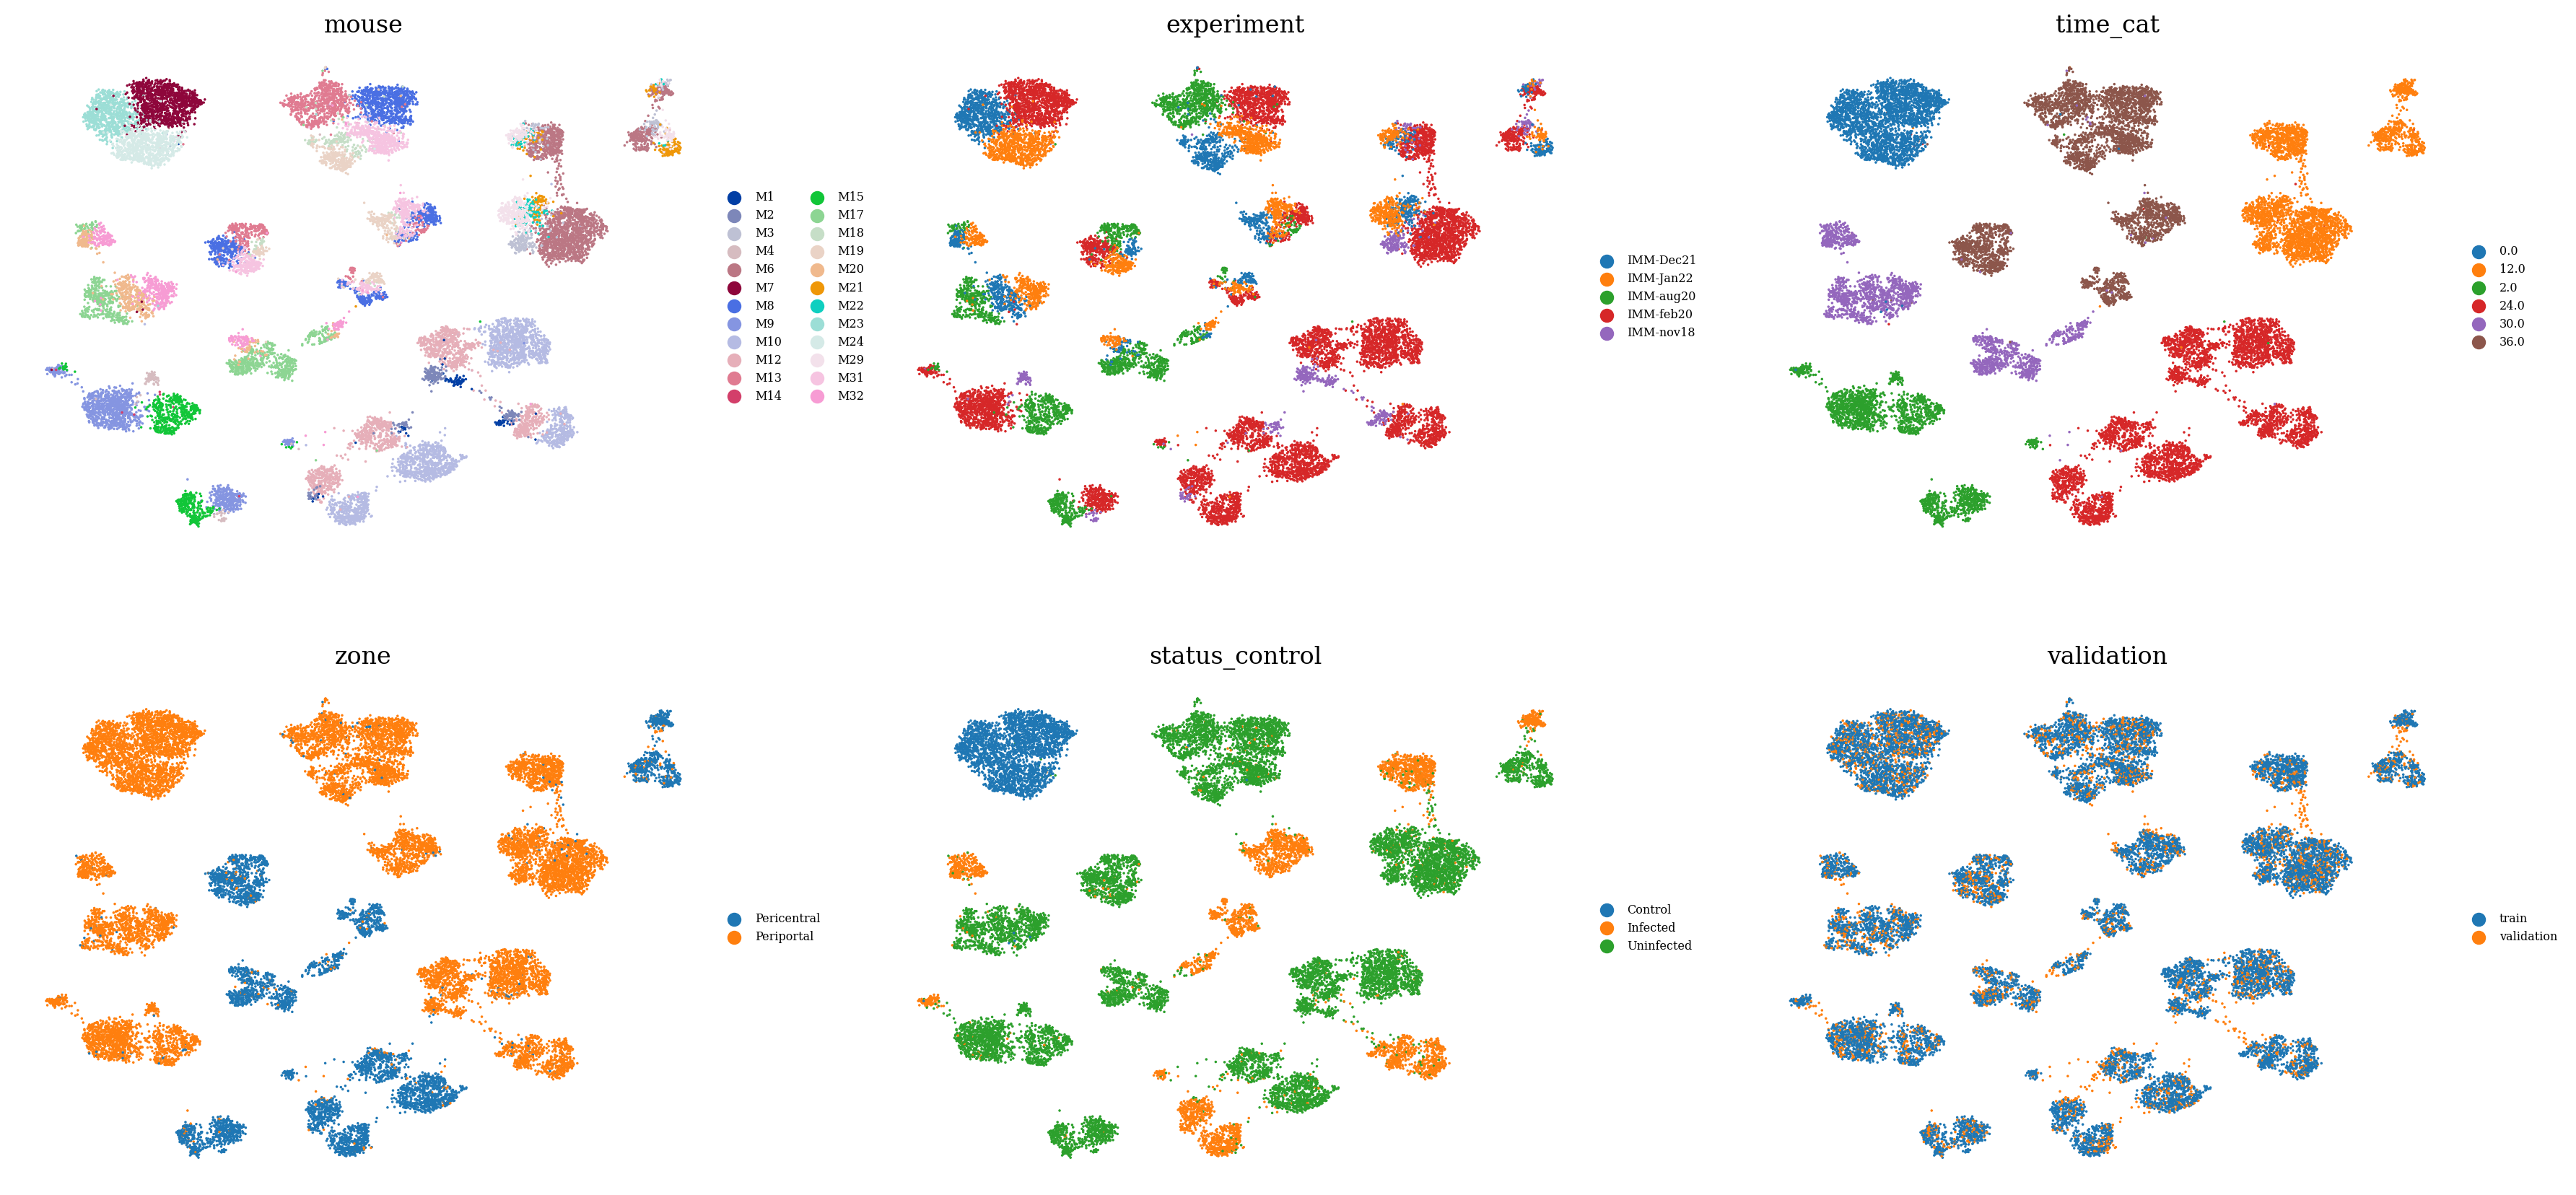

In [14]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent)
sc.tl.umap(latent)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control', "validation"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

## Preds

In [15]:
adata_main = ad.read_h5ad(adata_file_path)
adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")

adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()

In [16]:
# latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main)[:, DM.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata_main.obs.copy())
latent_main = ad.AnnData(X=vae.get_latent_representation(adata_main), obs=adata_main.obs.copy())
sc.pp.neighbors(latent_main)
sc.tl.umap(latent_main)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


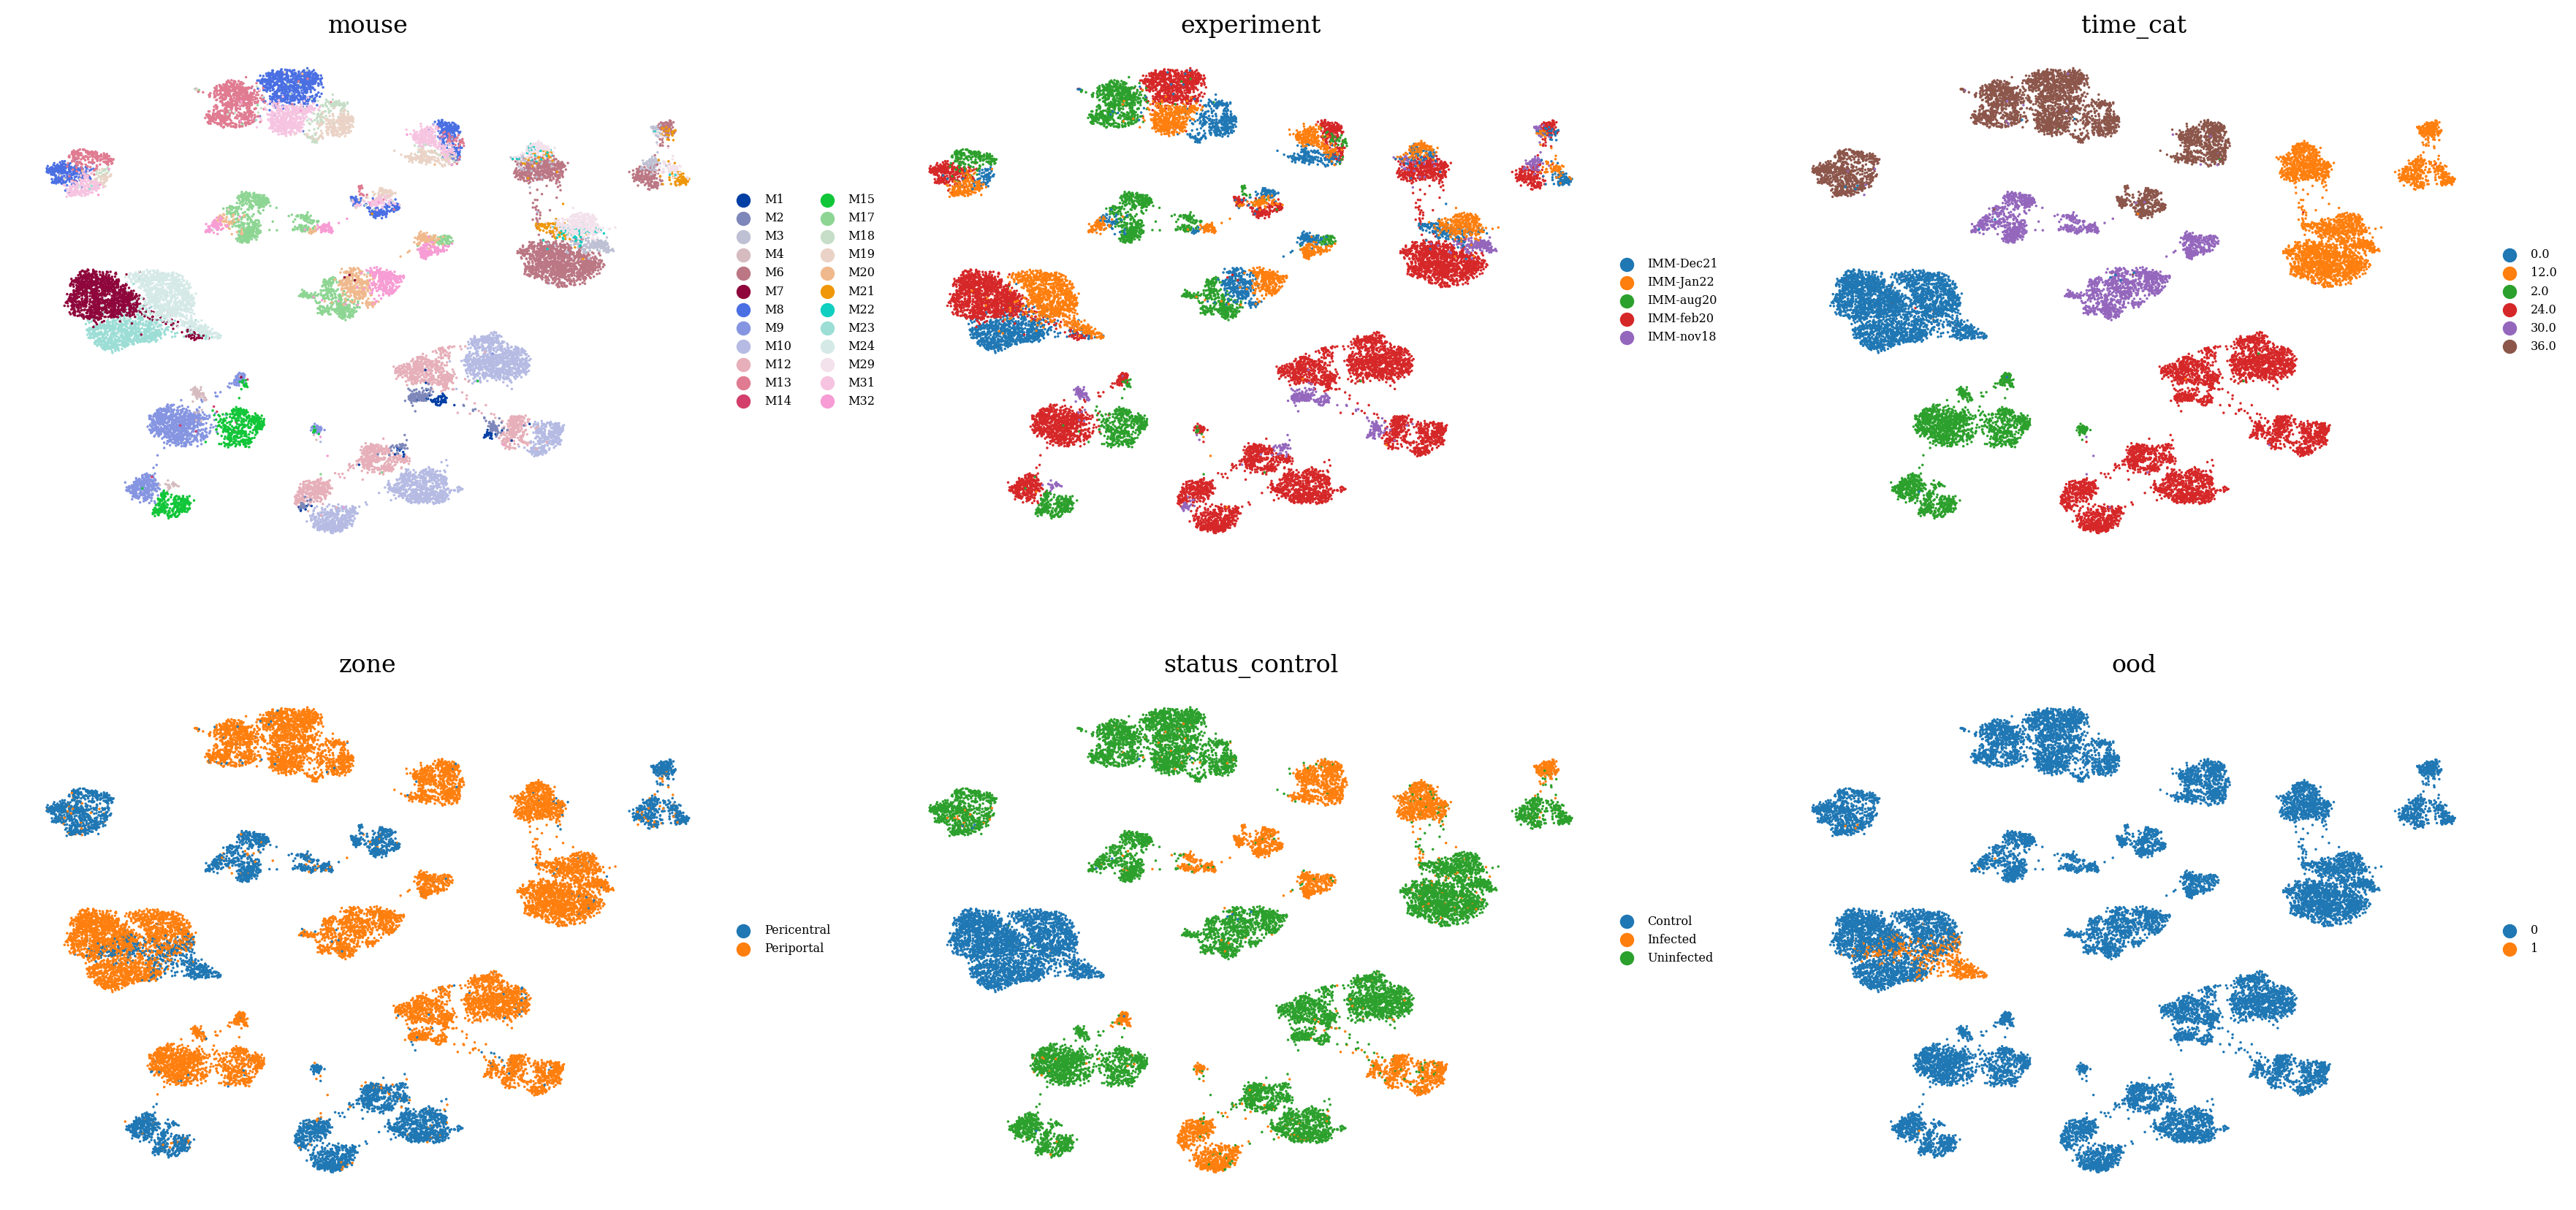

In [17]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_main, 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control', "ood"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [18]:
k = "status_control"

latent = ad.AnnData(X=vae.get_latent_representation(adata)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata.obs.copy())
sc.pp.neighbors(latent)

latent_ood = ad.AnnData(X=vae.get_latent_representation(adata_ood)[:, DM.configurations.get_by_obs_key(k).reserved_latent_indices], obs=adata_ood.obs.copy())
sc.pp.neighbors(latent_ood)
sc.tl.umap(latent_ood)

label_transfer(latent, latent_ood, cluster_list=[k], neighbors_count=30)
predicted = latent_ood.obs[f"transf_{k}"].astype(str).values
true = latent_ood.obs[k].astype(str).values

metrics = {}
metrics['accuracy'] = sklearn.metrics.accuracy_score(true, predicted)
metrics['precision_macro'] = sklearn.metrics.precision_score(true, predicted, average='macro', zero_division=0)
metrics['recall_macro'] = sklearn.metrics.recall_score(true, predicted, average='macro', zero_division=0)
metrics['f1_score_macro'] = sklearn.metrics.f1_score(true, predicted, average='macro', zero_division=0)
metrics['precision_micro'] = sklearn.metrics.precision_score(true, predicted, average='micro', zero_division=0)
metrics['recall_micro'] = sklearn.metrics.recall_score(true, predicted, average='micro', zero_division=0)
metrics['f1_score_micro'] = sklearn.metrics.f1_score(true, predicted, average='micro', zero_division=0)
metrics['precision_weighted'] = sklearn.metrics.precision_score(true, predicted, average='weighted', zero_division=0)
metrics['recall_weighted'] = sklearn.metrics.recall_score(true, predicted, average='weighted', zero_division=0)
metrics['f1_score_weighted'] = sklearn.metrics.f1_score(true, predicted, average='weighted', zero_division=0)
metrics['confusion_matrix'] = sklearn.metrics.confusion_matrix(true, predicted)

t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))
print("F1 Weighted:", sklearn.metrics.f1_score(t, dummy_predictions, average='weighted', zero_division=0))
print()
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))
print("F1 Weighted:", sklearn.metrics.f1_score(t, dummy_predictions, average='weighted', zero_division=0))
print()
metrics

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


Baseline Accuracy: 0.6161234451267517
F1 Weighted: 0.4697761186245088

Baseline Accuracy: 0.4537343200545846
F1 Weighted: 0.4540960691931205



{'accuracy': 0.9688644688644689,
 'precision_macro': 0.3333333333333333,
 'recall_macro': 0.322954822954823,
 'f1_score_macro': 0.328062015503876,
 'precision_micro': 0.9688644688644689,
 'recall_micro': 0.9688644688644689,
 'f1_score_micro': 0.9688644688644689,
 'precision_weighted': 1.0,
 'recall_weighted': 0.9688644688644689,
 'f1_score_weighted': 0.9841860465116279,
 'confusion_matrix': array([[529,   1,  16],
        [  0,   0,   0],
        [  0,   0,   0]])}

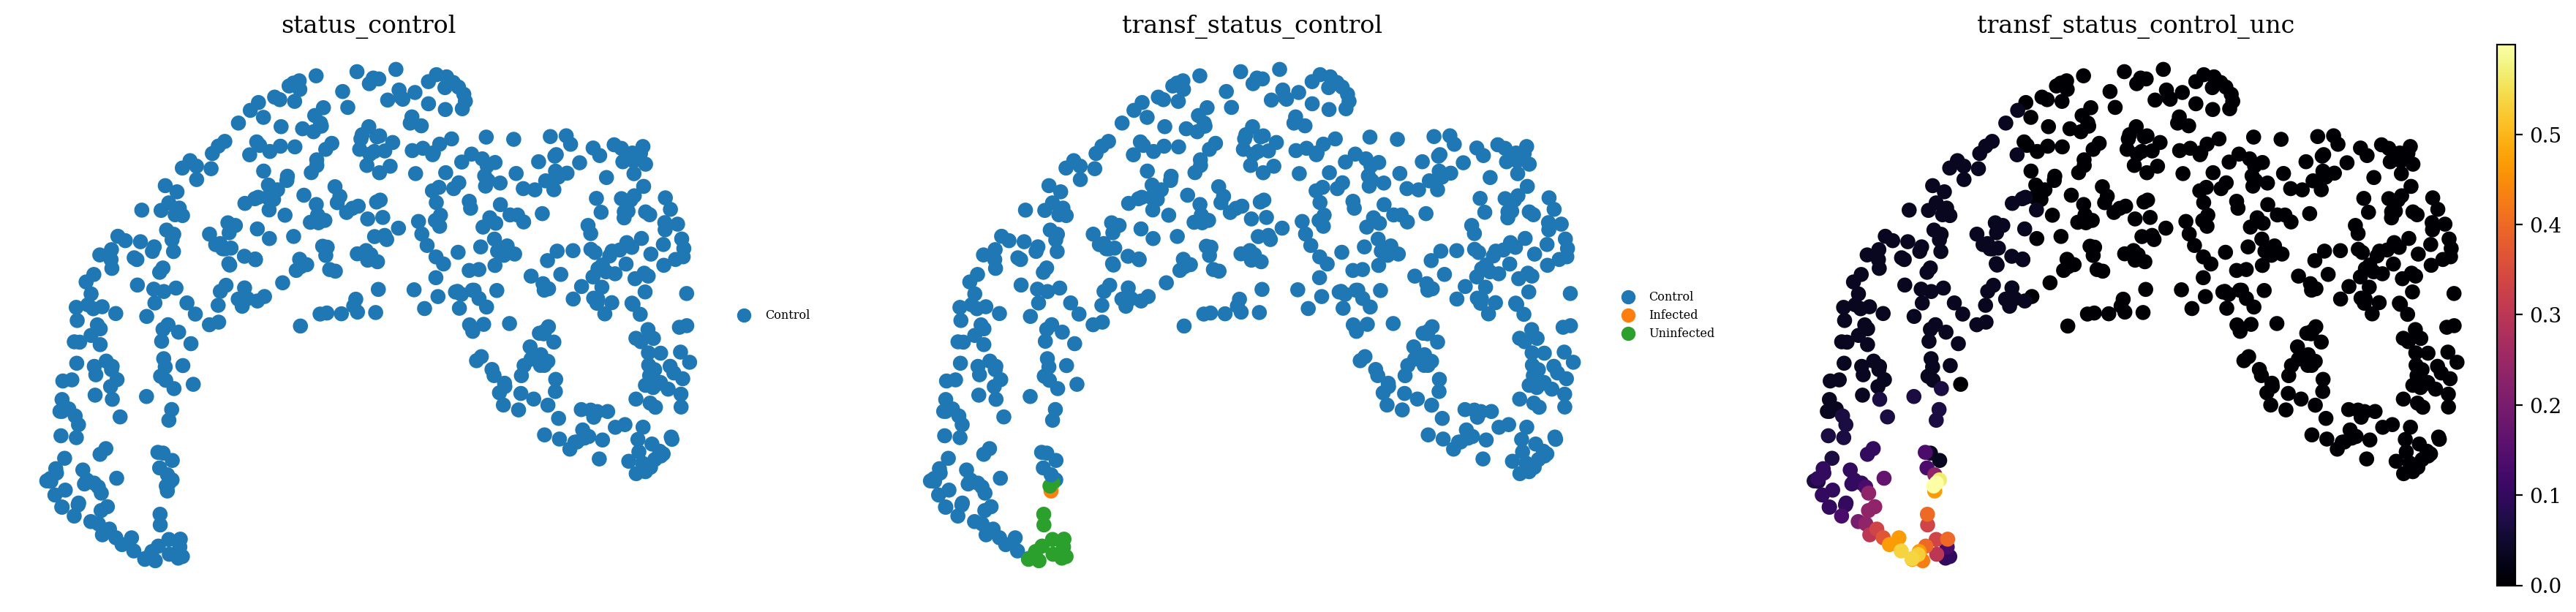

In [19]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent_ood, 
        color=[k, f"transf_{k}", f"transf_{k}_unc"], 
        ncols=4,
        frameon=False,
        color_map="inferno",
        legend_fontsize="xx-small"
    )

In [20]:
k = "status_control"

latent = ad.AnnData(X=vae.get_latent_representation(adata), obs=adata.obs.copy())
sc.pp.neighbors(latent)

latent_ood = ad.AnnData(X=vae.get_latent_representation(adata_ood), obs=adata_ood.obs.copy())
sc.pp.neighbors(latent_ood)
sc.tl.umap(latent_ood)

label_transfer(latent, latent_ood, cluster_list=[k], neighbors_count=30)
predicted = latent_ood.obs[f"transf_{k}"].astype(str).values
true = latent_ood.obs[k].astype(str).values

metrics = {}
metrics['accuracy'] = sklearn.metrics.accuracy_score(true, predicted)
metrics['precision_macro'] = sklearn.metrics.precision_score(true, predicted, average='macro', zero_division=0)
metrics['recall_macro'] = sklearn.metrics.recall_score(true, predicted, average='macro', zero_division=0)
metrics['f1_score_macro'] = sklearn.metrics.f1_score(true, predicted, average='macro', zero_division=0)
metrics['precision_micro'] = sklearn.metrics.precision_score(true, predicted, average='micro', zero_division=0)
metrics['recall_micro'] = sklearn.metrics.recall_score(true, predicted, average='micro', zero_division=0)
metrics['f1_score_micro'] = sklearn.metrics.f1_score(true, predicted, average='micro', zero_division=0)
metrics['precision_weighted'] = sklearn.metrics.precision_score(true, predicted, average='weighted', zero_division=0)
metrics['recall_weighted'] = sklearn.metrics.recall_score(true, predicted, average='weighted', zero_division=0)
metrics['f1_score_weighted'] = sklearn.metrics.f1_score(true, predicted, average='weighted', zero_division=0)
metrics['confusion_matrix'] = sklearn.metrics.confusion_matrix(true, predicted)

t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))
print("F1 Weighted:", sklearn.metrics.f1_score(t, dummy_predictions, average='weighted', zero_division=0))
print()
t = latent_main.obs[k].astype(str).to_numpy().copy()
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(t.reshape(-1, 1), t)
dummy_predictions = dummy_clf.predict(t.reshape(-1, 1))
print("Baseline Accuracy:", sklearn.metrics.accuracy_score(t, dummy_predictions))
print("F1 Weighted:", sklearn.metrics.f1_score(t, dummy_predictions, average='weighted', zero_division=0))
print()
metrics

Baseline Accuracy: 0.6161234451267517
F1 Weighted: 0.4697761186245088

Baseline Accuracy: 0.4506901800241432


F1 Weighted: 0.4514515761138626



{'accuracy': 0.9633699633699634,
 'precision_macro': 0.3333333333333333,
 'recall_macro': 0.32112332112332115,
 'f1_score_macro': 0.3271144278606965,
 'precision_micro': 0.9633699633699634,
 'recall_micro': 0.9633699633699634,
 'f1_score_micro': 0.9633699633699634,
 'precision_weighted': 1.0,
 'recall_weighted': 0.9633699633699634,
 'f1_score_weighted': 0.9813432835820896,
 'confusion_matrix': array([[526,   2,  18],
        [  0,   0,   0],
        [  0,   0,   0]])}